In [1]:
import time
import warnings
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error , make_scorer, r2_score
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

# !pip install lightgbm -q
import lightgbm as lgbm
from lightgbm import Dataset

import optuna

# warnings.filterwarnings(action="ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore")

matplotlib.style.use("ggplot")
pd.set_option("display.max_rows", 30)
pd.options.mode.chained_assignment = None

/Users/riter/anaconda3/envs/s7_case/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загрузка данных

In [2]:
X_train = pd.read_csv('../data/X_train.csv', parse_dates=['reportts'])
y_train = pd.read_csv('../data/y_train.csv', parse_dates=['reportts'])

X_test = pd.read_csv('../data/X_test.csv', parse_dates=['reportts'])


dataset = X_train.merge(y_train, on=['acnum', 'pos', 'reportts']).dropna(subset=['egtm'])

In [3]:
dataset.head()

,reportts,acnum,pos,fltdes,dep,arr,ivs12,ibe,iaie,iai,...,votm,vsva,w14,pf,wai,nai,prv,hpv,xf,egtm
0,2018-12-24 10:53:22,VQ-BGU,1,8990.0,EDHI,UUDD,NaN,NaN,NaN,NaN,...,NaN,0.0,1160.0,0.53,0.0,0.0,1.0,0.0,0.0,44.437
1,2018-12-24 10:53:22,VQ-BGU,2,8990.0,EDHI,UUDD,NaN,NaN,NaN,NaN,...,NaN,0.0,1160.0,0.53,0.0,0.0,1.0,0.0,0.0,45.869
2,2018-12-25 15:23:23,VQ-BGU,1,1024.0,URSS,UUDD,NaN,NaN,NaN,NaN,...,NaN,0.0,1179.0,0.53,0.0,0.0,1.0,0.0,0.0,44.379
3,2018-12-25 15:23:23,VQ-BGU,2,1024.0,URSS,UUDD,NaN,NaN,NaN,NaN,...,NaN,0.0,1179.0,0.53,0.0,0.0,1.0,0.0,0.0,44.904
4,2018-12-25 20:49:27,VQ-BGU,1,217.0,UUDD,UNBB,NaN,NaN,NaN,NaN,...,NaN,0.0,1302.0,0.51,0.0,0.0,1.0,0.0,0.0,43.742


In [4]:
dataset.shape

(2827, 166)

In [5]:
# Delete cols where all values are Nan
dataset = dataset.dropna(axis=1, how='all')

# Fill NaNs
dataset = dataset.fillna(method='ffill')

In [6]:
dataset.shape

(2827, 144)

In [7]:
dataset_time_sorted = dataset.sort_values(by='reportts').reset_index(drop=True)

In [8]:
dataset_time_sorted.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2827 entries, 0 to 2826
Data columns (total 144 columns):
 #    Column      Dtype         
---   ------      -----         
 0    reportts    datetime64[ns]
 1    acnum       object        
 2    pos         int64         
 3    fltdes      float64       
 4    dep         object        
 5    arr         object        
 6    acct        float64       
 7    alt         float64       
 8    alt_peak    float64       
 9    alt_rtd     float64       
 10   aoc         float64       
 11   b25         float64       
 12   baf         float64       
 13   bbf         float64       
 14   bbr         float64       
 15   bbv         float64       
 16   btmc        float64       
 17   cas         float64       
 18   cas_peak    float64       
 19   cas_rtd     float64       
 20   cg          float64       
 21   cnt         int64         
 22   code        int64         
 23   dflm        float64       
 24   dflm_peak   float64       
 

In [150]:
dataset_time_sorted_BGU = dataset_time_sorted[dataset_time_sorted['acnum'] == 'VQ-BGU'].reset_index(drop=True)
dataset_time_sorted_BDU = dataset_time_sorted[dataset_time_sorted['acnum'] == 'VQ-BDU'].reset_index(drop=True)

drop_cols = ["reportts", "egtm", "acnum"]

X = dataset_time_sorted_BGU.drop(drop_cols, axis=1, errors="ignore")
y = dataset_time_sorted_BGU["egtm"]

# cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features = ['pos','dep', 'arr']

for col in cat_features:
    X[col] = X[col].astype('category')

random_state = 42

## BGU

In [10]:
encoder = LabelEncoder()
features_to_encode = ['dep', 'arr']
for col in features_to_encode:
    X[col] = encoder.fit_transform(X[col])

In [151]:
import numpy as np

# Calculate the 95th and 98th percentiles of 'egtm'
lower_bound = dataset_time_sorted_BGU["egtm"].quantile(0.04)
upper_bound = dataset_time_sorted_BGU["egtm"].quantile(0.96)

# Filter the dataset to exclude outliers
filtered_dataset = dataset_time_sorted_BGU[(dataset_time_sorted_BGU["egtm"] >= lower_bound) & 
                                           (dataset_time_sorted_BGU["egtm"] <= upper_bound)]

X_filtered = filtered_dataset.drop(drop_cols, axis=1, errors="ignore")
y_filtered = filtered_dataset["egtm"]

# Convert categorical features
for col in cat_features:
    X_filtered[col] = X_filtered[col].astype('category')

# Encode categorical features
encoder = LabelEncoder()
for col in features_to_encode:
    X_filtered[col] = encoder.fit_transform(X_filtered[col])

In [152]:
X = X_filtered.copy()
y = y_filtered.copy()

In [153]:
def objective(trial,data=X,target=y):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25,random_state=42)

    param = {
        'objective': "huber",
        'boosting_type': 'dart',
        'n_jobs': 1,
        'verbose': -1,
        'cat_feature': [0, 2, 3],
        'num_leaves': trial.suggest_int('num_leaves', 4, 30),
        'max_bin': trial.suggest_int('max_bin', 20, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        # НЕ работают с huber loss
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'alpha': trial.suggest_uniform('alpha', 0.1, 2.0)
    }
    
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)], callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds = model.predict(X_test)

    
    
    rmse = mean_squared_error(y_test, preds,squared=False)
    
    return rmse


In [154]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=1000,
               n_jobs = -1,
               show_progress_bar=True)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-06-05 00:11:40,039] A new study created in memory with name: no-name-cb630f04-df17-456f-8132-db05a6846f9a
Best trial: 1. Best value: 1.10972:   1%|      | 8/1000 [00:00<00:29, 34.19it/s]

[I 2024-06-05 00:11:40,164] Trial 4 finished with value: 45.90514400140204 and parameters: {'num_leaves': 6, 'max_bin': 253, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.013285288076436618, 'alpha': 0.38829429880791405}. Best is trial 4 with value: 45.90514400140204.
[I 2024-06-05 00:11:40,196] Trial 3 finished with value: 3.266804309527932 and parameters: {'num_leaves': 26, 'max_bin': 370, 'max_depth': 3, 'min_data_in_leaf': 1, 'learning_rate': 0.34884702479313423, 'alpha': 1.361481042711574}. Best is trial 3 with value: 3.266804309527932.
[I 2024-06-05 00:11:40,212] Trial 1 finished with value: 1.1097219185414462 and parameters: {'num_leaves': 14, 'max_bin': 319, 'max_depth': 4, 'min_data_in_leaf': 10, 'learning_rate': 0.6688034161966532, 'alpha': 0.9969347138718881}. Best is trial 1 with value: 1.1097219185414462.
[I 2024-06-05 00:11:40,241] Trial 0 finished with value: 14.659410177040913 and parameters: {'num_leaves': 18, 'max_bin': 384, 'max_depth': 9, 'min_data_in_l

Best trial: 10. Best value: 0.859833:   2%|   | 16/1000 [00:00<00:28, 34.87it/s]

[I 2024-06-05 00:11:40,391] Trial 9 finished with value: 12.481611993918344 and parameters: {'num_leaves': 24, 'max_bin': 190, 'max_depth': 13, 'min_data_in_leaf': 7, 'learning_rate': 0.07587160927974218, 'alpha': 1.2943693826636418}. Best is trial 1 with value: 1.1097219185414462.
[I 2024-06-05 00:11:40,421] Trial 10 finished with value: 0.8598331509638663 and parameters: {'num_leaves': 12, 'max_bin': 201, 'max_depth': 14, 'min_data_in_leaf': 1, 'learning_rate': 0.8623253990801514, 'alpha': 1.260525668420423}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:40,423] Trial 14 finished with value: 45.899466566932105 and parameters: {'num_leaves': 28, 'max_bin': 107, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.24866016865780213, 'alpha': 0.2195123827191196}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:40,473] Trial 13 finished with value: 14.703114724575645 and parameters: {'num_leaves': 12, 'max_bin': 354, 'max_depth': 14, 'min_

Best trial: 10. Best value: 0.859833:   2%|   | 25/1000 [00:00<00:28, 34.25it/s]

[I 2024-06-05 00:11:40,601] Trial 17 finished with value: 1.029889787407429 and parameters: {'num_leaves': 7, 'max_bin': 51, 'max_depth': 3, 'min_data_in_leaf': 3, 'learning_rate': 0.8923189876581826, 'alpha': 1.7539961515476616}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:40,642] Trial 18 finished with value: 0.8940912688237742 and parameters: {'num_leaves': 8, 'max_bin': 61, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8331887623046057, 'alpha': 1.8930453806817633}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:40,647] Trial 19 finished with value: 1.0946272070443155 and parameters: {'num_leaves': 9, 'max_bin': 22, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.981052533539082, 'alpha': 1.9280471138312247}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:40,693] Trial 20 finished with value: 1.205702401318587 and parameters: {'num_leaves': 7, 'max_bin': 86, 'max_depth': 12, 'min_data_in_le

[I 2024-06-05 00:11:40,791] Trial 26 finished with value: 45.93127328575385 and parameters: {'num_leaves': 4, 'max_bin': 84, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5033389977515716, 'alpha': 1.649861574966609}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:40,894] Trial 28 finished with value: 46.06037951820091 and parameters: {'num_leaves': 10, 'max_bin': 75, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.4876627835860892, 'alpha': 1.5938553081937663}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:40,898] Trial 27 finished with value: 0.9680975707829316 and parameters: {'num_leaves': 10, 'max_bin': 107, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.4724395462391948, 'alpha': 1.599723575423913}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:40,906] Trial 29 finished with value: 1.3330887009019317 and parameters: {'num_leaves': 4, 'max_bin': 77, 'max_depth': 11, 'min_data_in

Best trial: 10. Best value: 0.859833:   4%|   | 38/1000 [00:01<00:30, 31.21it/s]

[I 2024-06-05 00:11:41,035] Trial 34 finished with value: 46.00070365474909 and parameters: {'num_leaves': 11, 'max_bin': 225, 'max_depth': 9, 'min_data_in_leaf': 1, 'learning_rate': 0.42211788850944326, 'alpha': 1.4733198220399129}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:41,049] Trial 32 finished with value: 0.9824059485162852 and parameters: {'num_leaves': 11, 'max_bin': 221, 'max_depth': 9, 'min_data_in_leaf': 1, 'learning_rate': 0.4921641945896949, 'alpha': 1.4458665260522723}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:41,054] Trial 33 finished with value: 1.0811685105131845 and parameters: {'num_leaves': 11, 'max_bin': 135, 'max_depth': 7, 'min_data_in_leaf': 1, 'learning_rate': 0.4569213767855622, 'alpha': 1.46435685775613}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:41,165] Trial 38 finished with value: 45.94984525827155 and parameters: {'num_leaves': 11, 'max_bin': 221, 'max_depth': 9, 'min_data_

Best trial: 41. Best value: 0.807626:   4%|▏  | 44/1000 [00:01<00:32, 29.77it/s]

[I 2024-06-05 00:11:41,290] Trial 40 finished with value: 45.98367591183408 and parameters: {'num_leaves': 15, 'max_bin': 112, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6439803531198812, 'alpha': 1.0941010051556115}. Best is trial 10 with value: 0.8598331509638663.
[I 2024-06-05 00:11:41,328] Trial 39 finished with value: 0.8414285473111187 and parameters: {'num_leaves': 16, 'max_bin': 221, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6430340590462975, 'alpha': 1.2106922816963293}. Best is trial 39 with value: 0.8414285473111187.
[I 2024-06-05 00:11:41,381] Trial 42 finished with value: 0.829683208223897 and parameters: {'num_leaves': 15, 'max_bin': 103, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6765629399581872, 'alpha': 1.1208045853195827}. Best is trial 42 with value: 0.829683208223897.
[I 2024-06-05 00:11:41,382] Trial 41 finished with value: 0.8076259245450292 and parameters: {'num_leaves': 15, 'max_bin': 166, 'max_depth': 12, 'min_d

Best trial: 46. Best value: 0.746825:   5%|▏  | 52/1000 [00:01<00:31, 29.66it/s]

[I 2024-06-05 00:11:41,511] Trial 46 finished with value: 0.7468250665220253 and parameters: {'num_leaves': 15, 'max_bin': 168, 'max_depth': 15, 'min_data_in_leaf': 4, 'learning_rate': 0.6625399184721846, 'alpha': 1.8422031465661697}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:41,517] Trial 47 finished with value: 45.959503862564716 and parameters: {'num_leaves': 16, 'max_bin': 170, 'max_depth': 15, 'min_data_in_leaf': 6, 'learning_rate': 0.31031395268360984, 'alpha': 1.8272450977044083}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:41,528] Trial 45 finished with value: 0.7605349283291898 and parameters: {'num_leaves': 15, 'max_bin': 168, 'max_depth': 15, 'min_data_in_leaf': 4, 'learning_rate': 0.6721204548953396, 'alpha': 1.82759243190369}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:41,620] Trial 49 finished with value: 5.432090074819943 and parameters: {'num_leaves': 17, 'max_bin': 186, 'max_depth': 13, 'min_

Best trial: 46. Best value: 0.746825:   6%|▏  | 58/1000 [00:01<00:30, 31.08it/s]

[I 2024-06-05 00:11:41,750] Trial 52 finished with value: 6.545018487506785 and parameters: {'num_leaves': 20, 'max_bin': 172, 'max_depth': 15, 'min_data_in_leaf': 6, 'learning_rate': 0.3411209886782715, 'alpha': 0.9415157246800314}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:41,756] Trial 53 finished with value: 6.403937986113507 and parameters: {'num_leaves': 20, 'max_bin': 173, 'max_depth': 15, 'min_data_in_leaf': 5, 'learning_rate': 0.3419191903689959, 'alpha': 0.9555395420025056}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:41,788] Trial 55 finished with value: 6.938918957311609 and parameters: {'num_leaves': 20, 'max_bin': 182, 'max_depth': 13, 'min_data_in_leaf': 6, 'learning_rate': 0.32400332608383653, 'alpha': 0.9402917973551529}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:41,810] Trial 54 finished with value: 5.692324200550632 and parameters: {'num_leaves': 19, 'max_bin': 182, 'max_depth': 13, 'min_d

Best trial: 46. Best value: 0.746825:   6%|▏  | 64/1000 [00:02<00:31, 29.90it/s]

[I 2024-06-05 00:11:41,960] Trial 59 finished with value: 0.9583103958524624 and parameters: {'num_leaves': 14, 'max_bin': 156, 'max_depth': 15, 'min_data_in_leaf': 5, 'learning_rate': 0.7223796970908508, 'alpha': 0.9444384778061975}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:41,984] Trial 60 finished with value: 46.03061804182628 and parameters: {'num_leaves': 14, 'max_bin': 157, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.7487796845759432, 'alpha': 0.7156030956621189}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,013] Trial 61 finished with value: 3.052425657340898 and parameters: {'num_leaves': 13, 'max_bin': 150, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.6630237940554349, 'alpha': 0.7200225367000405}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,052] Trial 62 finished with value: 3.8861763648149505 and parameters: {'num_leaves': 14, 'max_bin': 204, 'max_depth': 14, 'min_

Best trial: 46. Best value: 0.746825:   7%|▏  | 72/1000 [00:02<00:30, 30.03it/s]

[I 2024-06-05 00:11:42,173] Trial 65 finished with value: 1.3077840734545019 and parameters: {'num_leaves': 13, 'max_bin': 201, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.5746359245526885, 'alpha': 1.0959325369132236}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,188] Trial 66 finished with value: 1.3492953364058582 and parameters: {'num_leaves': 13, 'max_bin': 203, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.5726105931902711, 'alpha': 1.0774039866573089}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,259] Trial 67 finished with value: 1.3604477376671815 and parameters: {'num_leaves': 22, 'max_bin': 204, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.5760632344896236, 'alpha': 1.0554912979628277}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,271] Trial 68 finished with value: 1.1578619381141808 and parameters: {'num_leaves': 16, 'max_bin': 200, 'max_depth': 14, 'mi

Best trial: 46. Best value: 0.746825:   8%|▏  | 78/1000 [00:02<00:32, 28.36it/s]

[I 2024-06-05 00:11:42,426] Trial 72 finished with value: 1.6097784038031553 and parameters: {'num_leaves': 16, 'max_bin': 121, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5639356072525842, 'alpha': 1.029278675403968}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,464] Trial 73 finished with value: 7.185406427854895 and parameters: {'num_leaves': 16, 'max_bin': 245, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.2177138431690626, 'alpha': 1.35640729248262}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,479] Trial 74 finished with value: 13.875255966095448 and parameters: {'num_leaves': 16, 'max_bin': 121, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.034229027810718654, 'alpha': 1.3267183948514714}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,529] Trial 75 finished with value: 7.199080088352825 and parameters: {'num_leaves': 16, 'max_bin': 122, 'max_depth': 12, 'min_d

Best trial: 46. Best value: 0.746825:   8%|▎  | 84/1000 [00:02<00:32, 28.12it/s]

[I 2024-06-05 00:11:42,650] Trial 79 finished with value: 7.24447222162762 and parameters: {'num_leaves': 18, 'max_bin': 108, 'max_depth': 15, 'min_data_in_leaf': 9, 'learning_rate': 0.22793835852980668, 'alpha': 1.2944354380045224}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,720] Trial 80 finished with value: 0.7985284048691936 and parameters: {'num_leaves': 15, 'max_bin': 235, 'max_depth': 15, 'min_data_in_leaf': 10, 'learning_rate': 0.8418606187066195, 'alpha': 1.3276110549614366}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,740] Trial 82 finished with value: 0.9861331349116491 and parameters: {'num_leaves': 15, 'max_bin': 96, 'max_depth': 15, 'min_data_in_leaf': 10, 'learning_rate': 0.402891193883695, 'alpha': 1.9904242646691737}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,753] Trial 81 finished with value: 0.8065855760851126 and parameters: {'num_leaves': 18, 'max_bin': 125, 'max_depth': 15, 'min

Best trial: 46. Best value: 0.746825:   9%|▎  | 91/1000 [00:03<00:32, 28.18it/s]

[I 2024-06-05 00:11:42,853] Trial 85 finished with value: 2.712858382372751 and parameters: {'num_leaves': 12, 'max_bin': 235, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.4086315668632609, 'alpha': 1.2276914152601026}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,864] Trial 86 finished with value: 2.7093177797549397 and parameters: {'num_leaves': 18, 'max_bin': 92, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.40780265286098805, 'alpha': 1.2306046612522283}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:42,928] Trial 87 finished with value: 2.559204563995826 and parameters: {'num_leaves': 12, 'max_bin': 136, 'max_depth': 13, 'min_data_in_leaf': 2, 'learning_rate': 0.868699499882583, 'alpha': 0.5813613440280387}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,001] Trial 88 finished with value: 3.033430088303816 and parameters: {'num_leaves': 15, 'max_bin': 236, 'max_depth': 15, 'min_da

Best trial: 46. Best value: 0.746825:  10%|▎  | 96/1000 [00:03<00:32, 27.61it/s]

[I 2024-06-05 00:11:43,107] Trial 90 finished with value: 0.8095723732443998 and parameters: {'num_leaves': 17, 'max_bin': 232, 'max_depth': 10, 'min_data_in_leaf': 9, 'learning_rate': 0.8604925150176541, 'alpha': 1.179224138222058}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,114] Trial 93 finished with value: 46.0789818296767 and parameters: {'num_leaves': 19, 'max_bin': 262, 'max_depth': 5, 'min_data_in_leaf': 9, 'learning_rate': 0.859650266865922, 'alpha': 1.1455978814139385}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,156] Trial 92 finished with value: 0.8339522132567377 and parameters: {'num_leaves': 17, 'max_bin': 262, 'max_depth': 6, 'min_data_in_leaf': 9, 'learning_rate': 0.8597179642319853, 'alpha': 1.156498592343203}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,166] Trial 94 finished with value: 12.48593778350631 and parameters: {'num_leaves': 19, 'max_bin': 141, 'max_depth': 5, 'min_data_in

[I 2024-06-05 00:11:43,336] Trial 98 finished with value: 12.552791969184415 and parameters: {'num_leaves': 19, 'max_bin': 70, 'max_depth': 15, 'min_data_in_leaf': 3, 'learning_rate': 0.06790203901087317, 'alpha': 1.3987840771348437}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,361] Trial 99 finished with value: 13.212464837184113 and parameters: {'num_leaves': 17, 'max_bin': 98, 'max_depth': 15, 'min_data_in_leaf': 9, 'learning_rate': 0.5160758409866567, 'alpha': 0.13801530082837554}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,388] Trial 97 finished with value: 0.8424387846062549 and parameters: {'num_leaves': 19, 'max_bin': 262, 'max_depth': 15, 'min_data_in_leaf': 3, 'learning_rate': 0.5187628369182762, 'alpha': 1.7021374291909237}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,432] Trial 100 finished with value: 0.8901117142811897 and parameters: {'num_leaves': 17, 'max_bin': 98, 'max_depth': 15, 'mi

Best trial: 46. Best value: 0.746825:  11%|▏ | 108/1000 [00:03<00:30, 28.86it/s]

[I 2024-06-05 00:11:43,524] Trial 101 finished with value: 0.9629473359686315 and parameters: {'num_leaves': 21, 'max_bin': 288, 'max_depth': 15, 'min_data_in_leaf': 10, 'learning_rate': 0.9916557434637222, 'alpha': 1.3898957146748736}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,547] Trial 103 finished with value: 0.833413527425311 and parameters: {'num_leaves': 21, 'max_bin': 290, 'max_depth': 7, 'min_data_in_leaf': 10, 'learning_rate': 0.986976092563775, 'alpha': 1.0017422367145155}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,556] Trial 106 finished with value: 1.0246482633325782 and parameters: {'num_leaves': 30, 'max_bin': 129, 'max_depth': 3, 'min_data_in_leaf': 10, 'learning_rate': 0.9849363912852149, 'alpha': 1.8336263897781009}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,568] Trial 105 finished with value: 1.105268522554539 and parameters: {'num_leaves': 21, 'max_bin': 293, 'max_depth': 3, 'm

Best trial: 109. Best value: 0.720937:  12%| | 116/1000 [00:03<00:31, 27.82it/s]

[I 2024-06-05 00:11:43,825] Trial 113 finished with value: 46.02578969027717 and parameters: {'num_leaves': 15, 'max_bin': 319, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.7669283093531495, 'alpha': 0.8415730645007432}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,841] Trial 110 finished with value: 0.8441532042290909 and parameters: {'num_leaves': 15, 'max_bin': 256, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.6921103317049031, 'alpha': 1.2673629766614884}. Best is trial 46 with value: 0.7468250665220253.
[I 2024-06-05 00:11:43,847] Trial 109 finished with value: 0.7209373841121983 and parameters: {'num_leaves': 15, 'max_bin': 281, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.6704714578954036, 'alpha': 1.8658022723797394}. Best is trial 109 with value: 0.7209373841121983.
[I 2024-06-05 00:11:43,859] Trial 112 finished with value: 0.9540419962499787 and parameters: {'num_leaves': 15, 'max_bin': 256, 'max_depth': 6, '

Best trial: 118. Best value: 0.66288:  12%|▏ | 123/1000 [00:04<00:36, 23.87it/s]

[I 2024-06-05 00:11:44,158] Trial 120 finished with value: 45.969810777217724 and parameters: {'num_leaves': 24, 'max_bin': 302, 'max_depth': 5, 'min_data_in_leaf': 8, 'learning_rate': 0.2628850124888622, 'alpha': 1.906638521321394}. Best is trial 109 with value: 0.7209373841121983.
[I 2024-06-05 00:11:44,179] Trial 117 finished with value: 0.8955519601515858 and parameters: {'num_leaves': 25, 'max_bin': 253, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.7928930480721744, 'alpha': 1.1192490704554583}. Best is trial 109 with value: 0.7209373841121983.
[I 2024-06-05 00:11:44,213] Trial 119 finished with value: 0.83821260517193 and parameters: {'num_leaves': 25, 'max_bin': 277, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.7989807820054042, 'alpha': 1.7221164191040075}. Best is trial 109 with value: 0.7209373841121983.
[I 2024-06-05 00:11:44,237] Trial 118 finished with value: 0.662879569643734 and parameters: {'num_leaves': 18, 'max_bin': 308, 'max_depth': 8, 'min

Best trial: 118. Best value: 0.66288:  13%|▎ | 128/1000 [00:04<00:39, 22.21it/s]

[I 2024-06-05 00:11:44,418] Trial 124 finished with value: 0.8100758325405832 and parameters: {'num_leaves': 26, 'max_bin': 309, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.9190871558609066, 'alpha': 1.0013664033598195}. Best is trial 118 with value: 0.662879569643734.
[I 2024-06-05 00:11:44,511] Trial 127 finished with value: 45.99956356994817 and parameters: {'num_leaves': 27, 'max_bin': 270, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.9267189600362756, 'alpha': 0.7800097055998025}. Best is trial 118 with value: 0.662879569643734.
[I 2024-06-05 00:11:44,566] Trial 126 finished with value: 0.80295129399456 and parameters: {'num_leaves': 26, 'max_bin': 267, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.9114613915416708, 'alpha': 0.990785189216544}. Best is trial 118 with value: 0.662879569643734.
[I 2024-06-05 00:11:44,579] Trial 128 finished with value: 0.8465096581296707 and parameters: {'num_leaves': 23, 'max_bin': 309, 'max_depth': 7, 'min_da

Best trial: 130. Best value: 0.659794:  13%|▏| 133/1000 [00:04<00:40, 21.53it/s]

[I 2024-06-05 00:11:44,647] Trial 130 finished with value: 0.6597940203404027 and parameters: {'num_leaves': 13, 'max_bin': 358, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6470977219834055, 'alpha': 1.9599986182837261}. Best is trial 130 with value: 0.6597940203404027.
[I 2024-06-05 00:11:44,742] Trial 129 finished with value: 0.7652718831088228 and parameters: {'num_leaves': 27, 'max_bin': 353, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.4440274973230507, 'alpha': 1.9510907652510114}. Best is trial 130 with value: 0.6597940203404027.
[I 2024-06-05 00:11:44,756] Trial 132 finished with value: 13.91734428113355 and parameters: {'num_leaves': 26, 'max_bin': 333, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.022146301125847184, 'alpha': 1.9547741123448188}. Best is trial 130 with value: 0.6597940203404027.
[I 2024-06-05 00:11:44,787] Trial 131 finished with value: 0.747238267826599 and parameters: {'num_leaves': 26, 'max_bin': 366, 'max_depth': 9, 

Best trial: 133. Best value: 0.65628:  14%|▎ | 138/1000 [00:05<00:36, 23.55it/s]

[I 2024-06-05 00:11:44,888] Trial 133 finished with value: 0.6562798633427813 and parameters: {'num_leaves': 28, 'max_bin': 329, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6547361300344552, 'alpha': 1.879425948235328}. Best is trial 133 with value: 0.6562798633427813.
[I 2024-06-05 00:11:44,920] Trial 135 finished with value: 14.09359775457134 and parameters: {'num_leaves': 26, 'max_bin': 349, 'max_depth': 5, 'min_data_in_leaf': 3, 'learning_rate': 0.018605835914095616, 'alpha': 1.9557070593101882}. Best is trial 133 with value: 0.6562798633427813.
[I 2024-06-05 00:11:44,935] Trial 137 finished with value: 0.7960588887341956 and parameters: {'num_leaves': 26, 'max_bin': 357, 'max_depth': 4, 'min_data_in_leaf': 3, 'learning_rate': 0.44896268299267234, 'alpha': 1.9477850405033568}. Best is trial 133 with value: 0.6562798633427813.
[I 2024-06-05 00:11:44,990] Trial 136 finished with value: 0.6995275304364647 and parameters: {'num_leaves': 26, 'max_bin': 363, 'max_depth': 5,

Best trial: 140. Best value: 0.610615:  14%|▏| 142/1000 [00:05<00:49, 17.18it/s]

[I 2024-06-05 00:11:45,220] Trial 140 finished with value: 0.6106151185997216 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6860876173430808, 'alpha': 1.8839805276144308}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:45,294] Trial 139 finished with value: 0.7666852797742726 and parameters: {'num_leaves': 29, 'max_bin': 361, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.45220118510186974, 'alpha': 1.8883724610564356}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:45,318] Trial 141 finished with value: 0.6399213564122427 and parameters: {'num_leaves': 28, 'max_bin': 360, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6288060032947949, 'alpha': 1.9883177482809398}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:45,367] Trial 142 finished with value: 0.7215907504178042 and parameters: {'num_leaves': 27, 'max_bin': 351, 'max_depth': 9,

Best trial: 140. Best value: 0.610615:  15%|▏| 147/1000 [00:05<00:42, 19.95it/s]

[I 2024-06-05 00:11:45,458] Trial 143 finished with value: 0.7995850339133299 and parameters: {'num_leaves': 28, 'max_bin': 365, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.46180670978255817, 'alpha': 1.999697425691184}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:45,459] Trial 144 finished with value: 0.648915416166578 and parameters: {'num_leaves': 28, 'max_bin': 365, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6263469016403745, 'alpha': 1.9865911580068707}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:45,501] Trial 145 finished with value: 0.7785414525803874 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.4487331193415438, 'alpha': 1.9991083817955886}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:45,556] Trial 147 finished with value: 46.05684168434379 and parameters: {'num_leaves': 27, 'max_bin': 379, 'max_depth': 4, 'm

Best trial: 140. Best value: 0.610615:  15%|▏| 152/1000 [00:05<00:46, 18.18it/s]

[I 2024-06-05 00:11:45,740] Trial 152 finished with value: 45.99619894995989 and parameters: {'num_leaves': 29, 'max_bin': 383, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.5625915923803186, 'alpha': 1.9109643838573542}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:45,755] Trial 148 finished with value: 0.7623154292665033 and parameters: {'num_leaves': 28, 'max_bin': 379, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.44788620315820593, 'alpha': 1.9201605301519782}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:45,768] Trial 149 finished with value: 0.7622582974696063 and parameters: {'num_leaves': 28, 'max_bin': 383, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.5685357575101564, 'alpha': 1.916231209294196}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:45,821] Trial 150 finished with value: 0.7078227231515973 and parameters: {'num_leaves': 28, 'max_bin': 382, 'max_depth': 9, '

Best trial: 140. Best value: 0.610615:  16%|▏| 156/1000 [00:06<00:44, 18.99it/s]

[I 2024-06-05 00:11:45,961] Trial 153 finished with value: 0.7589910008123552 and parameters: {'num_leaves': 30, 'max_bin': 377, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.5875254162836351, 'alpha': 1.9164319634247196}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,001] Trial 154 finished with value: 0.7290377128987134 and parameters: {'num_leaves': 29, 'max_bin': 340, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.5705682145670051, 'alpha': 1.750703760421017}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,062] Trial 155 finished with value: 0.817225400728447 and parameters: {'num_leaves': 29, 'max_bin': 339, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.5672075574885691, 'alpha': 1.8024280843288496}. Best is trial 140 with value: 0.6106151185997216.


Best trial: 140. Best value: 0.610615:  16%|▏| 159/1000 [00:06<00:49, 16.94it/s]

[I 2024-06-05 00:11:46,183] Trial 156 finished with value: 0.6772936907852016 and parameters: {'num_leaves': 29, 'max_bin': 373, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6353780084972789, 'alpha': 1.7589700319562758}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,189] Trial 158 finished with value: 6.366945015757792 and parameters: {'num_leaves': 29, 'max_bin': 391, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.1834054046491812, 'alpha': 1.796963268317306}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,296] Trial 159 finished with value: 0.6195495307599888 and parameters: {'num_leaves': 29, 'max_bin': 396, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6241460001289479, 'alpha': 1.7524194060127005}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,310] Trial 157 finished with value: 0.6824208932741732 and parameters: {'num_leaves': 29, 'max_bin': 373, 'max_depth': 8, '

Best trial: 140. Best value: 0.610615:  16%|▏| 165/1000 [00:06<00:47, 17.75it/s]

[I 2024-06-05 00:11:46,489] Trial 161 finished with value: 0.7564578812805847 and parameters: {'num_leaves': 29, 'max_bin': 337, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.6183650929711912, 'alpha': 1.7864836335488947}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,493] Trial 160 finished with value: 0.8247080653400832 and parameters: {'num_leaves': 29, 'max_bin': 339, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.6265250404512317, 'alpha': 1.7696093824339363}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,506] Trial 162 finished with value: 0.7991981308275679 and parameters: {'num_leaves': 29, 'max_bin': 393, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.6369564682184419, 'alpha': 1.7519211387741929}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,559] Trial 163 finished with value: 0.8107412012642814 and parameters: {'num_leaves': 29, 'max_bin': 393, 'max_depth': 10

Best trial: 140. Best value: 0.610615:  17%|▏| 168/1000 [00:06<00:43, 19.04it/s]

[I 2024-06-05 00:11:46,725] Trial 165 finished with value: 0.8543725136054455 and parameters: {'num_leaves': 30, 'max_bin': 348, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.654939294782518, 'alpha': 1.737465193270379}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,754] Trial 167 finished with value: 0.8198106349212229 and parameters: {'num_leaves': 30, 'max_bin': 390, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.6332460268157191, 'alpha': 1.7300202308405088}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,840] Trial 168 finished with value: 45.95841487704285 and parameters: {'num_leaves': 30, 'max_bin': 372, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.713080746140399, 'alpha': 1.8684014155497686}. Best is trial 140 with value: 0.6106151185997216.


Best trial: 140. Best value: 0.610615:  17%|▏| 173/1000 [00:07<00:51, 16.14it/s]

[I 2024-06-05 00:11:46,950] Trial 171 finished with value: 12.688727681981279 and parameters: {'num_leaves': 30, 'max_bin': 348, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.0477906651807662, 'alpha': 1.875322173317978}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:46,982] Trial 170 finished with value: 0.650133267674757 and parameters: {'num_leaves': 30, 'max_bin': 372, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.70927780565641, 'alpha': 1.8653304178569943}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,006] Trial 169 finished with value: 0.6847130935246125 and parameters: {'num_leaves': 30, 'max_bin': 373, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7140281886416604, 'alpha': 1.8659520130202192}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,143] Trial 172 finished with value: 0.7801739378615258 and parameters: {'num_leaves': 28, 'max_bin': 372, 'max_depth': 8, '

Best trial: 140. Best value: 0.610615:  18%|▏| 177/1000 [00:07<00:51, 16.07it/s]

[I 2024-06-05 00:11:47,270] Trial 174 finished with value: 0.7257107105203461 and parameters: {'num_leaves': 28, 'max_bin': 371, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5563796355080819, 'alpha': 1.9723936526150656}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,303] Trial 176 finished with value: 0.7245351192575213 and parameters: {'num_leaves': 28, 'max_bin': 326, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5471190085930768, 'alpha': 1.9611033681063181}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,363] Trial 175 finished with value: 0.6783611360008617 and parameters: {'num_leaves': 28, 'max_bin': 374, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5354335061925598, 'alpha': 1.980060779837102}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,446] Trial 177 finished with value: 0.726822267116185 and parameters: {'num_leaves': 28, 'max_bin': 326, 'max_depth': 8, 'm

Best trial: 140. Best value: 0.610615:  18%|▏| 181/1000 [00:07<00:48, 16.90it/s]

[I 2024-06-05 00:11:47,511] Trial 178 finished with value: 0.7452703772484804 and parameters: {'num_leaves': 28, 'max_bin': 371, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5410981655953035, 'alpha': 1.9741174075795518}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,529] Trial 179 finished with value: 0.7113739651695552 and parameters: {'num_leaves': 28, 'max_bin': 324, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5437886451298863, 'alpha': 1.96933334152532}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,619] Trial 181 finished with value: 0.6873289960174822 and parameters: {'num_leaves': 27, 'max_bin': 327, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7207339288713646, 'alpha': 1.8262186072030884}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,657] Trial 180 finished with value: 0.6624913513920646 and parameters: {'num_leaves': 27, 'max_bin': 362, 'max_depth': 11,

Best trial: 140. Best value: 0.610615:  19%|▏| 186/1000 [00:07<00:46, 17.42it/s]

[I 2024-06-05 00:11:47,754] Trial 183 finished with value: 0.7328366745073087 and parameters: {'num_leaves': 27, 'max_bin': 323, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7252767634485504, 'alpha': 1.6690607152982457}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,782] Trial 184 finished with value: 45.96841811456356 and parameters: {'num_leaves': 27, 'max_bin': 357, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7175033794066694, 'alpha': 1.8207531401671195}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,793] Trial 182 finished with value: 0.6883564411483202 and parameters: {'num_leaves': 27, 'max_bin': 398, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7219640650105241, 'alpha': 1.8258719158095391}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:47,909] Trial 185 finished with value: 0.6611972207554994 and parameters: {'num_leaves': 27, 'max_bin': 357, 'max_depth': 9

Best trial: 140. Best value: 0.610615:  19%|▏| 190/1000 [00:08<00:46, 17.52it/s]

[I 2024-06-05 00:11:48,022] Trial 188 finished with value: 0.6843446831309514 and parameters: {'num_leaves': 27, 'max_bin': 399, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.728941821968524, 'alpha': 1.824762490474088}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,027] Trial 186 finished with value: 0.6248665115693636 and parameters: {'num_leaves': 27, 'max_bin': 359, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7356293238331457, 'alpha': 1.9298441507653472}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,136] Trial 189 finished with value: 0.6878454308036978 and parameters: {'num_leaves': 27, 'max_bin': 358, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7183606800448351, 'alpha': 1.822825861753692}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,139] Trial 190 finished with value: 0.7274835817285473 and parameters: {'num_leaves': 27, 'max_bin': 358, 'max_depth': 11, 

Best trial: 140. Best value: 0.610615:  20%|▏| 195/1000 [00:08<00:51, 15.67it/s]

[I 2024-06-05 00:11:48,296] Trial 192 finished with value: 0.7390689447132156 and parameters: {'num_leaves': 29, 'max_bin': 387, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7271638747893084, 'alpha': 1.8375034913589747}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,302] Trial 194 finished with value: 0.7050627690204536 and parameters: {'num_leaves': 27, 'max_bin': 387, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7404957499226661, 'alpha': 1.8294469346585218}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,316] Trial 193 finished with value: 0.7478104509416222 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7425803683092138, 'alpha': 1.8343593547557318}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,322] Trial 191 finished with value: 0.6331467321019081 and parameters: {'num_leaves': 29, 'max_bin': 386, 'max_depth': 

Best trial: 140. Best value: 0.610615:  20%|▏| 199/1000 [00:08<00:44, 18.15it/s]

[I 2024-06-05 00:11:48,524] Trial 198 finished with value: 0.7349775825432658 and parameters: {'num_leaves': 27, 'max_bin': 398, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7611772161985565, 'alpha': 1.8134728670497529}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,525] Trial 196 finished with value: 0.7597273890596149 and parameters: {'num_leaves': 27, 'max_bin': 390, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7379387026101876, 'alpha': 1.821256479338775}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,632] Trial 197 finished with value: 0.7670640868306832 and parameters: {'num_leaves': 27, 'max_bin': 400, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7722945602438488, 'alpha': 1.811706792862249}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,678] Trial 202 finished with value: 0.8572459568007346 and parameters: {'num_leaves': 5, 'max_bin': 367, 'max_depth': 10,

Best trial: 140. Best value: 0.610615:  20%|▏| 205/1000 [00:08<00:41, 19.34it/s]

[I 2024-06-05 00:11:48,750] Trial 200 finished with value: 0.7378082487134003 and parameters: {'num_leaves': 27, 'max_bin': 367, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8130269762781424, 'alpha': 1.9386396314349084}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,766] Trial 201 finished with value: 0.7874786351281404 and parameters: {'num_leaves': 27, 'max_bin': 366, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8275320939675391, 'alpha': 1.9317422264351136}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,786] Trial 203 finished with value: 0.7614297573806524 and parameters: {'num_leaves': 28, 'max_bin': 367, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8084547802291062, 'alpha': 1.9274840361724959}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:48,836] Trial 199 finished with value: 0.7220822568930597 and parameters: {'num_leaves': 27, 'max_bin': 366, 'max_depth': 

Best trial: 140. Best value: 0.610615:  21%|▏| 209/1000 [00:09<00:37, 20.93it/s]

[I 2024-06-05 00:11:49,006] Trial 206 finished with value: 0.8095044566440845 and parameters: {'num_leaves': 10, 'max_bin': 366, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8101508582820597, 'alpha': 1.9138716412754453}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,025] Trial 205 finished with value: 0.6856446305580421 and parameters: {'num_leaves': 28, 'max_bin': 365, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6769256451224148, 'alpha': 1.929588517521846}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,051] Trial 207 finished with value: 45.962497018754554 and parameters: {'num_leaves': 28, 'max_bin': 365, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.676741698259262, 'alpha': 1.9335417157137818}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,165] Trial 208 finished with value: 0.6790572812047778 and parameters: {'num_leaves': 28, 'max_bin': 357, 'max_depth': 11

Best trial: 140. Best value: 0.610615:  21%|▏| 213/1000 [00:09<00:45, 17.25it/s]

[I 2024-06-05 00:11:49,236] Trial 210 finished with value: 0.6727424217119233 and parameters: {'num_leaves': 29, 'max_bin': 354, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6676814297376584, 'alpha': 1.862595813145411}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,326] Trial 212 finished with value: 0.6852017049880126 and parameters: {'num_leaves': 29, 'max_bin': 354, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6817358438722432, 'alpha': 1.8625667885641108}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,364] Trial 211 finished with value: 0.6968585222500283 and parameters: {'num_leaves': 29, 'max_bin': 356, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6661332533018274, 'alpha': 1.867830140747908}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,409] Trial 214 finished with value: 45.95133056716228 and parameters: {'num_leaves': 29, 'max_bin': 355, 'max_depth': 9, 'm

Best trial: 140. Best value: 0.610615:  22%|▏| 219/1000 [00:09<00:42, 18.41it/s]

[I 2024-06-05 00:11:49,447] Trial 213 finished with value: 0.7093929952727419 and parameters: {'num_leaves': 29, 'max_bin': 353, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6102341826244573, 'alpha': 1.862823940369891}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,534] Trial 216 finished with value: 0.7000391848167109 and parameters: {'num_leaves': 29, 'max_bin': 377, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6786240832134539, 'alpha': 1.8676645619050005}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,563] Trial 215 finished with value: 0.6662631590588229 and parameters: {'num_leaves': 29, 'max_bin': 356, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6640926683755412, 'alpha': 1.8812516677175761}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,601] Trial 217 finished with value: 0.7066879429269753 and parameters: {'num_leaves': 30, 'max_bin': 380, 'max_depth': 9, '

Best trial: 140. Best value: 0.610615:  23%|▏| 226/1000 [00:10<00:40, 19.20it/s]

[I 2024-06-05 00:11:49,850] Trial 220 finished with value: 0.6474196401532001 and parameters: {'num_leaves': 30, 'max_bin': 376, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6239258128913705, 'alpha': 1.8832322988428134}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,905] Trial 221 finished with value: 0.6789073771392714 and parameters: {'num_leaves': 30, 'max_bin': 376, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.644525914671682, 'alpha': 1.6923390539844452}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,932] Trial 224 finished with value: 45.96579591987275 and parameters: {'num_leaves': 30, 'max_bin': 376, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6017232204258212, 'alpha': 1.6994263427396064}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:49,963] Trial 222 finished with value: 0.6492662210240369 and parameters: {'num_leaves': 30, 'max_bin': 378, 'max_depth': 9, 'm

Best trial: 140. Best value: 0.610615:  23%|▏| 227/1000 [00:10<00:40, 19.20it/s]

[I 2024-06-05 00:11:50,089] Trial 226 finished with value: 0.7210356409579295 and parameters: {'num_leaves': 30, 'max_bin': 341, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6014506178164178, 'alpha': 1.7678146765742717}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:50,095] Trial 227 finished with value: 0.7571628172065451 and parameters: {'num_leaves': 30, 'max_bin': 343, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.4967120628646507, 'alpha': 1.876949403531933}. Best is trial 140 with value: 0.6106151185997216.


Best trial: 140. Best value: 0.610615:  23%|▏| 234/1000 [00:10<00:43, 17.79it/s]

[I 2024-06-05 00:11:50,322] Trial 228 finished with value: 0.7173487201373879 and parameters: {'num_leaves': 30, 'max_bin': 345, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6087515589237856, 'alpha': 1.888062266251306}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:50,400] Trial 232 finished with value: 0.8088214632497654 and parameters: {'num_leaves': 29, 'max_bin': 374, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.4961578377421595, 'alpha': 1.7411756796502322}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:50,406] Trial 231 finished with value: 0.7759659429268614 and parameters: {'num_leaves': 30, 'max_bin': 343, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5148412619296067, 'alpha': 1.5835643297230464}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:50,429] Trial 229 finished with value: 0.7670066558338595 and parameters: {'num_leaves': 30, 'max_bin': 374, 'max_depth': 9, '

Best trial: 140. Best value: 0.610615:  24%|▏| 236/1000 [00:10<00:35, 21.46it/s]

[I 2024-06-05 00:11:50,537] Trial 234 finished with value: 0.7771999278670332 and parameters: {'num_leaves': 30, 'max_bin': 377, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.5023286651019684, 'alpha': 1.89812963070059}. Best is trial 140 with value: 0.6106151185997216.


Best trial: 140. Best value: 0.610615:  24%|▏| 241/1000 [00:10<00:46, 16.33it/s]

[I 2024-06-05 00:11:50,753] Trial 237 finished with value: 9.117792914260672 and parameters: {'num_leaves': 29, 'max_bin': 382, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.13434180768775744, 'alpha': 1.6396937265722313}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:50,791] Trial 236 finished with value: 0.8703181772800715 and parameters: {'num_leaves': 29, 'max_bin': 375, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.5177539533676202, 'alpha': 1.7106022270688894}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:50,846] Trial 238 finished with value: 45.94230012695495 and parameters: {'num_leaves': 29, 'max_bin': 382, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6218750209122342, 'alpha': 1.78617508474464}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:50,854] Trial 243 finished with value: 45.93715050140065 and parameters: {'num_leaves': 29, 'max_bin': 360, 'max_depth': 9, 'min

Best trial: 140. Best value: 0.610615:  24%|▏| 245/1000 [00:11<00:42, 17.74it/s]

[I 2024-06-05 00:11:50,948] Trial 241 finished with value: 0.6907428872198363 and parameters: {'num_leaves': 29, 'max_bin': 359, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6497078190207433, 'alpha': 1.7079867813183744}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:50,964] Trial 242 finished with value: 0.6949957935058994 and parameters: {'num_leaves': 29, 'max_bin': 362, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6401540854420528, 'alpha': 1.6990720311005296}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:51,136] Trial 244 finished with value: 0.7489563315685706 and parameters: {'num_leaves': 29, 'max_bin': 361, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6624572249926792, 'alpha': 1.7861765644844587}. Best is trial 140 with value: 0.6106151185997216.


Best trial: 140. Best value: 0.610615:  25%|▏| 249/1000 [00:11<00:47, 15.72it/s]

[I 2024-06-05 00:11:51,239] Trial 247 finished with value: 0.7351295887358417 and parameters: {'num_leaves': 28, 'max_bin': 361, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.67600747162067, 'alpha': 1.8942069787301443}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:51,345] Trial 245 finished with value: 0.729271538982711 and parameters: {'num_leaves': 29, 'max_bin': 360, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6398752177206517, 'alpha': 1.7960544554548143}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:51,368] Trial 246 finished with value: 0.6217998887976688 and parameters: {'num_leaves': 28, 'max_bin': 361, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6681762026124239, 'alpha': 1.9068767120193313}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:51,378] Trial 251 finished with value: 0.7221988302558408 and parameters: {'num_leaves': 28, 'max_bin': 370, 'max_depth': 8, 'mi

Best trial: 140. Best value: 0.610615:  25%|▎| 253/1000 [00:11<00:37, 19.69it/s]

[I 2024-06-05 00:11:51,449] Trial 248 finished with value: 0.6541991071108156 and parameters: {'num_leaves': 28, 'max_bin': 359, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5904761384243045, 'alpha': 1.8991085705469408}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:51,490] Trial 249 finished with value: 0.6615132330786643 and parameters: {'num_leaves': 28, 'max_bin': 352, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5853143516995505, 'alpha': 1.9102506448237295}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:51,511] Trial 252 finished with value: 0.7150574003530661 and parameters: {'num_leaves': 28, 'max_bin': 388, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.574495491852122, 'alpha': 1.9077069682691012}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:51,613] Trial 253 finished with value: 0.7450708981095114 and parameters: {'num_leaves': 28, 'max_bin': 351, 'max_depth': 8, '

Best trial: 140. Best value: 0.610615:  26%|▎| 261/1000 [00:11<00:35, 21.08it/s]

[I 2024-06-05 00:11:51,821] Trial 254 finished with value: 0.647141150607538 and parameters: {'num_leaves': 28, 'max_bin': 352, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.5813871779456942, 'alpha': 1.9526682174160632}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:51,870] Trial 258 finished with value: 45.97052820900418 and parameters: {'num_leaves': 30, 'max_bin': 389, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5997741573541527, 'alpha': 1.9506646266501935}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:51,889] Trial 256 finished with value: 0.6174420241405078 and parameters: {'num_leaves': 30, 'max_bin': 388, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.5647190007167115, 'alpha': 1.9493212385741516}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:51,891] Trial 257 finished with value: 0.6855690546818012 and parameters: {'num_leaves': 30, 'max_bin': 385, 'max_depth': 9, 'm

Best trial: 140. Best value: 0.610615:  27%|▎| 269/1000 [00:12<00:41, 17.76it/s]

[I 2024-06-05 00:11:52,310] Trial 267 finished with value: 0.7536747885766057 and parameters: {'num_leaves': 9, 'max_bin': 367, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.7261629716229255, 'alpha': 1.912492920953287}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:52,336] Trial 262 finished with value: 10.50438028802962 and parameters: {'num_leaves': 28, 'max_bin': 335, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.08744018755485998, 'alpha': 1.9428585048709661}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:52,338] Trial 265 finished with value: 45.92823590821995 and parameters: {'num_leaves': 30, 'max_bin': 349, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7405524883596318, 'alpha': 1.8961629495522325}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:52,407] Trial 264 finished with value: 0.6671078295489686 and parameters: {'num_leaves': 30, 'max_bin': 351, 'max_depth': 9, 'mi

Best trial: 140. Best value: 0.610615:  28%|▎| 277/1000 [00:12<00:43, 16.52it/s]

[I 2024-06-05 00:11:52,834] Trial 272 finished with value: 0.8455993280405049 and parameters: {'num_leaves': 30, 'max_bin': 365, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.856287422639157, 'alpha': 1.856374913424037}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:52,857] Trial 270 finished with value: 0.8683449643035743 and parameters: {'num_leaves': 30, 'max_bin': 365, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.7911870287081217, 'alpha': 1.860861455816202}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:52,888] Trial 271 finished with value: 0.9848683152913583 and parameters: {'num_leaves': 30, 'max_bin': 365, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.8361114185366886, 'alpha': 1.8612882024764128}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:52,913] Trial 273 finished with value: 0.9572329068497439 and parameters: {'num_leaves': 30, 'max_bin': 365, 'max_depth': 9, 'mi

Best trial: 140. Best value: 0.610615:  28%|▎| 282/1000 [00:13<00:47, 15.17it/s]

[I 2024-06-05 00:11:53,294] Trial 278 finished with value: 0.7669157642167649 and parameters: {'num_leaves': 29, 'max_bin': 341, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.771001350378105, 'alpha': 1.9385157618530706}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:53,396] Trial 281 finished with value: 0.6882557852754918 and parameters: {'num_leaves': 29, 'max_bin': 344, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6880492653302629, 'alpha': 1.9342789839433767}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:53,412] Trial 282 finished with value: 45.82546008222818 and parameters: {'num_leaves': 26, 'max_bin': 382, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.757092285918921, 'alpha': 1.9402815332152283}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:53,425] Trial 280 finished with value: 13.425058450635554 and parameters: {'num_leaves': 29, 'max_bin': 344, 'max_depth': 9, 'mi

Best trial: 140. Best value: 0.610615:  28%|▎| 285/1000 [00:13<00:40, 17.49it/s]

[I 2024-06-05 00:11:53,517] Trial 283 finished with value: 0.745952563754166 and parameters: {'num_leaves': 26, 'max_bin': 394, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7764633585981005, 'alpha': 1.9374352301396427}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:53,532] Trial 284 finished with value: 0.6934218507131201 and parameters: {'num_leaves': 29, 'max_bin': 394, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7713290746865588, 'alpha': 1.9567146241261886}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:53,670] Trial 285 finished with value: 0.6661986144798525 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7596437026628302, 'alpha': 1.9419990382048302}. Best is trial 140 with value: 0.6106151185997216.


Best trial: 140. Best value: 0.610615:  29%|▎| 289/1000 [00:13<00:46, 15.44it/s]

[I 2024-06-05 00:11:53,814] Trial 286 finished with value: 0.7171237534176171 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.4884139565828866, 'alpha': 1.9715996856787963}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:53,886] Trial 288 finished with value: 0.7751873280212501 and parameters: {'num_leaves': 12, 'max_bin': 388, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.4733669251942098, 'alpha': 1.9741267134934661}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:53,915] Trial 287 finished with value: 0.7035601923968808 and parameters: {'num_leaves': 29, 'max_bin': 392, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.4990755927134647, 'alpha': 1.9733967457411532}. Best is trial 140 with value: 0.6106151185997216.


Best trial: 140. Best value: 0.610615:  29%|▎| 294/1000 [00:14<00:41, 17.12it/s]

[I 2024-06-05 00:11:54,032] Trial 292 finished with value: 0.6782641537917508 and parameters: {'num_leaves': 23, 'max_bin': 358, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.5053261127591592, 'alpha': 1.844301561367253}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,037] Trial 289 finished with value: 0.705692248374581 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.4996573885172088, 'alpha': 1.998788709449542}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,046] Trial 290 finished with value: 0.7438936527038691 and parameters: {'num_leaves': 28, 'max_bin': 358, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.4789197183503375, 'alpha': 1.9778334272708196}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,058] Trial 291 finished with value: 0.7890604336157587 and parameters: {'num_leaves': 28, 'max_bin': 383, 'max_depth': 10,

Best trial: 140. Best value: 0.610615:  30%|▎| 298/1000 [00:14<00:41, 16.75it/s]

[I 2024-06-05 00:11:54,291] Trial 296 finished with value: 0.7735833435502154 and parameters: {'num_leaves': 28, 'max_bin': 381, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.9414325057463975, 'alpha': 1.8452727070538983}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,376] Trial 295 finished with value: 0.7523675198257487 and parameters: {'num_leaves': 28, 'max_bin': 381, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.9967334968658004, 'alpha': 1.840817747759909}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,418] Trial 299 finished with value: 0.9525907427598803 and parameters: {'num_leaves': 27, 'max_bin': 38, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6132572655367204, 'alpha': 1.8886463649621557}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,427] Trial 297 finished with value: 0.7082228590757967 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 9, '

Best trial: 140. Best value: 0.610615:  30%|▎| 304/1000 [00:14<00:33, 21.00it/s]

[I 2024-06-05 00:11:54,498] Trial 300 finished with value: 0.7160332867353553 and parameters: {'num_leaves': 27, 'max_bin': 371, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.9176828988682019, 'alpha': 1.8871466520666043}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,523] Trial 298 finished with value: 0.6818781019616955 and parameters: {'num_leaves': 27, 'max_bin': 372, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6124882848001411, 'alpha': 1.8919381638369757}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,605] Trial 303 finished with value: 6.0757307206410625 and parameters: {'num_leaves': 27, 'max_bin': 373, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.1805948064413962, 'alpha': 1.894055432286958}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,608] Trial 301 finished with value: 0.6568643906822496 and parameters: {'num_leaves': 27, 'max_bin': 374, 'max_depth': 9, '

Best trial: 140. Best value: 0.610615:  31%|▎| 308/1000 [00:14<00:40, 17.26it/s]

[I 2024-06-05 00:11:54,760] Trial 306 finished with value: 3.8260543448650277 and parameters: {'num_leaves': 27, 'max_bin': 372, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6901995690876447, 'alpha': 0.629490376956886}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,876] Trial 308 finished with value: 45.9180525863787 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.06492912493568721, 'alpha': 1.8169476251749128}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,885] Trial 307 finished with value: 0.6814672115562291 and parameters: {'num_leaves': 25, 'max_bin': 372, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6048720915523004, 'alpha': 1.9183371197206374}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:54,888] Trial 305 finished with value: 0.7162469425410857 and parameters: {'num_leaves': 27, 'max_bin': 371, 'max_depth': 9, 'm

Best trial: 312. Best value: 0.593915:  31%|▎| 311/1000 [00:15<00:34, 19.77it/s]

[I 2024-06-05 00:11:54,978] Trial 310 finished with value: 12.17676595922975 and parameters: {'num_leaves': 29, 'max_bin': 359, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.059755835348719304, 'alpha': 1.8268079343694492}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:55,056] Trial 309 finished with value: 0.661027952628369 and parameters: {'num_leaves': 29, 'max_bin': 358, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6894339723749527, 'alpha': 1.813911652211646}. Best is trial 140 with value: 0.6106151185997216.
[I 2024-06-05 00:11:55,143] Trial 312 finished with value: 0.593915152152774 and parameters: {'num_leaves': 28, 'max_bin': 359, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5937623321302689, 'alpha': 1.8149757264995643}. Best is trial 312 with value: 0.593915152152774.


[I 2024-06-05 00:11:55,227] Trial 311 finished with value: 0.8003950893678988 and parameters: {'num_leaves': 26, 'max_bin': 369, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.6925192044753294, 'alpha': 1.8066151803368902}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,288] Trial 314 finished with value: 0.6360674031302607 and parameters: {'num_leaves': 26, 'max_bin': 357, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5929174721287982, 'alpha': 1.8296650305228848}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,383] Trial 315 finished with value: 0.6973804722457323 and parameters: {'num_leaves': 28, 'max_bin': 359, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5845976411821154, 'alpha': 1.8230265470304592}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,390] Trial 313 finished with value: 0.700874893827145 and parameters: {'num_leaves': 26, 'max_bin': 360, 'max_depth': 8, 'min

Best trial: 312. Best value: 0.593915:  32%|▎| 320/1000 [00:15<00:30, 22.02it/s]

[I 2024-06-05 00:11:55,429] Trial 318 finished with value: 0.7029152628943607 and parameters: {'num_leaves': 28, 'max_bin': 360, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5849834871997921, 'alpha': 1.8062711261849627}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,438] Trial 316 finished with value: 0.7749867047094287 and parameters: {'num_leaves': 26, 'max_bin': 316, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5490783097777191, 'alpha': 1.8020579457346702}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,495] Trial 319 finished with value: 0.7641681591594373 and parameters: {'num_leaves': 28, 'max_bin': 354, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5495043975106444, 'alpha': 1.7978105880877628}. Best is trial 312 with value: 0.593915152152774.


Best trial: 312. Best value: 0.593915:  32%|▎| 323/1000 [00:15<00:41, 16.16it/s]

[I 2024-06-05 00:11:55,665] Trial 321 finished with value: 0.6856939208783787 and parameters: {'num_leaves': 28, 'max_bin': 352, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.5480250185519661, 'alpha': 1.7970458654825017}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,773] Trial 324 finished with value: 45.976171859660674 and parameters: {'num_leaves': 29, 'max_bin': 348, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.5486458264745828, 'alpha': 1.8623214758881539}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,811] Trial 320 finished with value: 0.8179854123229957 and parameters: {'num_leaves': 28, 'max_bin': 351, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5427213575668254, 'alpha': 1.842914560370974}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,845] Trial 325 finished with value: 46.02575691842379 and parameters: {'num_leaves': 29, 'max_bin': 351, 'max_depth': 8, 'min_

Best trial: 312. Best value: 0.593915:  33%|▎| 328/1000 [00:15<00:37, 18.08it/s]

[I 2024-06-05 00:11:55,900] Trial 322 finished with value: 0.769585319871354 and parameters: {'num_leaves': 29, 'max_bin': 350, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5408530297939405, 'alpha': 1.8476494940266837}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,930] Trial 327 finished with value: 0.6434310797223978 and parameters: {'num_leaves': 29, 'max_bin': 348, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6597430191979898, 'alpha': 1.8535336073673874}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,954] Trial 328 finished with value: 45.92530701392708 and parameters: {'num_leaves': 29, 'max_bin': 346, 'max_depth': 7, 'min_data_in_leaf': 1, 'learning_rate': 0.642464374244424, 'alpha': 1.856350286478157}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:55,963] Trial 323 finished with value: 0.7209877693285514 and parameters: {'num_leaves': 29, 'max_bin': 349, 'max_depth': 8, 'min_da

Best trial: 312. Best value: 0.593915:  33%|▎| 330/1000 [00:16<00:34, 19.20it/s]

[I 2024-06-05 00:11:56,119] Trial 329 finished with value: 45.98567615241933 and parameters: {'num_leaves': 29, 'max_bin': 395, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6544497041674554, 'alpha': 1.8499622619602056}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:56,267] Trial 331 finished with value: 0.6447423877834381 and parameters: {'num_leaves': 30, 'max_bin': 364, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6669307149140321, 'alpha': 1.9203960487517289}. Best is trial 312 with value: 0.593915152152774.


Best trial: 312. Best value: 0.593915:  34%|▎| 336/1000 [00:16<00:39, 16.83it/s]

[I 2024-06-05 00:11:56,345] Trial 330 finished with value: 0.5961018305910611 and parameters: {'num_leaves': 29, 'max_bin': 393, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6439250595750433, 'alpha': 1.9166163198768704}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:56,369] Trial 333 finished with value: 0.6396176508360086 and parameters: {'num_leaves': 30, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6530620356601143, 'alpha': 1.9200588699735806}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:56,439] Trial 334 finished with value: 0.6430009152521927 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.6610919307240816, 'alpha': 1.927911470373121}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:56,476] Trial 332 finished with value: 0.9160447617235522 and parameters: {'num_leaves': 30, 'max_bin': 398, 'max_depth': 9, 'min

Best trial: 312. Best value: 0.593915:  34%|▎| 342/1000 [00:16<00:32, 20.17it/s]

[I 2024-06-05 00:11:56,569] Trial 336 finished with value: 0.6901064994478107 and parameters: {'num_leaves': 30, 'max_bin': 397, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.6740032659358167, 'alpha': 1.9237828938948502}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:56,630] Trial 339 finished with value: 45.92232882094666 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6313663222874969, 'alpha': 1.920915554607085}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:56,692] Trial 338 finished with value: 0.6200484974789098 and parameters: {'num_leaves': 30, 'max_bin': 391, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.6552179649716869, 'alpha': 1.9272217955190287}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:56,716] Trial 340 finished with value: 45.94450747061502 and parameters: {'num_leaves': 30, 'max_bin': 392, 'max_depth': 7, 'min_d

Best trial: 345. Best value: 0.586273:  35%|▎| 348/1000 [00:17<00:33, 19.54it/s]

[I 2024-06-05 00:11:56,949] Trial 344 finished with value: 0.6713512424034188 and parameters: {'num_leaves': 30, 'max_bin': 389, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6390851656147711, 'alpha': 1.9584634349735024}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:56,973] Trial 343 finished with value: 0.6255267082681577 and parameters: {'num_leaves': 30, 'max_bin': 390, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6290896006462809, 'alpha': 1.9642512625739765}. Best is trial 312 with value: 0.593915152152774.
[I 2024-06-05 00:11:56,985] Trial 345 finished with value: 0.586273037108989 and parameters: {'num_leaves': 30, 'max_bin': 388, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6222489042095847, 'alpha': 1.9624290673779778}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:56,993] Trial 342 finished with value: 0.7210964737173342 and parameters: {'num_leaves': 30, 'max_bin': 394, 'max_depth': 7, 'min

Best trial: 345. Best value: 0.586273:  35%|▎| 351/1000 [00:17<00:36, 17.60it/s]

[I 2024-06-05 00:11:57,170] Trial 349 finished with value: 0.6745097034911116 and parameters: {'num_leaves': 30, 'max_bin': 392, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7340589314349673, 'alpha': 1.964743608843061}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:57,317] Trial 350 finished with value: 45.9990850392801 and parameters: {'num_leaves': 30, 'max_bin': 390, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.4276195107421449, 'alpha': 1.9597044048603325}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  36%|▎| 358/1000 [00:17<00:32, 19.82it/s]

[I 2024-06-05 00:11:57,457] Trial 352 finished with value: 0.6569372315443363 and parameters: {'num_leaves': 30, 'max_bin': 388, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.7331865780878027, 'alpha': 1.9753269766751318}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:57,480] Trial 353 finished with value: 0.6816504725470625 and parameters: {'num_leaves': 30, 'max_bin': 389, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.7284242690462086, 'alpha': 1.992246479047279}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:57,491] Trial 351 finished with value: 0.6744382052355072 and parameters: {'num_leaves': 30, 'max_bin': 389, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7563222523292514, 'alpha': 1.987070826333989}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:57,570] Trial 356 finished with value: 0.6433420173897905 and parameters: {'num_leaves': 30, 'max_bin': 390, 'max_depth': 7, 'min_

Best trial: 345. Best value: 0.586273:  37%|▎| 366/1000 [00:18<00:37, 16.85it/s]

[I 2024-06-05 00:11:57,939] Trial 359 finished with value: 0.6788326101263978 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7856703875483697, 'alpha': 1.9910845808352755}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:57,967] Trial 360 finished with value: 0.6327245266859245 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5932748474206293, 'alpha': 1.9419459603866591}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:57,982] Trial 361 finished with value: 0.670249759568681 and parameters: {'num_leaves': 30, 'max_bin': 383, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6034016174734635, 'alpha': 1.9873769180553886}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:58,057] Trial 362 finished with value: 0.6238949112840819 and parameters: {'num_leaves': 29, 'max_bin': 381, 'max_depth': 7, 'min

Best trial: 345. Best value: 0.586273:  37%|▎| 373/1000 [00:18<00:30, 20.43it/s]

[I 2024-06-05 00:11:58,402] Trial 367 finished with value: 0.6797525727362491 and parameters: {'num_leaves': 29, 'max_bin': 398, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5902875019411635, 'alpha': 1.9498533683688626}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:58,416] Trial 368 finished with value: 0.6645313158397574 and parameters: {'num_leaves': 29, 'max_bin': 396, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5688438194824808, 'alpha': 1.9384222456998341}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:58,427] Trial 369 finished with value: 0.6523587540334409 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5856611047487748, 'alpha': 1.9335331689070034}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:58,491] Trial 371 finished with value: 0.7015584968709919 and parameters: {'num_leaves': 29, 'max_bin': 396, 'max_depth': 6, 'mi

Best trial: 345. Best value: 0.586273:  38%|▍| 377/1000 [00:18<00:38, 16.00it/s]

[I 2024-06-05 00:11:58,728] Trial 373 finished with value: 0.6862509867828746 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.4634332867779875, 'alpha': 1.9987189706498032}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:58,832] Trial 375 finished with value: 9.521666475286686 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.47323139465319797, 'alpha': 0.4345417645006343}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:58,868] Trial 380 finished with value: 45.993638226343435 and parameters: {'num_leaves': 29, 'max_bin': 386, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6776799318315282, 'alpha': 1.911677737052761}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:58,871] Trial 376 finished with value: 0.738951362550461 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 7, 'min_

Best trial: 345. Best value: 0.586273:  38%|▍| 381/1000 [00:18<00:34, 17.81it/s]

[I 2024-06-05 00:11:58,952] Trial 378 finished with value: 0.763693565097715 and parameters: {'num_leaves': 29, 'max_bin': 386, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.45377923041080526, 'alpha': 1.9968559371111063}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:58,959] Trial 377 finished with value: 0.6281593543378464 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5168078156764533, 'alpha': 1.9938834197461817}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:58,974] Trial 379 finished with value: 0.7497867242674207 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.46314225061310244, 'alpha': 1.9975682767598384}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:59,010] Trial 381 finished with value: 0.616871350864574 and parameters: {'num_leaves': 29, 'max_bin': 385, 'max_depth': 7, 'mi

Best trial: 345. Best value: 0.586273:  39%|▍| 387/1000 [00:19<00:32, 18.76it/s]

[I 2024-06-05 00:11:59,244] Trial 383 finished with value: 45.92345835100931 and parameters: {'num_leaves': 29, 'max_bin': 384, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6647413724940684, 'alpha': 1.9015973341132462}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:59,269] Trial 382 finished with value: 0.6497623019056279 and parameters: {'num_leaves': 29, 'max_bin': 385, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6793398556110656, 'alpha': 1.9017698232737885}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:59,295] Trial 384 finished with value: 0.6879127362142222 and parameters: {'num_leaves': 30, 'max_bin': 386, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5188804756356362, 'alpha': 1.9143470496760677}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:59,366] Trial 389 finished with value: 45.90520171725152 and parameters: {'num_leaves': 30, 'max_bin': 385, 'max_depth': 7, 'min_

Best trial: 345. Best value: 0.586273:  39%|▍| 390/1000 [00:19<00:29, 20.62it/s]

[I 2024-06-05 00:11:59,466] Trial 388 finished with value: 0.6859960083953123 and parameters: {'num_leaves': 30, 'max_bin': 384, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6802661499380507, 'alpha': 1.9075241648439119}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:59,497] Trial 387 finished with value: 0.6219397942664274 and parameters: {'num_leaves': 30, 'max_bin': 385, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6868314087732813, 'alpha': 1.9003091639062035}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:59,608] Trial 392 finished with value: 45.98038105604591 and parameters: {'num_leaves': 30, 'max_bin': 390, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5173938513873466, 'alpha': 1.9955542965788193}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  40%|▍| 398/1000 [00:19<00:31, 19.20it/s]

[I 2024-06-05 00:11:59,786] Trial 390 finished with value: 0.7704437685487078 and parameters: {'num_leaves': 30, 'max_bin': 391, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5518469058395524, 'alpha': 1.9641922001344083}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:59,805] Trial 393 finished with value: 0.6421333747176511 and parameters: {'num_leaves': 30, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5242035900632989, 'alpha': 1.9607552308983844}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:59,814] Trial 394 finished with value: 0.7255879651204951 and parameters: {'num_leaves': 29, 'max_bin': 392, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.8225518871877173, 'alpha': 1.9984003197314877}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:11:59,819] Trial 391 finished with value: 0.6339874598461743 and parameters: {'num_leaves': 30, 'max_bin': 390, 'max_depth': 7, 'mi

Best trial: 345. Best value: 0.586273:  40%|▍| 404/1000 [00:20<00:33, 17.90it/s]

[I 2024-06-05 00:12:00,225] Trial 403 finished with value: 45.90891233110728 and parameters: {'num_leaves': 28, 'max_bin': 380, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5541791258327491, 'alpha': 0.20312483926487346}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:00,266] Trial 406 finished with value: 45.97387283711592 and parameters: {'num_leaves': 28, 'max_bin': 379, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.568817401792873, 'alpha': 1.9535909353372103}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:00,300] Trial 400 finished with value: 0.818708062784594 and parameters: {'num_leaves': 28, 'max_bin': 379, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.4212875433937842, 'alpha': 1.9468207146609495}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:00,302] Trial 399 finished with value: 0.7628207923627591 and parameters: {'num_leaves': 28, 'max_bin': 380, 'max_depth': 6, 'min_d

Best trial: 345. Best value: 0.586273:  41%|▍| 407/1000 [00:20<00:31, 18.88it/s]

[I 2024-06-05 00:12:00,456] Trial 404 finished with value: 0.6063826869706117 and parameters: {'num_leaves': 28, 'max_bin': 379, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5421176764726123, 'alpha': 1.9536560779196854}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:00,556] Trial 405 finished with value: 2.288985388294268 and parameters: {'num_leaves': 28, 'max_bin': 380, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.2749620081760348, 'alpha': 1.9564849572061762}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:00,629] Trial 407 finished with value: 0.8752617917982761 and parameters: {'num_leaves': 28, 'max_bin': 381, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.403261212542078, 'alpha': 1.8905996746505334}. Best is trial 345 with value: 0.586273037108989.


[I 2024-06-05 00:12:00,718] Trial 409 finished with value: 0.7074439925753004 and parameters: {'num_leaves': 29, 'max_bin': 393, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.7002306985952061, 'alpha': 1.8967975807860298}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:00,722] Trial 408 finished with value: 0.6793546586439156 and parameters: {'num_leaves': 29, 'max_bin': 383, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6280549107551968, 'alpha': 1.8977334471663834}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:00,764] Trial 411 finished with value: 0.7044243243358372 and parameters: {'num_leaves': 29, 'max_bin': 389, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.7092400984639764, 'alpha': 1.9060836663426004}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:00,787] Trial 410 finished with value: 0.6542015645620896 and parameters: {'num_leaves': 29, 'max_bin': 391, 'max_depth': 6, 'mi

Best trial: 345. Best value: 0.586273:  42%|▍| 416/1000 [00:21<00:32, 17.97it/s]

[I 2024-06-05 00:12:00,919] Trial 413 finished with value: 45.941230371042074 and parameters: {'num_leaves': 29, 'max_bin': 391, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.6392820882945064, 'alpha': 1.9025319665486056}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:00,980] Trial 415 finished with value: 1.0454124839236547 and parameters: {'num_leaves': 29, 'max_bin': 391, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.35566214896957593, 'alpha': 1.8918676662457345}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,044] Trial 414 finished with value: 0.6529552480649891 and parameters: {'num_leaves': 29, 'max_bin': 392, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.7068194746721744, 'alpha': 1.8920424126583417}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  42%|▍| 422/1000 [00:21<00:28, 20.61it/s]

[I 2024-06-05 00:12:01,126] Trial 417 finished with value: 0.7246482099200101 and parameters: {'num_leaves': 24, 'max_bin': 392, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.5012316452552807, 'alpha': 1.9008893759088101}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,137] Trial 416 finished with value: 0.6678526663530235 and parameters: {'num_leaves': 29, 'max_bin': 392, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.5067812491534347, 'alpha': 1.8847389183619607}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,162] Trial 418 finished with value: 0.6951374650306511 and parameters: {'num_leaves': 24, 'max_bin': 393, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.4882193698182059, 'alpha': 1.9232493327148474}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,230] Trial 419 finished with value: 11.19280293958052 and parameters: {'num_leaves': 30, 'max_bin': 393, 'max_depth': 6, 'min

[I 2024-06-05 00:12:01,515] Trial 426 finished with value: 13.564295852785555 and parameters: {'num_leaves': 30, 'max_bin': 377, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.02904276097168014, 'alpha': 1.9610999107009306}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,548] Trial 423 finished with value: 0.6695681394849302 and parameters: {'num_leaves': 30, 'max_bin': 376, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.49960919609422133, 'alpha': 1.9339978820374581}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,582] Trial 424 finished with value: 0.6751028327108349 and parameters: {'num_leaves': 30, 'max_bin': 376, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6110224677706123, 'alpha': 1.9337343411415109}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,600] Trial 425 finished with value: 13.077974524299893 and parameters: {'num_leaves': 30, 'max_bin': 377, 'max_depth': 7, '

Best trial: 345. Best value: 0.586273:  43%|▍| 431/1000 [00:21<00:29, 19.16it/s]

[I 2024-06-05 00:12:01,717] Trial 427 finished with value: 0.605178568648504 and parameters: {'num_leaves': 30, 'max_bin': 377, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6177605267502133, 'alpha': 1.9617872636143145}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,755] Trial 429 finished with value: 0.641568596133304 and parameters: {'num_leaves': 30, 'max_bin': 378, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.585991041646358, 'alpha': 1.9984081342167779}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,812] Trial 431 finished with value: 0.7256094240839174 and parameters: {'num_leaves': 30, 'max_bin': 379, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.586318691102852, 'alpha': 1.9579626568844617}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,862] Trial 430 finished with value: 0.8009324739551138 and parameters: {'num_leaves': 30, 'max_bin': 377, 'max_depth': 7, 'min_da

Best trial: 345. Best value: 0.586273:  44%|▍| 437/1000 [00:22<00:30, 18.67it/s]

[I 2024-06-05 00:12:01,948] Trial 432 finished with value: 0.6406925582734146 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.5986757456881698, 'alpha': 1.9983694315355078}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,967] Trial 433 finished with value: 0.6604138454471538 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.5740373646380715, 'alpha': 1.9993947302231587}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:01,997] Trial 434 finished with value: 0.6528729831082696 and parameters: {'num_leaves': 29, 'max_bin': 384, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.5757282234240152, 'alpha': 1.9962337900159444}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:02,048] Trial 435 finished with value: 0.6051856805870212 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 5, 'mi

Best trial: 345. Best value: 0.586273:  44%|▍| 442/1000 [00:22<00:30, 18.34it/s]

[I 2024-06-05 00:12:02,238] Trial 436 finished with value: 0.6462359208027305 and parameters: {'num_leaves': 29, 'max_bin': 386, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5605532356115878, 'alpha': 1.9972323937786023}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:02,271] Trial 437 finished with value: 0.7588751396647143 and parameters: {'num_leaves': 29, 'max_bin': 383, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.561789783198515, 'alpha': 1.9698229820279307}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:02,307] Trial 441 finished with value: 45.922994749306156 and parameters: {'num_leaves': 29, 'max_bin': 385, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6353181369209014, 'alpha': 1.8719151819419744}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:02,357] Trial 439 finished with value: 0.5891436272903585 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 7, 'min

Best trial: 345. Best value: 0.586273:  45%|▍| 446/1000 [00:22<00:28, 19.59it/s]

[I 2024-06-05 00:12:02,462] Trial 442 finished with value: 0.7903853453477202 and parameters: {'num_leaves': 29, 'max_bin': 387, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.6385724675972767, 'alpha': 1.8616549501625892}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:02,462] Trial 444 finished with value: 0.6860618135030422 and parameters: {'num_leaves': 29, 'max_bin': 386, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6386196163024497, 'alpha': 1.959707714515528}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:02,609] Trial 447 finished with value: 45.95372670322745 and parameters: {'num_leaves': 29, 'max_bin': 387, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6284009976279936, 'alpha': 1.961966011308331}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  45%|▍| 453/1000 [00:22<00:26, 20.38it/s]

[I 2024-06-05 00:12:02,730] Trial 445 finished with value: 0.7855751671643755 and parameters: {'num_leaves': 29, 'max_bin': 387, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.4262947866886092, 'alpha': 1.9602464645307753}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:02,741] Trial 446 finished with value: 0.6079992417180682 and parameters: {'num_leaves': 29, 'max_bin': 385, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6417759124252576, 'alpha': 1.8643228671762158}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:02,744] Trial 448 finished with value: 0.8113083577781094 and parameters: {'num_leaves': 28, 'max_bin': 395, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.6443431448352674, 'alpha': 1.9596515129173273}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:02,828] Trial 450 finished with value: 0.6931617151111145 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 5, 'mi

[I 2024-06-05 00:12:03,101] Trial 454 finished with value: 45.91742381915613 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6988441876037205, 'alpha': 1.9093498555593582}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:03,133] Trial 455 finished with value: 0.6584463919313533 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.678699301114962, 'alpha': 1.9229689825673921}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:03,161] Trial 456 finished with value: 0.6405146708324851 and parameters: {'num_leaves': 28, 'max_bin': 396, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6955934552515414, 'alpha': 1.9166969976515875}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:03,223] Trial 461 finished with value: 0.6656544324625803 and parameters: {'num_leaves': 28, 'max_bin': 371, 'max_depth': 4, 'min_

Best trial: 345. Best value: 0.586273:  46%|▍| 461/1000 [00:23<00:25, 20.84it/s]

[I 2024-06-05 00:12:03,322] Trial 460 finished with value: 0.7579333752114792 and parameters: {'num_leaves': 28, 'max_bin': 386, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.7900498014138227, 'alpha': 1.9076306461371622}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  47%|▍| 468/1000 [00:23<00:24, 21.69it/s]

[I 2024-06-05 00:12:03,531] Trial 462 finished with value: 0.9543993483581064 and parameters: {'num_leaves': 29, 'max_bin': 372, 'max_depth': 4, 'min_data_in_leaf': 6, 'learning_rate': 0.8007972555429576, 'alpha': 1.8790623673333031}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:03,532] Trial 463 finished with value: 0.765721617761119 and parameters: {'num_leaves': 29, 'max_bin': 371, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.8262291405973846, 'alpha': 1.8824546380907083}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:03,560] Trial 464 finished with value: 0.9318908530549548 and parameters: {'num_leaves': 6, 'max_bin': 372, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.8158418759404028, 'alpha': 1.8948507443821847}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:03,611] Trial 465 finished with value: 0.6664526200037526 and parameters: {'num_leaves': 29, 'max_bin': 372, 'max_depth': 5, 'min_

Best trial: 345. Best value: 0.586273:  47%|▍| 471/1000 [00:23<00:29, 17.88it/s]

[I 2024-06-05 00:12:03,753] Trial 469 finished with value: 9.045753222203766 and parameters: {'num_leaves': 29, 'max_bin': 381, 'max_depth': 4, 'min_data_in_leaf': 6, 'learning_rate': 0.12027518674834801, 'alpha': 1.8688148254684702}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:03,958] Trial 473 finished with value: 46.0162284270233 and parameters: {'num_leaves': 29, 'max_bin': 383, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.45242968254260923, 'alpha': 1.9645208638166012}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  48%|▍| 476/1000 [00:24<00:25, 20.24it/s]

[I 2024-06-05 00:12:04,001] Trial 470 finished with value: 0.7539870925944867 and parameters: {'num_leaves': 29, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.4500575258441111, 'alpha': 1.972447971742423}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:04,026] Trial 471 finished with value: 0.6888225803525371 and parameters: {'num_leaves': 20, 'max_bin': 381, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.4808005237892283, 'alpha': 1.9687855795436167}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:04,034] Trial 472 finished with value: 0.7047344941616351 and parameters: {'num_leaves': 29, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.48900551640427087, 'alpha': 1.9672994007863085}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:04,095] Trial 474 finished with value: 0.7159542965329967 and parameters: {'num_leaves': 30, 'max_bin': 384, 'max_depth': 5, 'mi

Best trial: 345. Best value: 0.586273:  48%|▍| 482/1000 [00:24<00:29, 17.63it/s]

[I 2024-06-05 00:12:04,356] Trial 477 finished with value: 0.7562024295691262 and parameters: {'num_leaves': 30, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.43629188139927383, 'alpha': 1.9626953354637755}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:04,360] Trial 478 finished with value: 0.6546463698850816 and parameters: {'num_leaves': 30, 'max_bin': 392, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5142164579067976, 'alpha': 1.968519053035543}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:04,446] Trial 482 finished with value: 46.047324217757755 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5377889700856895, 'alpha': 1.9401623024849046}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:04,510] Trial 483 finished with value: 4.7761387863741405 and parameters: {'num_leaves': 30, 'max_bin': 392, 'max_depth': 6, 'mi

Best trial: 345. Best value: 0.586273:  48%|▍| 485/1000 [00:24<00:25, 20.12it/s]

[I 2024-06-05 00:12:04,574] Trial 481 finished with value: 0.6788447467792385 and parameters: {'num_leaves': 30, 'max_bin': 390, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5480353029028018, 'alpha': 1.9580278085758436}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:04,646] Trial 484 finished with value: 0.7184092552522248 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.5327322380669892, 'alpha': 1.9384382779265736}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:04,672] Trial 486 finished with value: 45.90255835157199 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.6096749069699081, 'alpha': 0.29237049335166865}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  49%|▍| 489/1000 [00:24<00:27, 18.42it/s]

[I 2024-06-05 00:12:04,840] Trial 485 finished with value: 45.964913952360305 and parameters: {'num_leaves': 30, 'max_bin': 399, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.6173282693205632, 'alpha': 1.9974263485977475}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:04,852] Trial 487 finished with value: 0.6556214236173143 and parameters: {'num_leaves': 30, 'max_bin': 392, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.6278096172420164, 'alpha': 1.9974383047862516}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,015] Trial 488 finished with value: 0.6455809771121611 and parameters: {'num_leaves': 30, 'max_bin': 377, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.6243059388090719, 'alpha': 1.8362141910406355}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,020] Trial 489 finished with value: 1.8392946374596606 and parameters: {'num_leaves': 30, 'max_bin': 84, 'max_depth': 8, 'min

Best trial: 345. Best value: 0.586273:  49%|▍| 494/1000 [00:25<00:27, 18.10it/s]

[I 2024-06-05 00:12:05,056] Trial 490 finished with value: 0.7800080056062287 and parameters: {'num_leaves': 30, 'max_bin': 81, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.6270065495691485, 'alpha': 1.8421266921475716}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,116] Trial 492 finished with value: 0.7043722015175146 and parameters: {'num_leaves': 29, 'max_bin': 377, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6453242331387501, 'alpha': 1.8412819892400363}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,138] Trial 493 finished with value: 0.6910371601838879 and parameters: {'num_leaves': 29, 'max_bin': 380, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6308166510860412, 'alpha': 1.8544222295127852}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,154] Trial 491 finished with value: 0.6198327248401679 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 8, 'min

Best trial: 345. Best value: 0.586273:  50%|▍| 499/1000 [00:25<00:30, 16.34it/s]

[I 2024-06-05 00:12:05,417] Trial 494 finished with value: 14.551791515490317 and parameters: {'num_leaves': 29, 'max_bin': 377, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.010030731496176644, 'alpha': 1.8500450548044376}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,419] Trial 496 finished with value: 0.7047789597718088 and parameters: {'num_leaves': 29, 'max_bin': 378, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7162222589066772, 'alpha': 1.9163418886644021}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,512] Trial 499 finished with value: 45.9083324186458 and parameters: {'num_leaves': 29, 'max_bin': 366, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.016641544837079143, 'alpha': 1.9123376776902905}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,524] Trial 497 finished with value: 14.535888214889292 and parameters: {'num_leaves': 29, 'max_bin': 369, 'max_depth': 7, '

Best trial: 345. Best value: 0.586273:  50%|▌| 504/1000 [00:25<00:27, 18.22it/s]

[I 2024-06-05 00:12:05,640] Trial 500 finished with value: 0.7407812473475711 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.7253904336562892, 'alpha': 1.909897627994211}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,667] Trial 502 finished with value: 0.7392155862449533 and parameters: {'num_leaves': 29, 'max_bin': 368, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.7222007442086344, 'alpha': 1.8894940398078033}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,742] Trial 501 finished with value: 0.6295229430704321 and parameters: {'num_leaves': 29, 'max_bin': 368, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.7209739054979576, 'alpha': 1.9990200632093915}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,781] Trial 504 finished with value: 0.708305640640012 and parameters: {'num_leaves': 21, 'max_bin': 368, 'max_depth': 8, 'min_

[I 2024-06-05 00:12:05,909] Trial 503 finished with value: 2.6593693770012203 and parameters: {'num_leaves': 29, 'max_bin': 372, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.893086842508305, 'alpha': 0.5558061129197365}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,919] Trial 505 finished with value: 0.6931716290784002 and parameters: {'num_leaves': 29, 'max_bin': 368, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.697305180654844, 'alpha': 1.8741382875479171}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:05,957] Trial 509 finished with value: 0.7606036216858788 and parameters: {'num_leaves': 21, 'max_bin': 389, 'max_depth': 3, 'min_data_in_leaf': 4, 'learning_rate': 0.8847331615116225, 'alpha': 1.8740618940477491}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,095] Trial 508 finished with value: 0.6439581012638674 and parameters: {'num_leaves': 28, 'max_bin': 388, 'max_depth': 8, 'min_

Best trial: 345. Best value: 0.586273:  51%|▌| 513/1000 [00:26<00:24, 20.21it/s]

[I 2024-06-05 00:12:06,159] Trial 507 finished with value: 0.6459755146459274 and parameters: {'num_leaves': 28, 'max_bin': 387, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.6915603992059186, 'alpha': 1.8733777445146167}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,165] Trial 511 finished with value: 0.6415630616252683 and parameters: {'num_leaves': 28, 'max_bin': 387, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.668457334887486, 'alpha': 1.8741859507562848}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,209] Trial 510 finished with value: 46.003966965578876 and parameters: {'num_leaves': 22, 'max_bin': 386, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.6797642451082935, 'alpha': 1.7848993630802794}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,344] Trial 513 finished with value: 0.6014803216931788 and parameters: {'num_leaves': 28, 'max_bin': 385, 'max_depth': 7, 'min

Best trial: 345. Best value: 0.586273:  52%|▌| 517/1000 [00:26<00:29, 16.30it/s]

[I 2024-06-05 00:12:06,437] Trial 512 finished with value: 0.7192561569602114 and parameters: {'num_leaves': 25, 'max_bin': 388, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6744596564680486, 'alpha': 1.8037774220682805}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,489] Trial 515 finished with value: 0.6767834603320172 and parameters: {'num_leaves': 30, 'max_bin': 388, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5860854343961086, 'alpha': 1.824771178278588}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,587] Trial 518 finished with value: 0.7372509497538151 and parameters: {'num_leaves': 22, 'max_bin': 378, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5717226857097856, 'alpha': 1.7905771062866458}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,628] Trial 516 finished with value: 0.6193350128528844 and parameters: {'num_leaves': 30, 'max_bin': 386, 'max_depth': 7, 'min

Best trial: 345. Best value: 0.586273:  52%|▌| 523/1000 [00:26<00:25, 18.88it/s]

[I 2024-06-05 00:12:06,701] Trial 517 finished with value: 0.7052458482974714 and parameters: {'num_leaves': 30, 'max_bin': 377, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5842557859438411, 'alpha': 1.7983370253967772}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,714] Trial 519 finished with value: 0.6741884036844833 and parameters: {'num_leaves': 30, 'max_bin': 378, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5960333806261742, 'alpha': 1.9393445801806801}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,728] Trial 521 finished with value: 4.47277708052841 and parameters: {'num_leaves': 27, 'max_bin': 379, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.2362800779309668, 'alpha': 1.7455450819275222}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,802] Trial 520 finished with value: 0.6547280810102445 and parameters: {'num_leaves': 27, 'max_bin': 378, 'max_depth': 7, 'min_

Best trial: 345. Best value: 0.586273:  53%|▌| 527/1000 [00:27<00:28, 16.73it/s]

[I 2024-06-05 00:12:06,946] Trial 522 finished with value: 0.7221155687910327 and parameters: {'num_leaves': 27, 'max_bin': 377, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5969127736423655, 'alpha': 1.7435635137914693}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:06,986] Trial 524 finished with value: 0.7546303091658753 and parameters: {'num_leaves': 27, 'max_bin': 378, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5900216616209176, 'alpha': 1.8386562958334465}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,052] Trial 525 finished with value: 45.97743337576838 and parameters: {'num_leaves': 27, 'max_bin': 223, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.59138876798986, 'alpha': 1.7555278624224173}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,127] Trial 526 finished with value: 0.7771204536597544 and parameters: {'num_leaves': 8, 'max_bin': 394, 'max_depth': 7, 'min_da

Best trial: 345. Best value: 0.586273:  53%|▌| 531/1000 [00:27<00:23, 20.16it/s]

[I 2024-06-05 00:12:07,175] Trial 528 finished with value: 0.6092937783647123 and parameters: {'num_leaves': 28, 'max_bin': 395, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5752718189575486, 'alpha': 1.7462251170806418}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,181] Trial 530 finished with value: 45.85265417834438 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7867197802314708, 'alpha': 1.8161286317465313}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,230] Trial 529 finished with value: 0.6934494530770691 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7522165603431922, 'alpha': 1.7528999604531421}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,283] Trial 532 finished with value: 45.96568888597792 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 7, 'min_

Best trial: 345. Best value: 0.586273:  54%|▌| 535/1000 [00:27<00:28, 16.24it/s]

[I 2024-06-05 00:12:07,457] Trial 531 finished with value: 0.7665392842458667 and parameters: {'num_leaves': 28, 'max_bin': 225, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6444264586203939, 'alpha': 1.8266245767594786}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,552] Trial 535 finished with value: 0.9541704712553123 and parameters: {'num_leaves': 30, 'max_bin': 20, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.5536279006144693, 'alpha': 1.777273100892939}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,624] Trial 533 finished with value: 0.7202743088420238 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7494050504594144, 'alpha': 1.813598319654421}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,632] Trial 537 finished with value: 46.00151703635476 and parameters: {'num_leaves': 30, 'max_bin': 395, 'max_depth': 7, 'min_da

Best trial: 345. Best value: 0.586273:  54%|▌| 538/1000 [00:27<00:25, 18.34it/s]

[I 2024-06-05 00:12:07,666] Trial 536 finished with value: 6.934663566658187 and parameters: {'num_leaves': 30, 'max_bin': 396, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.1839422417745794, 'alpha': 1.663458914770232}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,737] Trial 534 finished with value: 0.749009949654556 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.7655101315614224, 'alpha': 1.8200071524414185}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,783] Trial 538 finished with value: 0.6766243134755476 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5472561113730449, 'alpha': 1.7923660379725876}. Best is trial 345 with value: 0.586273037108989.


[I 2024-06-05 00:12:07,917] Trial 539 finished with value: 0.679392679301797 and parameters: {'num_leaves': 30, 'max_bin': 399, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5402816301313923, 'alpha': 1.782630862329329}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:07,961] Trial 541 finished with value: 0.6798146443691323 and parameters: {'num_leaves': 30, 'max_bin': 385, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.5411637923780289, 'alpha': 1.7256717774597834}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:08,010] Trial 540 finished with value: 0.6397595214843786 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.5459701903899649, 'alpha': 1.7362929071157371}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:08,044] Trial 543 finished with value: 0.6818326753409775 and parameters: {'num_leaves': 30, 'max_bin': 386, 'max_depth': 6, 'min_

Best trial: 345. Best value: 0.586273:  55%|▌| 547/1000 [00:28<00:26, 17.35it/s]

[I 2024-06-05 00:12:08,149] Trial 546 finished with value: 0.7199209982890985 and parameters: {'num_leaves': 29, 'max_bin': 385, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6584048035642652, 'alpha': 1.7252166347750977}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:08,268] Trial 545 finished with value: 0.657017141591856 and parameters: {'num_leaves': 29, 'max_bin': 386, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.653188986995054, 'alpha': 1.7355510905018348}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:08,331] Trial 547 finished with value: 0.7086953544104043 and parameters: {'num_leaves': 29, 'max_bin': 245, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6466154145329864, 'alpha': 1.8546190539763185}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  55%|▌| 553/1000 [00:28<00:23, 19.18it/s]

[I 2024-06-05 00:12:08,487] Trial 553 finished with value: 46.02933826293622 and parameters: {'num_leaves': 29, 'max_bin': 383, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.4927955994706621, 'alpha': 1.8507074155847207}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:08,498] Trial 550 finished with value: 0.6057765861674804 and parameters: {'num_leaves': 29, 'max_bin': 381, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.657148978207307, 'alpha': 1.8481245032426368}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:08,561] Trial 549 finished with value: 0.6963498821013754 and parameters: {'num_leaves': 29, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6491827604689397, 'alpha': 1.8459662920995696}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:08,569] Trial 548 finished with value: 0.7012337428928737 and parameters: {'num_leaves': 29, 'max_bin': 384, 'max_depth': 6, 'min_

Best trial: 345. Best value: 0.586273:  56%|▌| 556/1000 [00:28<00:28, 15.34it/s]

[I 2024-06-05 00:12:08,723] Trial 555 finished with value: 0.7912917573240124 and parameters: {'num_leaves': 29, 'max_bin': 384, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.49097935793405934, 'alpha': 1.9296315498054546}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:08,866] Trial 554 finished with value: 0.8282440703441301 and parameters: {'num_leaves': 29, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.48915789663897796, 'alpha': 1.8499535645715894}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:08,912] Trial 556 finished with value: 0.885793793831713 and parameters: {'num_leaves': 29, 'max_bin': 374, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.8584335368710941, 'alpha': 1.824606886386948}. Best is trial 345 with value: 0.586273037108989.


[I 2024-06-05 00:12:08,944] Trial 557 finished with value: 0.8038423616299417 and parameters: {'num_leaves': 29, 'max_bin': 374, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.8786693867043301, 'alpha': 1.8373373609218822}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,034] Trial 562 finished with value: 46.01382189768685 and parameters: {'num_leaves': 30, 'max_bin': 372, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.7060311097091793, 'alpha': 1.5977185014101902}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,119] Trial 558 finished with value: 0.6705780399703177 and parameters: {'num_leaves': 28, 'max_bin': 375, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.705923535190028, 'alpha': 1.8028385462549699}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,122] Trial 560 finished with value: 0.7733604668260546 and parameters: {'num_leaves': 30, 'max_bin': 374, 'max_depth': 8, 'min_

[I 2024-06-05 00:12:09,133] Trial 559 finished with value: 0.7577140283846747 and parameters: {'num_leaves': 30, 'max_bin': 373, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.8367178013988615, 'alpha': 1.6110640947112091}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,191] Trial 561 finished with value: 0.9936452309615177 and parameters: {'num_leaves': 30, 'max_bin': 373, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.894529789864394, 'alpha': 1.787117106531856}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,269] Trial 564 finished with value: 0.7514393422795101 and parameters: {'num_leaves': 30, 'max_bin': 40, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.718256215943671, 'alpha': 1.7751017410910364}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  57%|▌| 567/1000 [00:29<00:25, 17.04it/s]

[I 2024-06-05 00:12:09,349] Trial 565 finished with value: 14.468314863348146 and parameters: {'num_leaves': 30, 'max_bin': 391, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.012112530325711782, 'alpha': 1.79747754062104}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,365] Trial 563 finished with value: 0.8115718093794226 and parameters: {'num_leaves': 30, 'max_bin': 64, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.8739933638149514, 'alpha': 1.3687931258989003}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,479] Trial 566 finished with value: 0.6769841662982132 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.7082628924379181, 'alpha': 1.7871912538809727}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  57%|▌| 571/1000 [00:29<00:24, 17.40it/s]

[I 2024-06-05 00:12:09,591] Trial 568 finished with value: 4.926216131739526 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.598618478270226, 'alpha': 0.6450031206928892}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,596] Trial 567 finished with value: 45.95971001760234 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6005563562483793, 'alpha': 1.9008059987721244}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,685] Trial 569 finished with value: 13.983176724603235 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.021622112113923904, 'alpha': 1.8879374846667152}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,693] Trial 570 finished with value: 0.6885668290369407 and parameters: {'num_leaves': 28, 'max_bin': 391, 'max_depth': 7, 'min

[I 2024-06-05 00:12:09,797] Trial 573 finished with value: 0.6595312771160713 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6023383779763392, 'alpha': 1.888388485545292}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,864] Trial 572 finished with value: 0.7980412982193997 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.597318289325738, 'alpha': 1.8875747834428354}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:09,892] Trial 574 finished with value: 0.7436584933103059 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5946198086164061, 'alpha': 1.884048070432468}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  58%|▌| 579/1000 [00:30<00:24, 16.88it/s]

[I 2024-06-05 00:12:10,003] Trial 575 finished with value: 0.8537483628059891 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.5556970426198465, 'alpha': 1.8845349031681067}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:10,093] Trial 581 finished with value: 45.94349004542848 and parameters: {'num_leaves': 4, 'max_bin': 382, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.7829662726943878, 'alpha': 1.9279450414070585}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:10,116] Trial 576 finished with value: 4.300477928132212 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.5641315062023365, 'alpha': 0.7334534255034926}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:10,140] Trial 578 finished with value: 45.97787257481135 and parameters: {'num_leaves': 29, 'max_bin': 381, 'max_depth': 7, 'min_da

Best trial: 345. Best value: 0.586273:  58%|▌| 582/1000 [00:30<00:21, 19.75it/s]

[I 2024-06-05 00:12:10,229] Trial 577 finished with value: 0.6539479611981606 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5654038518090196, 'alpha': 1.9189159192074994}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:10,270] Trial 582 finished with value: 45.822870694336 and parameters: {'num_leaves': 29, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.7645600440142266, 'alpha': 1.9330057246960557}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:10,422] Trial 583 finished with value: 0.6784544207879244 and parameters: {'num_leaves': 30, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.7656712480876305, 'alpha': 1.921161107461154}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  59%|▌| 586/1000 [00:30<00:27, 15.15it/s]

[I 2024-06-05 00:12:10,439] Trial 580 finished with value: 0.9126167009800059 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.3803784642016329, 'alpha': 1.9204144035767712}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:10,527] Trial 584 finished with value: 0.6682439819226775 and parameters: {'num_leaves': 29, 'max_bin': 365, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.6833501752698881, 'alpha': 1.929952187410852}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:10,633] Trial 589 finished with value: 0.7046929935613904 and parameters: {'num_leaves': 30, 'max_bin': 368, 'max_depth': 5, 'min_data_in_leaf': 4, 'learning_rate': 0.6898004936484234, 'alpha': 1.955443582659201}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  59%|▌| 591/1000 [00:30<00:20, 19.76it/s]

[I 2024-06-05 00:12:10,707] Trial 585 finished with value: 0.6665192293039408 and parameters: {'num_leaves': 30, 'max_bin': 363, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.6800054328560995, 'alpha': 1.9287031392252674}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:10,711] Trial 590 finished with value: 0.645673297916613 and parameters: {'num_leaves': 30, 'max_bin': 367, 'max_depth': 5, 'min_data_in_leaf': 4, 'learning_rate': 0.6766089606057935, 'alpha': 1.848613243598354}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:10,713] Trial 587 finished with value: 0.675851335601475 and parameters: {'num_leaves': 30, 'max_bin': 365, 'max_depth': 8, 'min_data_in_leaf': 1, 'learning_rate': 0.6865015354838309, 'alpha': 1.9378006206824285}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:10,715] Trial 586 finished with value: 0.7011249725173173 and parameters: {'num_leaves': 30, 'max_bin': 363, 'max_depth': 8, 'min_d

[I 2024-06-05 00:12:11,023] Trial 591 finished with value: 0.6951189473583914 and parameters: {'num_leaves': 30, 'max_bin': 369, 'max_depth': 5, 'min_data_in_leaf': 4, 'learning_rate': 0.666632394538001, 'alpha': 1.8618228161383548}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,051] Trial 593 finished with value: 0.7630165486027491 and parameters: {'num_leaves': 30, 'max_bin': 387, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.502410905800986, 'alpha': 1.4308688525133528}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,148] Trial 598 finished with value: 46.0179318289355 and parameters: {'num_leaves': 23, 'max_bin': 160, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.5034408855393802, 'alpha': 1.8244701459541377}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,219] Trial 595 finished with value: 0.7525248991235822 and parameters: {'num_leaves': 29, 'max_bin': 386, 'max_depth': 10, 'min

Best trial: 345. Best value: 0.586273:  60%|▌| 600/1000 [00:31<00:21, 18.21it/s]

[I 2024-06-05 00:12:11,222] Trial 594 finished with value: 8.324335762473691 and parameters: {'num_leaves': 29, 'max_bin': 388, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.5103392931078672, 'alpha': 0.4890058987425009}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,259] Trial 596 finished with value: 0.6753420770165018 and parameters: {'num_leaves': 29, 'max_bin': 388, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.4936729214238658, 'alpha': 1.8614005843505028}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,273] Trial 597 finished with value: 0.696344849262361 and parameters: {'num_leaves': 29, 'max_bin': 388, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.5119633142636613, 'alpha': 1.8532759695337335}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,352] Trial 599 finished with value: 8.193170085555797 and parameters: {'num_leaves': 23, 'max_bin': 385, 'max_depth': 10, 'mi

Best trial: 345. Best value: 0.586273:  60%|▌| 603/1000 [00:31<00:27, 14.48it/s]

[I 2024-06-05 00:12:11,474] Trial 601 finished with value: 0.6833858746058022 and parameters: {'num_leaves': 29, 'max_bin': 378, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.5098422969151589, 'alpha': 1.8218745408971995}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,649] Trial 600 finished with value: 0.7250118646562119 and parameters: {'num_leaves': 29, 'max_bin': 301, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.516968040110143, 'alpha': 1.8163503915056904}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,668] Trial 604 finished with value: 45.972672586449555 and parameters: {'num_leaves': 29, 'max_bin': 285, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6209056900530292, 'alpha': 1.958180787096097}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  61%|▌| 609/1000 [00:31<00:21, 18.38it/s]

[I 2024-06-05 00:12:11,679] Trial 603 finished with value: 0.6488927051254457 and parameters: {'num_leaves': 29, 'max_bin': 379, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6221671541464459, 'alpha': 1.9719948394581448}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,755] Trial 605 finished with value: 0.7713920142049995 and parameters: {'num_leaves': 27, 'max_bin': 377, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.9951029460539432, 'alpha': 1.9604614638938296}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,783] Trial 608 finished with value: 45.949317514671804 and parameters: {'num_leaves': 27, 'max_bin': 376, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6100976591995393, 'alpha': 1.9670280752241869}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:11,798] Trial 606 finished with value: 0.6002185209275532 and parameters: {'num_leaves': 27, 'max_bin': 378, 'max_depth': 6, 'mi

Best trial: 345. Best value: 0.586273:  61%|▌| 612/1000 [00:32<00:24, 15.85it/s]

[I 2024-06-05 00:12:12,093] Trial 612 finished with value: 0.6670714366689401 and parameters: {'num_leaves': 27, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7522469362218144, 'alpha': 1.9995207758282818}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:12,216] Trial 611 finished with value: 45.8696736429571 and parameters: {'num_leaves': 27, 'max_bin': 376, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7691619484866672, 'alpha': 1.9646297063385845}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:12,274] Trial 610 finished with value: 0.7656661415352641 and parameters: {'num_leaves': 27, 'max_bin': 392, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7941580040354174, 'alpha': 1.6844776213280184}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  62%|▌| 618/1000 [00:32<00:21, 17.49it/s]

[I 2024-06-05 00:12:12,294] Trial 613 finished with value: 0.702652259070304 and parameters: {'num_leaves': 30, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7593707996919868, 'alpha': 1.7748283423902391}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:12,300] Trial 616 finished with value: 0.6091923263493065 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5631832831561673, 'alpha': 1.9981096893596368}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:12,310] Trial 614 finished with value: 0.7203640212187372 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5552924599174717, 'alpha': 1.901832041159956}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:12,423] Trial 615 finished with value: 0.6923564446502564 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 6, 'min_

Best trial: 345. Best value: 0.586273:  62%|▋| 625/1000 [00:32<00:21, 17.40it/s]

[I 2024-06-05 00:12:12,834] Trial 619 finished with value: 0.6660591772231249 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5645385307298194, 'alpha': 1.906674060952035}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:12,846] Trial 621 finished with value: 0.688105286454837 and parameters: {'num_leaves': 25, 'max_bin': 399, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.4449690617636585, 'alpha': 1.998857157827392}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:12,873] Trial 622 finished with value: 0.6774817379179259 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.467169793320798, 'alpha': 1.9695453486856653}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:12,913] Trial 623 finished with value: 0.7088019251589301 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 6, 'min_da

Best trial: 345. Best value: 0.586273:  63%|▋| 626/1000 [00:33<00:21, 17.40it/s]

[I 2024-06-05 00:12:13,079] Trial 626 finished with value: 0.683574812703513 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.4643489019371566, 'alpha': 1.9552351919348891}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  63%|▋| 633/1000 [00:33<00:24, 15.17it/s]

[I 2024-06-05 00:12:13,368] Trial 628 finished with value: 0.6390371359811243 and parameters: {'num_leaves': 29, 'max_bin': 386, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.5554243423572803, 'alpha': 1.9996609287290283}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:13,377] Trial 627 finished with value: 13.74538681126136 and parameters: {'num_leaves': 29, 'max_bin': 385, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.054643797565071414, 'alpha': 0.9106024458234273}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:13,423] Trial 629 finished with value: 0.753019379230372 and parameters: {'num_leaves': 29, 'max_bin': 387, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.4112650309067973, 'alpha': 1.9556459070023877}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:13,471] Trial 630 finished with value: 0.8409716728823092 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 6, 'mi

Best trial: 345. Best value: 0.586273:  64%|▋| 635/1000 [00:33<00:20, 17.46it/s]

[I 2024-06-05 00:12:13,633] Trial 634 finished with value: 0.7652452903355096 and parameters: {'num_leaves': 26, 'max_bin': 387, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.5409198549411055, 'alpha': 1.9382444758360988}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:13,825] Trial 635 finished with value: 0.7592523337207369 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.5305602126689887, 'alpha': 1.9995908617739353}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  64%|▋| 640/1000 [00:34<00:25, 14.35it/s]

[I 2024-06-05 00:12:13,889] Trial 638 finished with value: 45.97097531862845 and parameters: {'num_leaves': 27, 'max_bin': 31, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.16719973890107734, 'alpha': 1.556017872515255}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:13,953] Trial 636 finished with value: 1.3793402116813431 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.32186219230117885, 'alpha': 1.999029690826043}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:13,957] Trial 637 finished with value: 0.8503716494473227 and parameters: {'num_leaves': 27, 'max_bin': 392, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.5226439428467479, 'alpha': 1.9396903712093778}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:13,990] Trial 640 finished with value: 4.137451987694316 and parameters: {'num_leaves': 27, 'max_bin': 392, 'max_depth': 6, 'min_d

Best trial: 345. Best value: 0.586273:  64%|▋| 644/1000 [00:34<00:20, 17.05it/s]

[I 2024-06-05 00:12:14,099] Trial 639 finished with value: 0.5928557279906272 and parameters: {'num_leaves': 27, 'max_bin': 392, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.595295304161607, 'alpha': 1.9226261325882639}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:14,122] Trial 642 finished with value: 0.6461216870970873 and parameters: {'num_leaves': 27, 'max_bin': 392, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.616000221858547, 'alpha': 1.284085132226847}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:14,232] Trial 643 finished with value: 0.6331404298820446 and parameters: {'num_leaves': 27, 'max_bin': 393, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6140971979252412, 'alpha': 1.9241134628560197}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  65%|▋| 647/1000 [00:34<00:21, 16.56it/s]

[I 2024-06-05 00:12:14,324] Trial 644 finished with value: 0.6187361709761487 and parameters: {'num_leaves': 29, 'max_bin': 381, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6086073914995015, 'alpha': 1.9290417138386518}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:14,348] Trial 646 finished with value: 0.8227902058991144 and parameters: {'num_leaves': 29, 'max_bin': 53, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6158568277509824, 'alpha': 1.7612993836092643}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:14,427] Trial 647 finished with value: 0.7097000474942813 and parameters: {'num_leaves': 29, 'max_bin': 380, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.47672594271818086, 'alpha': 1.9070134026034071}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:14,433] Trial 645 finished with value: 0.7438166613553664 and parameters: {'num_leaves': 29, 'max_bin': 112, 'max_depth': 5, 'mi

Best trial: 345. Best value: 0.586273:  65%|▋| 653/1000 [00:34<00:18, 18.36it/s]

[I 2024-06-05 00:12:14,613] Trial 649 finished with value: 0.694248795454162 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.47436525334075413, 'alpha': 1.8985422720756926}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:14,616] Trial 651 finished with value: 0.6750267070964642 and parameters: {'num_leaves': 26, 'max_bin': 380, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.48610575388225435, 'alpha': 1.7687850227574813}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:14,617] Trial 650 finished with value: 0.7458566034112577 and parameters: {'num_leaves': 24, 'max_bin': 379, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.4660485520688321, 'alpha': 1.8890196699519555}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:14,670] Trial 648 finished with value: 0.7316659762385482 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 6, 'm

Best trial: 345. Best value: 0.586273:  66%|▋| 656/1000 [00:34<00:20, 16.89it/s]

[I 2024-06-05 00:12:14,840] Trial 654 finished with value: 0.686702462427332 and parameters: {'num_leaves': 25, 'max_bin': 372, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.47900204868609, 'alpha': 1.8809021105793784}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:14,959] Trial 655 finished with value: 0.7887514204670952 and parameters: {'num_leaves': 10, 'max_bin': 371, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.478605789200157, 'alpha': 1.8846333861401714}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  66%|▋| 661/1000 [00:35<00:20, 16.50it/s]

[I 2024-06-05 00:12:15,077] Trial 658 finished with value: 45.99106532464135 and parameters: {'num_leaves': 28, 'max_bin': 385, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5503725986334081, 'alpha': 1.9376388688627546}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:15,090] Trial 657 finished with value: 0.6152405414838376 and parameters: {'num_leaves': 28, 'max_bin': 372, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5656352029514939, 'alpha': 1.938655789391721}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:15,156] Trial 656 finished with value: 0.8648719189009516 and parameters: {'num_leaves': 28, 'max_bin': 372, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5635696561896975, 'alpha': 1.1945046647669932}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:15,207] Trial 659 finished with value: 0.7112343113595915 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 6, 'min_

Best trial: 345. Best value: 0.586273:  66%|▋| 664/1000 [00:35<00:21, 15.52it/s]

[I 2024-06-05 00:12:15,295] Trial 662 finished with value: 0.6091564549532954 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5642269916566056, 'alpha': 1.9339501476381566}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:15,482] Trial 665 finished with value: 0.6526752087403683 and parameters: {'num_leaves': 27, 'max_bin': 371, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5497397119691626, 'alpha': 1.9337660222888067}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:15,500] Trial 663 finished with value: 0.7696791774191746 and parameters: {'num_leaves': 28, 'max_bin': 211, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5603655053691503, 'alpha': 1.940477653858368}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  67%|▋| 671/1000 [00:35<00:19, 17.25it/s]

[I 2024-06-05 00:12:15,663] Trial 666 finished with value: 0.6083973411001182 and parameters: {'num_leaves': 27, 'max_bin': 371, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5426349169816659, 'alpha': 1.9361090980360842}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:15,664] Trial 664 finished with value: 0.6524571498915658 and parameters: {'num_leaves': 27, 'max_bin': 370, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5609689489072636, 'alpha': 1.9416278223266343}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:15,737] Trial 668 finished with value: 1.052231294635641 and parameters: {'num_leaves': 27, 'max_bin': 369, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.34990502893551806, 'alpha': 1.9457714021458872}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:15,755] Trial 667 finished with value: 10.102009946912904 and parameters: {'num_leaves': 27, 'max_bin': 372, 'max_depth': 6, 'mi

Best trial: 345. Best value: 0.586273:  68%|▋| 676/1000 [00:36<00:22, 14.42it/s]

[I 2024-06-05 00:12:16,131] Trial 672 finished with value: 0.7181180308102099 and parameters: {'num_leaves': 27, 'max_bin': 383, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5108188155877447, 'alpha': 1.9675269758682568}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,185] Trial 675 finished with value: 45.95950467437186 and parameters: {'num_leaves': 27, 'max_bin': 365, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.3949169485915691, 'alpha': 1.970420224910114}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,264] Trial 679 finished with value: 46.027454164855186 and parameters: {'num_leaves': 27, 'max_bin': 393, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.516564822528017, 'alpha': 1.9666900081706749}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,296] Trial 673 finished with value: 0.7659963065183367 and parameters: {'num_leaves': 27, 'max_bin': 362, 'max_depth': 6, 'min_d

Best trial: 345. Best value: 0.586273:  68%|▋| 680/1000 [00:36<00:16, 18.93it/s]

[I 2024-06-05 00:12:16,328] Trial 677 finished with value: 0.8156708213737086 and parameters: {'num_leaves': 27, 'max_bin': 361, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.41610205851471066, 'alpha': 1.9726703320686136}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,344] Trial 678 finished with value: 0.8310291731096832 and parameters: {'num_leaves': 27, 'max_bin': 360, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.3969291755044952, 'alpha': 1.9708337184111198}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,390] Trial 676 finished with value: 0.7197713652774209 and parameters: {'num_leaves': 27, 'max_bin': 393, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.5113003807710114, 'alpha': 1.9676250045489154}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,544] Trial 681 finished with value: 0.6615816621047933 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 5, 'm

Best trial: 345. Best value: 0.586273:  68%|▋| 684/1000 [00:36<00:20, 15.12it/s]

[I 2024-06-05 00:12:16,638] Trial 680 finished with value: 0.6314347759925351 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.5228545835223879, 'alpha': 1.9083613289505492}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,708] Trial 682 finished with value: 0.6620820019730396 and parameters: {'num_leaves': 28, 'max_bin': 361, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.7109548975760475, 'alpha': 1.899651817143124}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,790] Trial 685 finished with value: 8.033809691017348 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6893689544355284, 'alpha': 0.3774897882076458}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  69%|▋| 689/1000 [00:36<00:15, 19.55it/s]

[I 2024-06-05 00:12:16,844] Trial 686 finished with value: 0.7168406175597074 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6982846801676573, 'alpha': 1.896404321889406}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,851] Trial 683 finished with value: 0.7741035651000109 and parameters: {'num_leaves': 28, 'max_bin': 256, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.7033258578120988, 'alpha': 1.9059299176127558}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,869] Trial 684 finished with value: 0.6843792866550378 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6940609464818117, 'alpha': 1.9059795190642361}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:16,878] Trial 688 finished with value: 0.7750701846201353 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 4, 'min

Best trial: 345. Best value: 0.586273:  70%|▋| 695/1000 [00:37<00:20, 15.05it/s]

[I 2024-06-05 00:12:17,230] Trial 689 finished with value: 0.7136283066258889 and parameters: {'num_leaves': 26, 'max_bin': 392, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6358146074660265, 'alpha': 1.8728429765959447}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:17,240] Trial 691 finished with value: 0.6257670701053817 and parameters: {'num_leaves': 26, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6324741572631175, 'alpha': 1.8727917442416155}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:17,326] Trial 693 finished with value: 0.8493643247743218 and parameters: {'num_leaves': 28, 'max_bin': 195, 'max_depth': 3, 'min_data_in_leaf': 5, 'learning_rate': 0.5999263871990366, 'alpha': 1.8690031953375539}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:17,369] Trial 694 finished with value: 0.6494889099233596 and parameters: {'num_leaves': 13, 'max_bin': 377, 'max_depth': 6, 'mi

Best trial: 345. Best value: 0.586273:  70%|▋| 698/1000 [00:37<00:16, 18.32it/s]

[I 2024-06-05 00:12:17,441] Trial 697 finished with value: 0.7509840322531534 and parameters: {'num_leaves': 25, 'max_bin': 378, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6078162025903902, 'alpha': 1.4593909367442797}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:17,531] Trial 696 finished with value: 0.6443366090512225 and parameters: {'num_leaves': 26, 'max_bin': 377, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6013596742646606, 'alpha': 1.8662132498555188}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:17,535] Trial 699 finished with value: 46.002935487935694 and parameters: {'num_leaves': 28, 'max_bin': 378, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5860353302720299, 'alpha': 1.9263396241474908}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  70%|▋| 705/1000 [00:37<00:15, 18.56it/s]

[I 2024-06-05 00:12:17,804] Trial 700 finished with value: 0.6411927728664252 and parameters: {'num_leaves': 13, 'max_bin': 376, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5787642343167031, 'alpha': 1.9967481652503691}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:17,806] Trial 698 finished with value: 0.6519141806280956 and parameters: {'num_leaves': 28, 'max_bin': 376, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5831448379748696, 'alpha': 1.998695180615833}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:17,850] Trial 706 finished with value: 0.9858742378465951 and parameters: {'num_leaves': 7, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.4427362673139365, 'alpha': 1.9325199282963457}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:17,869] Trial 701 finished with value: 46.03101213261068 and parameters: {'num_leaves': 28, 'max_bin': 376, 'max_depth': 6, 'min_d

[I 2024-06-05 00:12:18,165] Trial 705 finished with value: 0.7816400488918899 and parameters: {'num_leaves': 28, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.5339225451915324, 'alpha': 1.995940122146552}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:18,350] Trial 709 finished with value: 0.896087977644455 and parameters: {'num_leaves': 29, 'max_bin': 385, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.8317789607221963, 'alpha': 1.9243271953546566}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  71%|▋| 713/1000 [00:38<00:16, 17.14it/s]

[I 2024-06-05 00:12:18,363] Trial 708 finished with value: 3.1278773212191453 and parameters: {'num_leaves': 29, 'max_bin': 388, 'max_depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.2500783304804557, 'alpha': 1.9383533071464312}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:18,378] Trial 711 finished with value: 0.7174696091067364 and parameters: {'num_leaves': 25, 'max_bin': 365, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.8268577641539391, 'alpha': 1.9273336055986376}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:18,382] Trial 707 finished with value: 0.7932094548397443 and parameters: {'num_leaves': 29, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.44021591477235966, 'alpha': 1.9996169571138944}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:18,440] Trial 713 finished with value: 0.7496184422299571 and parameters: {'num_leaves': 27, 'max_bin': 369, 'max_depth': 6, 'm

Best trial: 345. Best value: 0.586273:  72%|▋| 715/1000 [00:38<00:19, 14.99it/s]

[I 2024-06-05 00:12:18,722] Trial 714 finished with value: 45.77912466993837 and parameters: {'num_leaves': 27, 'max_bin': 365, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.7474227156219776, 'alpha': 1.9251994163421164}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:18,870] Trial 715 finished with value: 0.6805151991066386 and parameters: {'num_leaves': 27, 'max_bin': 371, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.7419440090733604, 'alpha': 1.8282306203477923}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  72%|▋| 722/1000 [00:39<00:16, 17.01it/s]

[I 2024-06-05 00:12:18,958] Trial 717 finished with value: 0.698932690821035 and parameters: {'num_leaves': 27, 'max_bin': 371, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.7331805753382291, 'alpha': 1.8224648529409178}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:18,959] Trial 716 finished with value: 0.6105362310379184 and parameters: {'num_leaves': 27, 'max_bin': 367, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.7483823472482168, 'alpha': 1.9160301507721158}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:18,996] Trial 719 finished with value: 0.7294958751448202 and parameters: {'num_leaves': 27, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.7461925463629058, 'alpha': 1.961266042131547}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:18,996] Trial 720 finished with value: 0.6446271592926881 and parameters: {'num_leaves': 27, 'max_bin': 393, 'max_depth': 7, 'min_

[I 2024-06-05 00:12:19,176] Trial 723 finished with value: 46.038876619946954 and parameters: {'num_leaves': 28, 'max_bin': 395, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6684994027235177, 'alpha': 1.1127766998497708}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  73%|▋| 728/1000 [00:39<00:17, 15.51it/s]

[I 2024-06-05 00:12:19,367] Trial 722 finished with value: 0.690979018900942 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6606837200664355, 'alpha': 1.8301089980485128}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:19,402] Trial 726 finished with value: 45.98291427641703 and parameters: {'num_leaves': 26, 'max_bin': 361, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6635114953328027, 'alpha': 1.8591629723832956}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:19,487] Trial 727 finished with value: 0.6073400983443223 and parameters: {'num_leaves': 26, 'max_bin': 358, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6595785998306881, 'alpha': 1.836705365013882}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:19,488] Trial 724 finished with value: 0.7530247859826464 and parameters: {'num_leaves': 26, 'max_bin': 358, 'max_depth': 7, 'min_d

Best trial: 345. Best value: 0.586273:  73%|▋| 731/1000 [00:39<00:17, 15.53it/s]

[I 2024-06-05 00:12:19,566] Trial 728 finished with value: 0.8409204697544458 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.9366287783954255, 'alpha': 1.843978602286925}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:19,758] Trial 729 finished with value: 0.7668277378239244 and parameters: {'num_leaves': 26, 'max_bin': 395, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.8644039173760312, 'alpha': 1.830843274440114}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:19,789] Trial 732 finished with value: 0.8108273540162078 and parameters: {'num_leaves': 25, 'max_bin': 394, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.8648112642408198, 'alpha': 1.8954800146816078}. Best is trial 345 with value: 0.586273037108989.


[I 2024-06-05 00:12:19,889] Trial 734 finished with value: 45.678953920529345 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.9130372632095475, 'alpha': 1.893990870691925}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:19,940] Trial 733 finished with value: 0.7333216389390128 and parameters: {'num_leaves': 26, 'max_bin': 395, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.869823796251913, 'alpha': 1.892772139261036}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:19,983] Trial 731 finished with value: 0.6620584567702927 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.88892291589245, 'alpha': 1.888106847951074}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:19,992] Trial 735 finished with value: 45.86631178934932 and parameters: {'num_leaves': 27, 'max_bin': 394, 'max_depth': 4, 'min_data_

Best trial: 345. Best value: 0.586273:  74%|▋| 740/1000 [00:40<00:13, 19.06it/s]

[I 2024-06-05 00:12:20,091] Trial 737 finished with value: 10.922998536225847 and parameters: {'num_leaves': 27, 'max_bin': 400, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.8048969793814434, 'alpha': 0.19272117079188522}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:20,141] Trial 739 finished with value: 0.8145626266813547 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.7849138299485592, 'alpha': 1.8938885917982058}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:20,253] Trial 740 finished with value: 0.971649533410919 and parameters: {'num_leaves': 9, 'max_bin': 381, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.7760676959358975, 'alpha': 1.9186697072102776}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:20,260] Trial 738 finished with value: 0.7934570759141488 and parameters: {'num_leaves': 28, 'max_bin': 400, 'max_depth': 4, 'min

Best trial: 345. Best value: 0.586273:  74%|▋| 745/1000 [00:40<00:15, 16.00it/s]

[I 2024-06-05 00:12:20,392] Trial 741 finished with value: 0.9169864679509921 and parameters: {'num_leaves': 27, 'max_bin': 385, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.7643295802909551, 'alpha': 1.9059431466251766}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:20,415] Trial 743 finished with value: 45.81027321456294 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.7387870693292952, 'alpha': 1.9629678632813914}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:20,520] Trial 744 finished with value: 0.6529181114398267 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.7371930564606305, 'alpha': 1.9607914979975818}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:20,553] Trial 742 finished with value: 0.8714793597583067 and parameters: {'num_leaves': 27, 'max_bin': 381, 'max_depth': 5, 'min

Best trial: 345. Best value: 0.586273:  75%|▋| 748/1000 [00:40<00:12, 20.18it/s]

[I 2024-06-05 00:12:20,613] Trial 745 finished with value: 0.8752146015686818 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.725859368557363, 'alpha': 1.9627425183518425}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:20,634] Trial 747 finished with value: 0.5937173993647642 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.648711844881108, 'alpha': 1.9597691922568046}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:20,805] Trial 749 finished with value: 0.6651769152742553 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6531213457562107, 'alpha': 1.964388572727228}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  75%|▊| 751/1000 [00:40<00:13, 17.85it/s]

[I 2024-06-05 00:12:20,809] Trial 750 finished with value: 0.7161354926073272 and parameters: {'num_leaves': 27, 'max_bin': 389, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6494358377100266, 'alpha': 1.2455633197415277}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:20,833] Trial 748 finished with value: 0.6635445099692048 and parameters: {'num_leaves': 27, 'max_bin': 384, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6548407973678064, 'alpha': 1.9595602312634164}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  76%|▊| 757/1000 [00:41<00:14, 16.75it/s]

[I 2024-06-05 00:12:21,082] Trial 752 finished with value: 0.648805536899087 and parameters: {'num_leaves': 28, 'max_bin': 131, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6355143709139409, 'alpha': 1.9683106962694985}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:21,099] Trial 753 finished with value: 0.663316634481634 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6409396055803174, 'alpha': 1.8064122041591224}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:21,108] Trial 755 finished with value: 0.6814763839578957 and parameters: {'num_leaves': 28, 'max_bin': 390, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6246957241058134, 'alpha': 1.996980502873819}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:21,152] Trial 751 finished with value: 0.6542574540415742 and parameters: {'num_leaves': 28, 'max_bin': 391, 'max_depth': 7, 'min_d

Best trial: 345. Best value: 0.586273:  76%|▊| 759/1000 [00:41<00:14, 16.10it/s]

[I 2024-06-05 00:12:21,404] Trial 758 finished with value: 0.9597223948560264 and parameters: {'num_leaves': 6, 'max_bin': 393, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.5177749109661259, 'alpha': 1.9387156838052155}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:21,604] Trial 759 finished with value: 0.6447001882507385 and parameters: {'num_leaves': 28, 'max_bin': 391, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.5019101295489611, 'alpha': 1.8072715144248335}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  76%|▊| 765/1000 [00:41<00:17, 13.63it/s]

[I 2024-06-05 00:12:21,629] Trial 763 finished with value: 45.95683296061891 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.561131045600183, 'alpha': 1.9985727333473644}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:21,630] Trial 760 finished with value: 0.6705333122322278 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.529321763770294, 'alpha': 1.9351783235076587}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:21,634] Trial 764 finished with value: 0.7048413331181774 and parameters: {'num_leaves': 28, 'max_bin': 389, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.5525426409567613, 'alpha': 1.925273070305192}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:21,653] Trial 765 finished with value: 13.478326760443627 and parameters: {'num_leaves': 28, 'max_bin': 375, 'max_depth': 4, 'min_da

Best trial: 345. Best value: 0.586273:  77%|▊| 767/1000 [00:41<00:14, 16.28it/s]

[I 2024-06-05 00:12:21,924] Trial 766 finished with value: 0.6632870037119913 and parameters: {'num_leaves': 28, 'max_bin': 374, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.5707847850054321, 'alpha': 1.9997525257843896}. Best is trial 345 with value: 0.586273037108989.


Best trial: 345. Best value: 0.586273:  77%|▊| 774/1000 [00:42<00:12, 18.62it/s]

[I 2024-06-05 00:12:22,167] Trial 767 finished with value: 0.6188770956495987 and parameters: {'num_leaves': 29, 'max_bin': 375, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5704841056352499, 'alpha': 1.9989081815375032}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:22,187] Trial 768 finished with value: 45.9983856513215 and parameters: {'num_leaves': 29, 'max_bin': 376, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5890994054745429, 'alpha': 0.6105992759453445}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:22,214] Trial 770 finished with value: 0.7186726867933353 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5850708988482284, 'alpha': 1.8644381850414846}. Best is trial 345 with value: 0.586273037108989.
[I 2024-06-05 00:12:22,229] Trial 773 finished with value: 45.95986423261172 and parameters: {'num_leaves': 18, 'max_bin': 378, 'max_depth': 6, 'min_d

Best trial: 774. Best value: 0.578744:  78%|▊| 775/1000 [00:42<00:12, 18.62it/s]

[I 2024-06-05 00:12:22,527] Trial 774 finished with value: 0.5787437154890273 and parameters: {'num_leaves': 26, 'max_bin': 376, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5894303744424751, 'alpha': 1.8661794381358634}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:22,713] Trial 776 finished with value: 45.9810330533319 and parameters: {'num_leaves': 29, 'max_bin': 385, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.4901628169558468, 'alpha': 1.8592773801424327}. Best is trial 774 with value: 0.5787437154890273.


Best trial: 774. Best value: 0.578744:  78%|▊| 782/1000 [00:42<00:12, 17.39it/s]

[I 2024-06-05 00:12:22,724] Trial 775 finished with value: 0.715044522333074 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.4845998132182275, 'alpha': 1.8724861676204274}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:22,740] Trial 777 finished with value: 0.8267492872928622 and parameters: {'num_leaves': 29, 'max_bin': 239, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.4749647222362864, 'alpha': 1.8793372878219903}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:22,798] Trial 779 finished with value: 0.7279578408521379 and parameters: {'num_leaves': 26, 'max_bin': 385, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.4767786069157545, 'alpha': 1.9208442069582938}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:22,806] Trial 781 finished with value: 0.7136014820061711 and parameters: {'num_leaves': 26, 'max_bin': 386, 'max_depth': 6, '

Best trial: 774. Best value: 0.578744:  78%|▊| 785/1000 [00:43<00:16, 13.04it/s]

[I 2024-06-05 00:12:23,098] Trial 782 finished with value: 0.6517382131188011 and parameters: {'num_leaves': 26, 'max_bin': 365, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.4820737305804726, 'alpha': 1.9243123123623003}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:23,247] Trial 783 finished with value: 45.90460094973382 and parameters: {'num_leaves': 25, 'max_bin': 278, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6824479848624151, 'alpha': 1.9163116833544016}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:23,276] Trial 785 finished with value: 0.6706973354433323 and parameters: {'num_leaves': 25, 'max_bin': 362, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.7014602805876062, 'alpha': 1.9265010884425966}. Best is trial 774 with value: 0.5787437154890273.


Best trial: 774. Best value: 0.578744:  79%|▊| 789/1000 [00:43<00:14, 15.06it/s]

[I 2024-06-05 00:12:23,339] Trial 784 finished with value: 0.6494981954218912 and parameters: {'num_leaves': 26, 'max_bin': 359, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6881479710451787, 'alpha': 1.9217301310670596}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:23,340] Trial 787 finished with value: 0.7714969523491171 and parameters: {'num_leaves': 25, 'max_bin': 363, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6797847933444378, 'alpha': 1.3311153231691746}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:23,348] Trial 786 finished with value: 0.6625556734504993 and parameters: {'num_leaves': 25, 'max_bin': 362, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.7024482725410013, 'alpha': 1.9442816246347236}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:23,378] Trial 788 finished with value: 0.6530280767011944 and parameters: {'num_leaves': 25, 'max_bin': 363, 'max_depth': 6, 

Best trial: 774. Best value: 0.578744:  79%|▊| 794/1000 [00:43<00:14, 14.14it/s]

[I 2024-06-05 00:12:23,667] Trial 790 finished with value: 0.6634687164466637 and parameters: {'num_leaves': 26, 'max_bin': 360, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.6698859857463939, 'alpha': 1.9546153096350165}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:23,752] Trial 794 finished with value: 45.974459163328724 and parameters: {'num_leaves': 27, 'max_bin': 151, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.6295508090511022, 'alpha': 1.9652271317541419}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:23,778] Trial 791 finished with value: 13.789352936694508 and parameters: {'num_leaves': 25, 'max_bin': 362, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.024678898726814696, 'alpha': 1.9609639238206606}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:23,783] Trial 792 finished with value: 0.7672362002403743 and parameters: {'num_leaves': 26, 'max_bin': 374, 'max_depth': 5

Best trial: 774. Best value: 0.578744:  80%|▊| 797/1000 [00:43<00:12, 16.05it/s]

[I 2024-06-05 00:12:23,896] Trial 796 finished with value: 13.286073059243973 and parameters: {'num_leaves': 27, 'max_bin': 376, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.03437450205894535, 'alpha': 1.9720663426182425}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:23,916] Trial 793 finished with value: 0.7524908976277107 and parameters: {'num_leaves': 27, 'max_bin': 373, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.6407542276757453, 'alpha': 1.4962733535440158}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:23,995] Trial 797 finished with value: 45.97149595773379 and parameters: {'num_leaves': 27, 'max_bin': 370, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.6246349754827355, 'alpha': 1.9734950870044936}. Best is trial 774 with value: 0.5787437154890273.


Best trial: 774. Best value: 0.578744:  80%|▊| 802/1000 [00:44<00:13, 15.21it/s]

[I 2024-06-05 00:12:24,171] Trial 799 finished with value: 45.96301274411762 and parameters: {'num_leaves': 27, 'max_bin': 373, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6247892451181472, 'alpha': 1.8848164902207007}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:24,185] Trial 798 finished with value: 0.7253536296480907 and parameters: {'num_leaves': 27, 'max_bin': 151, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6228653777849716, 'alpha': 1.968561187131287}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:24,272] Trial 801 finished with value: 45.99821043300835 and parameters: {'num_leaves': 27, 'max_bin': 381, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6034925005394697, 'alpha': 1.886887885498002}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:24,309] Trial 802 finished with value: 13.301224458158291 and parameters: {'num_leaves': 27, 'max_bin': 380, 'max_depth': 5, 'min

Best trial: 774. Best value: 0.578744:  81%|▊| 806/1000 [00:44<00:12, 15.59it/s]

[I 2024-06-05 00:12:24,453] Trial 803 finished with value: 0.6376813028180923 and parameters: {'num_leaves': 27, 'max_bin': 381, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5456384210344837, 'alpha': 1.8867861051105657}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:24,511] Trial 805 finished with value: 9.02424390888018 and parameters: {'num_leaves': 11, 'max_bin': 381, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.12000343228310945, 'alpha': 1.8833372157994672}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:24,522] Trial 804 finished with value: 0.6276469211072667 and parameters: {'num_leaves': 27, 'max_bin': 381, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.550773048797165, 'alpha': 1.999736099100543}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:24,554] Trial 806 finished with value: 9.342172155084175 and parameters: {'num_leaves': 29, 'max_bin': 384, 'max_depth': 6, 'min

Best trial: 774. Best value: 0.578744:  81%|▊| 810/1000 [00:44<00:11, 15.88it/s]

[I 2024-06-05 00:12:24,727] Trial 808 finished with value: 0.7668581615473763 and parameters: {'num_leaves': 29, 'max_bin': 384, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5366726611538382, 'alpha': 1.8273774158077647}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:24,732] Trial 809 finished with value: 4.786288502843346 and parameters: {'num_leaves': 29, 'max_bin': 386, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.2183384621238185, 'alpha': 1.8247848559405722}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:24,830] Trial 807 finished with value: 0.6697601919506777 and parameters: {'num_leaves': 29, 'max_bin': 381, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5462595966471394, 'alpha': 1.8355734121903902}. Best is trial 774 with value: 0.5787437154890273.


Best trial: 774. Best value: 0.578744:  81%|▊| 814/1000 [00:45<00:12, 15.00it/s]

[I 2024-06-05 00:12:24,939] Trial 811 finished with value: 0.6818232978963594 and parameters: {'num_leaves': 29, 'max_bin': 386, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5391841832496356, 'alpha': 1.820446765085746}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:24,993] Trial 814 finished with value: 0.7357913598214632 and parameters: {'num_leaves': 29, 'max_bin': 389, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5376065573078501, 'alpha': 1.8351908373643295}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:24,998] Trial 810 finished with value: 0.7536841644733113 and parameters: {'num_leaves': 29, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5420431874175969, 'alpha': 1.8233631860986157}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:25,054] Trial 813 finished with value: 0.7073905250114104 and parameters: {'num_leaves': 29, 'max_bin': 389, 'max_depth': 6, '

Best trial: 774. Best value: 0.578744:  82%|▊| 816/1000 [00:45<00:11, 16.66it/s]

[I 2024-06-05 00:12:25,163] Trial 816 finished with value: 0.6235511658996512 and parameters: {'num_leaves': 30, 'max_bin': 394, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.7241240041750834, 'alpha': 1.9303874504578087}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:25,168] Trial 815 finished with value: 0.6789369079154858 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.7281262704061918, 'alpha': 1.9257944441659567}. Best is trial 774 with value: 0.5787437154890273.


Best trial: 774. Best value: 0.578744:  82%|▊| 821/1000 [00:45<00:10, 16.53it/s]

[I 2024-06-05 00:12:25,396] Trial 818 finished with value: 0.6851588359663072 and parameters: {'num_leaves': 30, 'max_bin': 390, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.7183564017068956, 'alpha': 1.916755326820588}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:25,409] Trial 817 finished with value: 14.190041398264157 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.01637896266019259, 'alpha': 1.998073608931434}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:25,451] Trial 819 finished with value: 45.8913502487915 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.7337847202281736, 'alpha': 1.917338744691549}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:25,529] Trial 820 finished with value: 0.9528565823856116 and parameters: {'num_leaves': 5, 'max_bin': 395, 'max_depth': 7, 'min_

Best trial: 774. Best value: 0.578744:  82%|▊| 825/1000 [00:45<00:10, 15.93it/s]

[I 2024-06-05 00:12:25,632] Trial 821 finished with value: 0.7423451659269504 and parameters: {'num_leaves': 14, 'max_bin': 394, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.7281591685940729, 'alpha': 1.913106685869098}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:25,668] Trial 823 finished with value: 0.8067858972544769 and parameters: {'num_leaves': 22, 'max_bin': 370, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.4373991902746407, 'alpha': 1.789233501201902}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:25,673] Trial 824 finished with value: 0.5980585524258082 and parameters: {'num_leaves': 24, 'max_bin': 369, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6060623866806417, 'alpha': 1.793316311549602}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:25,699] Trial 822 finished with value: 45.906868475550674 and parameters: {'num_leaves': 30, 'max_bin': 367, 'max_depth': 7, 'mi

Best trial: 774. Best value: 0.578744:  83%|▊| 828/1000 [00:46<00:09, 17.28it/s]

[I 2024-06-05 00:12:25,867] Trial 825 finished with value: 0.8084965331676113 and parameters: {'num_leaves': 20, 'max_bin': 371, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.4217384764037958, 'alpha': 1.804264568483366}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:25,903] Trial 826 finished with value: 2.239772839088798 and parameters: {'num_leaves': 14, 'max_bin': 369, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.29395878480309023, 'alpha': 1.8461100837465665}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:26,067] Trial 828 finished with value: 0.9006363135269108 and parameters: {'num_leaves': 16, 'max_bin': 371, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.425147261723551, 'alpha': 1.7949651769101425}. Best is trial 774 with value: 0.5787437154890273.


Best trial: 774. Best value: 0.578744:  83%|▊| 833/1000 [00:46<00:10, 15.21it/s]

[I 2024-06-05 00:12:26,111] Trial 830 finished with value: 45.91862130368922 and parameters: {'num_leaves': 26, 'max_bin': 353, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6630115019369256, 'alpha': 1.785143878026837}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:26,183] Trial 829 finished with value: 0.7490923611409595 and parameters: {'num_leaves': 18, 'max_bin': 370, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.43495024541680016, 'alpha': 1.8312378537147593}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:26,188] Trial 831 finished with value: 45.90600411286245 and parameters: {'num_leaves': 14, 'max_bin': 355, 'max_depth': 7, 'min_data_in_leaf': 1, 'learning_rate': 0.01453113412805739, 'alpha': 1.8047558763345488}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:26,255] Trial 833 finished with value: 0.6388423928678957 and parameters: {'num_leaves': 25, 'max_bin': 356, 'max_depth': 7, '

Best trial: 774. Best value: 0.578744:  84%|▊| 837/1000 [00:46<00:09, 16.39it/s]

[I 2024-06-05 00:12:26,354] Trial 832 finished with value: 0.7177587779767165 and parameters: {'num_leaves': 19, 'max_bin': 354, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6124195679061487, 'alpha': 1.77831773842434}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:26,471] Trial 837 finished with value: 0.724180010848224 and parameters: {'num_leaves': 24, 'max_bin': 72, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.629590023932875, 'alpha': 1.8449677409101801}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:26,511] Trial 835 finished with value: 0.6601587451100411 and parameters: {'num_leaves': 17, 'max_bin': 354, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6531861448724099, 'alpha': 1.8433143213832561}. Best is trial 774 with value: 0.5787437154890273.


Best trial: 774. Best value: 0.578744:  84%|▊| 841/1000 [00:46<00:10, 15.29it/s]

[I 2024-06-05 00:12:26,586] Trial 839 finished with value: 45.90395085453135 and parameters: {'num_leaves': 24, 'max_bin': 350, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.6089871048238, 'alpha': 1.76425975404588}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:26,672] Trial 841 finished with value: 0.7820073182685003 and parameters: {'num_leaves': 26, 'max_bin': 72, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.6596027311920678, 'alpha': 1.8625490211665867}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:26,697] Trial 838 finished with value: 46.04386757513894 and parameters: {'num_leaves': 10, 'max_bin': 375, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6146801738596329, 'alpha': 1.7583145151602808}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:26,729] Trial 840 finished with value: 0.727247971902214 and parameters: {'num_leaves': 11, 'max_bin': 376, 'max_depth': 7, 'min_data

Best trial: 842. Best value: 0.561917:  84%|▊| 845/1000 [00:46<00:09, 16.77it/s]

[I 2024-06-05 00:12:26,837] Trial 843 finished with value: 0.7867869812713073 and parameters: {'num_leaves': 12, 'max_bin': 376, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.8185426678641116, 'alpha': 1.852881021924876}. Best is trial 774 with value: 0.5787437154890273.
[I 2024-06-05 00:12:26,933] Trial 842 finished with value: 0.5619165229714016 and parameters: {'num_leaves': 26, 'max_bin': 377, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6524560336822431, 'alpha': 1.8383472745166463}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:26,974] Trial 844 finished with value: 45.93449768510641 and parameters: {'num_leaves': 23, 'max_bin': 317, 'max_depth': 4, 'min_data_in_leaf': 8, 'learning_rate': 0.8167622105564064, 'alpha': 1.7532570975650206}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:26,983] Trial 845 finished with value: 0.5940751425942226 and parameters: {'num_leaves': 26, 'max_bin': 377, 'max_depth': 5, 'm

[I 2024-06-05 00:12:27,138] Trial 846 finished with value: 0.8470297505812157 and parameters: {'num_leaves': 9, 'max_bin': 379, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.7911147929343842, 'alpha': 1.848373480675051}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:27,248] Trial 848 finished with value: 0.8676712763202181 and parameters: {'num_leaves': 26, 'max_bin': 366, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.8169497021825801, 'alpha': 1.8763455684718826}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:27,269] Trial 847 finished with value: 0.8346420487425247 and parameters: {'num_leaves': 25, 'max_bin': 376, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.8142845747701342, 'alpha': 1.8598891517478124}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:27,325] Trial 850 finished with value: 0.7992082022213659 and parameters: {'num_leaves': 30, 'max_bin': 365, 'max_depth': 5, 'm

Best trial: 842. Best value: 0.561917:  85%|▊| 853/1000 [00:47<00:08, 16.75it/s]

[I 2024-06-05 00:12:27,339] Trial 849 finished with value: 0.80792874952325 and parameters: {'num_leaves': 23, 'max_bin': 366, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.8408863553658366, 'alpha': 1.8757665209010757}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:27,422] Trial 853 finished with value: 0.6817604057449334 and parameters: {'num_leaves': 26, 'max_bin': 364, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.7767644037180786, 'alpha': 1.8035974822537921}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:27,459] Trial 851 finished with value: 0.8154503314707876 and parameters: {'num_leaves': 26, 'max_bin': 380, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.9984060080056538, 'alpha': 1.8035916830379668}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:27,497] Trial 854 finished with value: 0.7508356712470258 and parameters: {'num_leaves': 25, 'max_bin': 365, 'max_depth': 5, 'm

Best trial: 842. Best value: 0.561917:  86%|▊| 855/1000 [00:47<00:08, 17.77it/s]

[I 2024-06-05 00:12:27,566] Trial 852 finished with value: 45.87622729947511 and parameters: {'num_leaves': 26, 'max_bin': 367, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.7646021914263348, 'alpha': 1.8123699047198694}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:27,642] Trial 855 finished with value: 7.241802986938058 and parameters: {'num_leaves': 25, 'max_bin': 365, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6970164586301979, 'alpha': 0.41884635353863997}. Best is trial 842 with value: 0.5619165229714016.


Best trial: 842. Best value: 0.561917:  86%|▊| 860/1000 [00:47<00:09, 14.44it/s]

[I 2024-06-05 00:12:27,842] Trial 857 finished with value: 0.9478497868916369 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.9643268040473443, 'alpha': 1.8077613436147533}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:27,883] Trial 856 finished with value: 0.733421971430358 and parameters: {'num_leaves': 24, 'max_bin': 93, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.7186590205494731, 'alpha': 1.7054931201103316}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:27,934] Trial 858 finished with value: 0.8578147407013781 and parameters: {'num_leaves': 25, 'max_bin': 379, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.9854602362927601, 'alpha': 1.7108596432024505}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:27,971] Trial 859 finished with value: 0.789779990150089 and parameters: {'num_leaves': 25, 'max_bin': 379, 'max_depth': 5, 'mi

Best trial: 842. Best value: 0.561917:  86%|▊| 865/1000 [00:48<00:07, 18.05it/s]

[I 2024-06-05 00:12:28,045] Trial 860 finished with value: 0.6817567377838838 and parameters: {'num_leaves': 25, 'max_bin': 378, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.6955364500544475, 'alpha': 1.7142428940779122}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:28,114] Trial 861 finished with value: 0.7144933356595952 and parameters: {'num_leaves': 25, 'max_bin': 379, 'max_depth': 13, 'min_data_in_leaf': 6, 'learning_rate': 0.6954416360668061, 'alpha': 1.830321497918994}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:28,116] Trial 862 finished with value: 45.96300503598722 and parameters: {'num_leaves': 25, 'max_bin': 380, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.7077614902717503, 'alpha': 1.7091195277158235}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:28,197] Trial 864 finished with value: 0.7146428450034806 and parameters: {'num_leaves': 25, 'max_bin': 387, 'max_depth': 4, '

[I 2024-06-05 00:12:28,425] Trial 865 finished with value: 45.94483860307932 and parameters: {'num_leaves': 25, 'max_bin': 385, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.6766416161318012, 'alpha': 1.8365271944097386}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:28,462] Trial 866 finished with value: 45.917105848476396 and parameters: {'num_leaves': 25, 'max_bin': 386, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.6914217900829162, 'alpha': 1.8324094670048325}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:28,507] Trial 867 finished with value: 0.6380449931284683 and parameters: {'num_leaves': 22, 'max_bin': 387, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6764265457476731, 'alpha': 1.8929192868529736}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:28,527] Trial 868 finished with value: 12.632571446903999 and parameters: {'num_leaves': 26, 'max_bin': 386, 'max_depth': 7, '

Best trial: 842. Best value: 0.561917:  87%|▊| 873/1000 [00:48<00:06, 18.34it/s]

[I 2024-06-05 00:12:28,689] Trial 870 finished with value: 0.6404099100885846 and parameters: {'num_leaves': 26, 'max_bin': 388, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6103461974182183, 'alpha': 1.8936235754883375}. Best is trial 842 with value: 0.5619165229714016.


Best trial: 842. Best value: 0.561917:  88%|▉| 880/1000 [00:49<00:09, 12.05it/s]

[I 2024-06-05 00:12:29,022] Trial 875 finished with value: 14.140157600454232 and parameters: {'num_leaves': 26, 'max_bin': 388, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.01836589925584167, 'alpha': 1.888266533076249}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:29,119] Trial 873 finished with value: 0.7291685972308266 and parameters: {'num_leaves': 26, 'max_bin': 388, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5907726208071811, 'alpha': 1.9027357121352075}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:29,121] Trial 876 finished with value: 0.7292852395377143 and parameters: {'num_leaves': 26, 'max_bin': 371, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5921321665351117, 'alpha': 1.8998305854176263}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:29,142] Trial 874 finished with value: 0.6866483639969202 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth': 7, 

Best trial: 842. Best value: 0.561917:  88%|▉| 882/1000 [00:49<00:07, 15.06it/s]

[I 2024-06-05 00:12:29,417] Trial 881 finished with value: 0.6907276218257228 and parameters: {'num_leaves': 24, 'max_bin': 371, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.586947565866707, 'alpha': 1.9328206524282765}. Best is trial 842 with value: 0.5619165229714016.


[I 2024-06-05 00:12:29,627] Trial 883 finished with value: 0.8968983866381407 and parameters: {'num_leaves': 20, 'max_bin': 372, 'max_depth': 3, 'min_data_in_leaf': 5, 'learning_rate': 0.5200018523294652, 'alpha': 1.772664485587239}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:29,707] Trial 882 finished with value: 45.99711361411221 and parameters: {'num_leaves': 26, 'max_bin': 374, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.571782397815233, 'alpha': 1.9408011769232825}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:29,707] Trial 885 finished with value: 45.99395195692345 and parameters: {'num_leaves': 24, 'max_bin': 373, 'max_depth': 6, 'min_data_in_leaf': 2, 'learning_rate': 0.5126108461920859, 'alpha': 1.9536876419324165}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:29,783] Trial 886 finished with value: 46.025774756113854 and parameters: {'num_leaves': 24, 'max_bin': 373, 'max_depth': 6, 'min

Best trial: 842. Best value: 0.561917:  89%|▉| 891/1000 [00:49<00:06, 16.24it/s]

[I 2024-06-05 00:12:29,812] Trial 887 finished with value: 0.7460573709835033 and parameters: {'num_leaves': 24, 'max_bin': 360, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5093426352189163, 'alpha': 1.7753787016848606}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:29,887] Trial 889 finished with value: 0.7175451858107399 and parameters: {'num_leaves': 30, 'max_bin': 394, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5046562068879392, 'alpha': 1.9615285572197994}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:29,887] Trial 888 finished with value: 7.331373303116348 and parameters: {'num_leaves': 24, 'max_bin': 394, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.16364621507306773, 'alpha': 1.776793059612079}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:29,998] Trial 890 finished with value: 6.431349163637487 and parameters: {'num_leaves': 30, 'max_bin': 358, 'max_depth': 6, 'm

Best trial: 842. Best value: 0.561917:  89%|▉| 891/1000 [00:50<00:06, 16.24it/s]

[I 2024-06-05 00:12:30,055] Trial 891 finished with value: 45.78268511490755 and parameters: {'num_leaves': 30, 'max_bin': 394, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.761041994773963, 'alpha': 1.8594318648788715}. Best is trial 842 with value: 0.5619165229714016.


Best trial: 842. Best value: 0.561917:  90%|▉| 899/1000 [00:50<00:05, 17.25it/s]

[I 2024-06-05 00:12:30,327] Trial 893 finished with value: 0.6868501312562709 and parameters: {'num_leaves': 30, 'max_bin': 359, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.763240444577609, 'alpha': 1.8604648358691456}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:30,339] Trial 892 finished with value: 0.7223887262192642 and parameters: {'num_leaves': 30, 'max_bin': 358, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.7545553194302923, 'alpha': 1.8578798254511852}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:30,355] Trial 895 finished with value: 0.6476737599883006 and parameters: {'num_leaves': 30, 'max_bin': 394, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6437412139438611, 'alpha': 1.8533620983247094}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:30,406] Trial 894 finished with value: 0.6429075804197179 and parameters: {'num_leaves': 13, 'max_bin': 393, 'max_depth': 5, '

Best trial: 842. Best value: 0.561917:  90%|▉| 905/1000 [00:51<00:07, 13.47it/s]

[I 2024-06-05 00:12:30,898] Trial 902 finished with value: 0.8602523048933927 and parameters: {'num_leaves': 27, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.6469765459809061, 'alpha': 1.0164546022822651}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:30,974] Trial 901 finished with value: 0.6381469822881674 and parameters: {'num_leaves': 13, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.6384291196706102, 'alpha': 1.9665230373584004}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:30,988] Trial 906 finished with value: 45.908891898664436 and parameters: {'num_leaves': 28, 'max_bin': 339, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.6469060567833019, 'alpha': 1.9369659749644779}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:31,008] Trial 904 finished with value: 0.7436581958869409 and parameters: {'num_leaves': 21, 'max_bin': 381, 'max_depth': 8, 

Best trial: 842. Best value: 0.561917:  91%|▉| 908/1000 [00:51<00:05, 16.53it/s]

[I 2024-06-05 00:12:31,142] Trial 903 finished with value: 0.6647654370397226 and parameters: {'num_leaves': 23, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.644789423400006, 'alpha': 1.9638799859389846}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:31,159] Trial 907 finished with value: 1.0619575308827403 and parameters: {'num_leaves': 19, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 9, 'learning_rate': 0.6463019627002716, 'alpha': 1.0225869884767484}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:31,322] Trial 908 finished with value: 0.771455168626498 and parameters: {'num_leaves': 23, 'max_bin': 380, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.6313497846303252, 'alpha': 1.9626394285774331}. Best is trial 842 with value: 0.5619165229714016.


Best trial: 909. Best value: 0.558721:  91%|▉| 914/1000 [00:51<00:05, 14.89it/s]

[I 2024-06-05 00:12:31,518] Trial 910 finished with value: 0.6588451092248302 and parameters: {'num_leaves': 18, 'max_bin': 347, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5666124977207063, 'alpha': 1.9693816428388637}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:31,543] Trial 911 finished with value: 1.3158005329373839 and parameters: {'num_leaves': 29, 'max_bin': 381, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5619071933821226, 'alpha': 1.0791338552194611}. Best is trial 842 with value: 0.5619165229714016.
[I 2024-06-05 00:12:31,613] Trial 909 finished with value: 0.5587214686841695 and parameters: {'num_leaves': 19, 'max_bin': 381, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5706303288147985, 'alpha': 1.9996574687483937}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:31,622] Trial 913 finished with value: 0.6459561979765978 and parameters: {'num_leaves': 22, 'max_bin': 385, 'max_depth': 6, 

Best trial: 909. Best value: 0.558721:  92%|▉| 916/1000 [00:51<00:04, 16.99it/s]

[I 2024-06-05 00:12:31,740] Trial 916 finished with value: 0.6822013030951192 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 4, 'learning_rate': 0.5524554907203044, 'alpha': 1.422443182511595}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:31,777] Trial 914 finished with value: 0.7883801782579631 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 2, 'learning_rate': 0.5485986336332006, 'alpha': 1.9223975232716772}. Best is trial 909 with value: 0.5587214686841695.


Best trial: 909. Best value: 0.558721:  92%|▉| 920/1000 [00:52<00:05, 14.68it/s]

[I 2024-06-05 00:12:31,995] Trial 918 finished with value: 45.710670369198695 and parameters: {'num_leaves': 29, 'max_bin': 392, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.878059994113265, 'alpha': 1.9198747404772831}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,006] Trial 917 finished with value: 0.8914685481913046 and parameters: {'num_leaves': 15, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 10, 'learning_rate': 0.5581708623602815, 'alpha': 1.9189203955709917}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,174] Trial 920 finished with value: 0.7159116469119549 and parameters: {'num_leaves': 20, 'max_bin': 366, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.47045479009549956, 'alpha': 1.9996943312896045}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,186] Trial 923 finished with value: 5.27578754763622 and parameters: {'num_leaves': 17, 'max_bin': 166, 'max_depth': 6, '

Best trial: 909. Best value: 0.558721:  92%|▉| 925/1000 [00:52<00:04, 16.65it/s]

[I 2024-06-05 00:12:32,213] Trial 919 finished with value: 0.6470722685271614 and parameters: {'num_leaves': 15, 'max_bin': 365, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.48987039842238483, 'alpha': 1.9695826489074642}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,274] Trial 921 finished with value: 0.7003982705400437 and parameters: {'num_leaves': 20, 'max_bin': 305, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.8568719437797871, 'alpha': 1.967647549002749}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,278] Trial 922 finished with value: 0.6276169551408458 and parameters: {'num_leaves': 16, 'max_bin': 367, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.8587812910776864, 'alpha': 1.9970933789109473}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,368] Trial 924 finished with value: 0.6737017591966147 and parameters: {'num_leaves': 18, 'max_bin': 368, 'max_depth': 6, 

Best trial: 909. Best value: 0.558721:  93%|▉| 927/1000 [00:52<00:04, 17.40it/s]

[I 2024-06-05 00:12:32,442] Trial 925 finished with value: 0.7440146706540532 and parameters: {'num_leaves': 21, 'max_bin': 368, 'max_depth': 6, 'min_data_in_leaf': 1, 'learning_rate': 0.47261745887625267, 'alpha': 1.9707881247352026}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,620] Trial 928 finished with value: 46.00669739695707 and parameters: {'num_leaves': 18, 'max_bin': 366, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.4694061770137427, 'alpha': 1.8107236736683412}. Best is trial 909 with value: 0.5587214686841695.


Best trial: 909. Best value: 0.558721:  93%|▉| 932/1000 [00:52<00:05, 13.00it/s]

[I 2024-06-05 00:12:32,696] Trial 927 finished with value: 0.8591215950988809 and parameters: {'num_leaves': 17, 'max_bin': 367, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.7283932694124362, 'alpha': 1.9990401080313642}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,816] Trial 933 finished with value: 46.00337794763728 and parameters: {'num_leaves': 19, 'max_bin': 375, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.4702022230177668, 'alpha': 1.811472270994898}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,819] Trial 930 finished with value: 8.772485195963847 and parameters: {'num_leaves': 18, 'max_bin': 376, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.14264671652822794, 'alpha': 1.6467732020854042}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,832] Trial 931 finished with value: 45.98067945737993 and parameters: {'num_leaves': 18, 'max_bin': 374, 'max_depth': 5, 'mi

Best trial: 909. Best value: 0.558721:  94%|▉| 937/1000 [00:53<00:03, 18.33it/s]

[I 2024-06-05 00:12:32,910] Trial 934 finished with value: 0.7208295254390372 and parameters: {'num_leaves': 18, 'max_bin': 377, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.5962541670047417, 'alpha': 1.8111588134873777}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:32,976] Trial 932 finished with value: 0.73066673562144 and parameters: {'num_leaves': 18, 'max_bin': 380, 'max_depth': 5, 'min_data_in_leaf': 1, 'learning_rate': 0.7195538491072901, 'alpha': 1.791960815222072}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:33,009] Trial 935 finished with value: 0.7691080846940864 and parameters: {'num_leaves': 19, 'max_bin': 376, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.7191316329765384, 'alpha': 1.8917996624628521}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:33,054] Trial 936 finished with value: 0.7319757326410555 and parameters: {'num_leaves': 20, 'max_bin': 375, 'max_depth': 5, 'mi

[I 2024-06-05 00:12:33,325] Trial 937 finished with value: 0.6423307004881185 and parameters: {'num_leaves': 19, 'max_bin': 375, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.5958830051713655, 'alpha': 1.884880042049597}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:33,455] Trial 938 finished with value: 0.9217232354998384 and parameters: {'num_leaves': 19, 'max_bin': 327, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.3781402291301027, 'alpha': 1.882113402580399}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:33,456] Trial 941 finished with value: 0.6279907479887255 and parameters: {'num_leaves': 19, 'max_bin': 387, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6014906772821002, 'alpha': 1.8877383014937157}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:33,460] Trial 940 finished with value: 0.6752942453915456 and parameters: {'num_leaves': 19, 'max_bin': 388, 'max_depth': 5, 'm

Best trial: 909. Best value: 0.558721:  95%|▉| 946/1000 [00:53<00:03, 17.17it/s]

[I 2024-06-05 00:12:33,516] Trial 943 finished with value: 0.656452499109142 and parameters: {'num_leaves': 21, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6095831052572007, 'alpha': 1.8774012021499298}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:33,538] Trial 944 finished with value: 0.6932276391637393 and parameters: {'num_leaves': 19, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5176437032774257, 'alpha': 1.9426315353364467}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:33,669] Trial 945 finished with value: 0.6665460520590147 and parameters: {'num_leaves': 16, 'max_bin': 388, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5135007083300025, 'alpha': 1.934950047323147}. Best is trial 909 with value: 0.5587214686841695.


[I 2024-06-05 00:12:33,983] Trial 947 finished with value: 46.04584496793717 and parameters: {'num_leaves': 21, 'max_bin': 352, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5118986634687587, 'alpha': 1.5632852288335437}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:34,090] Trial 952 finished with value: 0.6555353157534319 and parameters: {'num_leaves': 21, 'max_bin': 357, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6744293331144712, 'alpha': 1.9501091422566783}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:34,131] Trial 946 finished with value: 0.6852570750425703 and parameters: {'num_leaves': 21, 'max_bin': 354, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5210581508072928, 'alpha': 1.9310572065207425}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:34,140] Trial 953 finished with value: 0.6629652879572481 and parameters: {'num_leaves': 22, 'max_bin': 355, 'max_depth': 6, '

Best trial: 909. Best value: 0.558721:  96%|▉| 955/1000 [00:54<00:02, 16.46it/s]

[I 2024-06-05 00:12:34,171] Trial 949 finished with value: 0.6792889373767191 and parameters: {'num_leaves': 20, 'max_bin': 385, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5192837331729044, 'alpha': 1.9394114368337032}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:34,178] Trial 950 finished with value: 7.476875387921415 and parameters: {'num_leaves': 16, 'max_bin': 200, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5281552055082251, 'alpha': 0.536983747275054}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:34,220] Trial 948 finished with value: 0.6453617928441846 and parameters: {'num_leaves': 17, 'max_bin': 351, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.5352692553857242, 'alpha': 1.9346199590848165}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:34,315] Trial 954 finished with value: 0.6400392820453779 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 4, 'm

Best trial: 909. Best value: 0.558721:  96%|▉| 956/1000 [00:54<00:02, 16.46it/s]

[I 2024-06-05 00:12:34,530] Trial 955 finished with value: 0.6324750987301049 and parameters: {'num_leaves': 17, 'max_bin': 393, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.6741220176990383, 'alpha': 1.9344753466081406}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:34,708] Trial 960 finished with value: 45.92890208999911 and parameters: {'num_leaves': 20, 'max_bin': 382, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.676214406297069, 'alpha': 1.9690552239935188}. Best is trial 909 with value: 0.5587214686841695.


Best trial: 909. Best value: 0.558721:  96%|▉| 963/1000 [00:54<00:02, 15.45it/s]

[I 2024-06-05 00:12:34,756] Trial 956 finished with value: 0.8772520291417828 and parameters: {'num_leaves': 17, 'max_bin': 198, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.752569737268226, 'alpha': 1.9696861696523926}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:34,784] Trial 961 finished with value: 0.8669580668080284 and parameters: {'num_leaves': 17, 'max_bin': 393, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.8058107630972935, 'alpha': 1.7391039461736693}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:34,814] Trial 957 finished with value: 0.8114506621422092 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.7624788393522496, 'alpha': 1.9680801433710613}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:34,837] Trial 958 finished with value: 0.7170899398861474 and parameters: {'num_leaves': 23, 'max_bin': 393, 'max_depth': 7, '

Best trial: 909. Best value: 0.558721:  97%|▉| 970/1000 [00:55<00:02, 10.94it/s]

[I 2024-06-05 00:12:35,381] Trial 964 finished with value: 0.7792725915236565 and parameters: {'num_leaves': 28, 'max_bin': 373, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.79303897900314, 'alpha': 1.849966917531617}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:35,396] Trial 966 finished with value: 45.90143447629786 and parameters: {'num_leaves': 28, 'max_bin': 373, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.030779528383426444, 'alpha': 1.8494748615602012}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:35,408] Trial 968 finished with value: 0.7162807121544376 and parameters: {'num_leaves': 28, 'max_bin': 374, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5715943911191314, 'alpha': 1.8300868026661543}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:35,411] Trial 965 finished with value: 0.6716221962693377 and parameters: {'num_leaves': 28, 'max_bin': 374, 'max_depth': 7, 'm

Best trial: 909. Best value: 0.558721:  97%|▉| 972/1000 [00:55<00:01, 14.47it/s]

[I 2024-06-05 00:12:35,681] Trial 970 finished with value: 0.7333446736655328 and parameters: {'num_leaves': 30, 'max_bin': 372, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5753624834091179, 'alpha': 1.8273593971400466}. Best is trial 909 with value: 0.5587214686841695.


Best trial: 909. Best value: 0.558721:  98%|▉| 977/1000 [00:56<00:01, 12.15it/s]

[I 2024-06-05 00:12:35,954] Trial 972 finished with value: 45.98914516065209 and parameters: {'num_leaves': 30, 'max_bin': 363, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6273803781842471, 'alpha': 1.9082933445632957}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:35,993] Trial 976 finished with value: 0.7259937819443978 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.6486547220075259, 'alpha': 1.9993031461985664}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:35,993] Trial 974 finished with value: 1.967392258325436 and parameters: {'num_leaves': 30, 'max_bin': 382, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6322910742470025, 'alpha': 0.8580982782496197}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:36,005] Trial 977 finished with value: 0.7420395795194078 and parameters: {'num_leaves': 27, 'max_bin': 383, 'max_depth': 5, 'm

Best trial: 909. Best value: 0.558721:  98%|▉| 979/1000 [00:56<00:01, 15.34it/s]

[I 2024-06-05 00:12:36,163] Trial 975 finished with value: 0.600257682315316 and parameters: {'num_leaves': 30, 'max_bin': 363, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6385714958050266, 'alpha': 1.9008229967517702}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:36,265] Trial 979 finished with value: 0.670063303652797 and parameters: {'num_leaves': 16, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.641579283724762, 'alpha': 1.9102190751458967}. Best is trial 909 with value: 0.5587214686841695.


Best trial: 909. Best value: 0.558721:  99%|▉| 986/1000 [00:56<00:01, 13.42it/s]

[I 2024-06-05 00:12:36,557] Trial 981 finished with value: 0.6206519305460864 and parameters: {'num_leaves': 16, 'max_bin': 362, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.69896421666292, 'alpha': 1.9705833575782448}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:36,564] Trial 980 finished with value: 0.6643815544275239 and parameters: {'num_leaves': 27, 'max_bin': 383, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.45705353220944406, 'alpha': 1.905880837714973}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:36,598] Trial 982 finished with value: 0.5793035892722473 and parameters: {'num_leaves': 29, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6799232475820066, 'alpha': 1.9135647209013196}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:36,663] Trial 983 finished with value: 0.5918051434217525 and parameters: {'num_leaves': 30, 'max_bin': 357, 'max_depth': 6, 'm

Best trial: 909. Best value: 0.558721:  99%|▉| 988/1000 [00:56<00:00, 14.32it/s]

[I 2024-06-05 00:12:36,913] Trial 987 finished with value: 0.6170248820246216 and parameters: {'num_leaves': 30, 'max_bin': 354, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.6900628609327527, 'alpha': 1.9968678984211672}. Best is trial 909 with value: 0.5587214686841695.


Best trial: 909. Best value: 0.558721:  99%|▉| 994/1000 [00:57<00:00, 15.28it/s]

[I 2024-06-05 00:12:37,218] Trial 988 finished with value: 0.6568192935993693 and parameters: {'num_leaves': 29, 'max_bin': 338, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.7009776655470884, 'alpha': 1.9994725632175752}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:37,220] Trial 990 finished with value: 0.6325179921724303 and parameters: {'num_leaves': 30, 'max_bin': 346, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.723290951195651, 'alpha': 1.9643315928347354}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:37,264] Trial 992 finished with value: 0.7536574866966306 and parameters: {'num_leaves': 30, 'max_bin': 356, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.9019015989532708, 'alpha': 1.9989016700112652}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:37,283] Trial 994 finished with value: 45.709058229794 and parameters: {'num_leaves': 30, 'max_bin': 346, 'max_depth': 6, 'mi

Best trial: 909. Best value: 0.558721: 100%|█| 1000/1000 [00:57<00:00, 17.36it/s

[I 2024-06-05 00:12:37,519] Trial 995 finished with value: 0.8680809097975846 and parameters: {'num_leaves': 30, 'max_bin': 357, 'max_depth': 6, 'min_data_in_leaf': 2, 'learning_rate': 0.8788565303896992, 'alpha': 1.928796652588252}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:37,621] Trial 996 finished with value: 0.8355408866771388 and parameters: {'num_leaves': 30, 'max_bin': 350, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.8885050554342141, 'alpha': 1.9227278928394131}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:37,634] Trial 998 finished with value: 0.9260745429690573 and parameters: {'num_leaves': 30, 'max_bin': 339, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.8641135492152802, 'alpha': 1.918703187689499}. Best is trial 909 with value: 0.5587214686841695.
[I 2024-06-05 00:12:37,640] Trial 997 finished with value: 0.6491123753560293 and parameters: {'num_leaves': 30, 'max_bin': 337, 'max_depth': 6, 'm

In [155]:
params=study.best_params 
params

{'num_leaves': 19,
 'max_bin': 381,
 'max_depth': 6,
 'min_data_in_leaf': 5,
 'learning_rate': 0.5706303288147985,
 'alpha': 1.9996574687483937}

In [156]:
params.update({
#     'objective': "regression",
    'objective': "huber",
    'boosting_type': 'dart',
    'random_state': random_state,
    'n_jobs': 1,
    'verbose': -1,
    'cat_feature': [0, 2, 3]
})

In [157]:
params

{'num_leaves': 19,
 'max_bin': 381,
 'max_depth': 6,
 'min_data_in_leaf': 5,
 'learning_rate': 0.5706303288147985,
 'alpha': 1.9996574687483937,
 'objective': 'huber',
 'boosting_type': 'dart',
 'random_state': 42,
 'n_jobs': 1,
 'verbose': -1,
 'cat_feature': [0, 2, 3]}

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [159]:
lgb_model_rmse = lgbm.LGBMRegressor(**params)

lgb_model_rmse.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='rmse',
#                   callbacks=[lgbm.early_stopping(stopping_rounds=50)],
                  )

y_pred = lgb_model_rmse.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.5f}")

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.5f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.5f}")


RMSE: 0.71937
R^2 Score: 0.98118
MAE: 0.47258


In [160]:
y_pred_BGU = y_pred.copy()
y_test_BGU = y_test.copy()

## BDU

In [161]:
X = dataset_time_sorted_BDU.drop(drop_cols, axis=1, errors="ignore")
y = dataset_time_sorted_BDU["egtm"]

# cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features = ['pos','dep', 'arr']

for col in cat_features:
    X[col] = X[col].astype('category')

random_state = 42

In [162]:
encoder = LabelEncoder()
features_to_encode = ['dep', 'arr']
for col in features_to_encode:
    X[col] = encoder.fit_transform(X[col])

In [163]:
import numpy as np

# Calculate the 95th and 98th percentiles of 'egtm'
lower_bound = dataset_time_sorted_BDU["egtm"].quantile(0.03)
upper_bound = dataset_time_sorted_BDU["egtm"].quantile(0.97)

# Filter the dataset to exclude outliers
filtered_dataset = dataset_time_sorted_BDU[(dataset_time_sorted_BDU["egtm"] >= lower_bound) & 
                                           (dataset_time_sorted_BDU["egtm"] <= upper_bound)]

X_filtered = filtered_dataset.drop(drop_cols, axis=1, errors="ignore")
y_filtered = filtered_dataset["egtm"]

# Convert categorical features
for col in cat_features:
    X_filtered[col] = X_filtered[col].astype('category')

# Encode categorical features
encoder = LabelEncoder()
for col in features_to_encode:
    X_filtered[col] = encoder.fit_transform(X_filtered[col])

X = X_filtered.copy()
y = y_filtered.copy()

In [164]:
def objective(trial,data=X,target=y):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25,random_state=42)

    param = {
        'objective': "huber",
        'boosting_type': 'dart',
        'n_jobs': 1,
        'verbose': -1,
        'cat_feature': [0, 2, 3],
        'num_leaves': trial.suggest_int('num_leaves', 4, 30),
        'max_bin': trial.suggest_int('max_bin', 20, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        # НЕ работают с huber loss
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'alpha': trial.suggest_uniform('alpha', 0.1, 2.0)
    }
    
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)], callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds = model.predict(X_test)

    
    
    rmse = mean_squared_error(y_test, preds,squared=False)
    
    return rmse


In [165]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=1000,
               n_jobs = -1,
               show_progress_bar=True)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-06-05 00:13:55,896] A new study created in memory with name: no-name-5659b85a-2816-4caf-aa41-8fd5d842e266
Best trial: 7. Best value: 7.71464:   1%|      | 8/1000 [00:00<00:40, 24.62it/s]

[I 2024-06-05 00:13:56,072] Trial 0 finished with value: 10.971120887892988 and parameters: {'num_leaves': 10, 'max_bin': 138, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.26289190645826144, 'alpha': 0.31779672503568795}. Best is trial 0 with value: 10.971120887892988.
[I 2024-06-05 00:13:56,113] Trial 4 finished with value: 12.96484806947529 and parameters: {'num_leaves': 24, 'max_bin': 68, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.02131950969093824, 'alpha': 0.4234662977416698}. Best is trial 0 with value: 10.971120887892988.
[I 2024-06-05 00:13:56,129] Trial 2 finished with value: 12.815587804715081 and parameters: {'num_leaves': 14, 'max_bin': 203, 'max_depth': 6, 'min_data_in_leaf': 2, 'learning_rate': 0.028629963018256276, 'alpha': 0.5182865825759689}. Best is trial 0 with value: 10.971120887892988.
[I 2024-06-05 00:13:56,162] Trial 7 finished with value: 7.71463862522906 and parameters: {'num_leaves': 25, 'max_bin': 246, 'max_depth': 14, 'min_data_i

Best trial: 15. Best value: 4.268:   2%|      | 16/1000 [00:00<00:28, 34.27it/s]

[I 2024-06-05 00:13:56,299] Trial 9 finished with value: 12.869109214597804 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 4, 'min_data_in_leaf': 9, 'learning_rate': 0.017722085288635996, 'alpha': 0.7193293946251762}. Best is trial 7 with value: 7.71463862522906.
[I 2024-06-05 00:13:56,302] Trial 13 finished with value: 8.928121205467704 and parameters: {'num_leaves': 8, 'max_bin': 24, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.629386073188049, 'alpha': 0.2495677730236651}. Best is trial 7 with value: 7.71463862522906.
[I 2024-06-05 00:13:56,306] Trial 11 finished with value: 39.30447482057746 and parameters: {'num_leaves': 9, 'max_bin': 389, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.08505731254985888, 'alpha': 0.502641216049326}. Best is trial 7 with value: 7.71463862522906.
[I 2024-06-05 00:13:56,353] Trial 15 finished with value: 4.268002366432406 and parameters: {'num_leaves': 14, 'max_bin': 187, 'max_depth': 3, 'min_data_in_leaf': 4

Best trial: 19. Best value: 0.326085:   2%|   | 20/1000 [00:00<00:30, 32.63it/s]

[I 2024-06-05 00:13:56,511] Trial 18 finished with value: 39.30267320068485 and parameters: {'num_leaves': 21, 'max_bin': 24, 'max_depth': 14, 'min_data_in_leaf': 10, 'learning_rate': 0.9999091222034623, 'alpha': 0.12888194959400484}. Best is trial 15 with value: 4.268002366432406.
[I 2024-06-05 00:13:56,531] Trial 17 finished with value: 10.5146334215823 and parameters: {'num_leaves': 21, 'max_bin': 27, 'max_depth': 13, 'min_data_in_leaf': 10, 'learning_rate': 0.9954769435954237, 'alpha': 0.10094384831719333}. Best is trial 15 with value: 4.268002366432406.
[I 2024-06-05 00:13:56,604] Trial 19 finished with value: 0.3260854777910215 and parameters: {'num_leaves': 22, 'max_bin': 316, 'max_depth': 4, 'min_data_in_leaf': 10, 'learning_rate': 0.9897429870799007, 'alpha': 0.8057562158114762}. Best is trial 19 with value: 0.3260854777910215.
[I 2024-06-05 00:13:56,656] Trial 21 finished with value: 39.39782765485801 and parameters: {'num_leaves': 23, 'max_bin': 170, 'max_depth': 7, 'min_dat

Best trial: 23. Best value: 0.305058:   3%|   | 28/1000 [00:00<00:31, 30.69it/s]

[I 2024-06-05 00:13:56,734] Trial 23 finished with value: 0.3050576873980017 and parameters: {'num_leaves': 24, 'max_bin': 186, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.9593170087395513, 'alpha': 1.1852737216502534}. Best is trial 23 with value: 0.3050576873980017.
[I 2024-06-05 00:13:56,744] Trial 22 finished with value: 0.32865200057620664 and parameters: {'num_leaves': 23, 'max_bin': 172, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.9925294592412975, 'alpha': 1.136308466298559}. Best is trial 23 with value: 0.3050576873980017.
[I 2024-06-05 00:13:56,757] Trial 24 finished with value: 5.604800721486472 and parameters: {'num_leaves': 24, 'max_bin': 176, 'max_depth': 13, 'min_data_in_leaf': 7, 'learning_rate': 0.26410485246353504, 'alpha': 1.057985314920047}. Best is trial 23 with value: 0.3050576873980017.
[I 2024-06-05 00:13:56,764] Trial 20 finished with value: 0.31570649491556924 and parameters: {'num_leaves': 24, 'max_bin': 322, 'max_depth': 8, 'min_d

Best trial: 23. Best value: 0.305058:   3%|   | 34/1000 [00:01<00:40, 23.82it/s]

[I 2024-06-05 00:13:57,031] Trial 29 finished with value: 3.5692119562591564 and parameters: {'num_leaves': 26, 'max_bin': 94, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.2806949508695363, 'alpha': 1.3405446172558968}. Best is trial 23 with value: 0.3050576873980017.
[I 2024-06-05 00:13:57,111] Trial 30 finished with value: 3.1475745552541476 and parameters: {'num_leaves': 26, 'max_bin': 343, 'max_depth': 5, 'min_data_in_leaf': 8, 'learning_rate': 0.2956620091522289, 'alpha': 1.3465422740283979}. Best is trial 23 with value: 0.3050576873980017.
[I 2024-06-05 00:13:57,112] Trial 31 finished with value: 12.83389499397464 and parameters: {'num_leaves': 26, 'max_bin': 343, 'max_depth': 5, 'min_data_in_leaf': 8, 'learning_rate': 0.01024424526550395, 'alpha': 1.3629900649178075}. Best is trial 23 with value: 0.3050576873980017.
[I 2024-06-05 00:13:57,126] Trial 32 finished with value: 1.1793686299018113 and parameters: {'num_leaves': 27, 'max_bin': 346, 'max_depth': 5, 'min_dat

Best trial: 39. Best value: 0.293012:   4%|   | 39/1000 [00:01<00:43, 22.30it/s]

[I 2024-06-05 00:13:57,258] Trial 36 finished with value: 0.9096701670910358 and parameters: {'num_leaves': 18, 'max_bin': 356, 'max_depth': 5, 'min_data_in_leaf': 8, 'learning_rate': 0.38579755271015864, 'alpha': 1.4456070225854518}. Best is trial 23 with value: 0.3050576873980017.
[I 2024-06-05 00:13:57,266] Trial 35 finished with value: 6.1548104395516425 and parameters: {'num_leaves': 27, 'max_bin': 356, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.18031893800750273, 'alpha': 1.431237340325227}. Best is trial 23 with value: 0.3050576873980017.
[I 2024-06-05 00:13:57,328] Trial 37 finished with value: 6.087758313378132 and parameters: {'num_leaves': 19, 'max_bin': 357, 'max_depth': 6, 'min_data_in_leaf': 9, 'learning_rate': 0.158983666064611, 'alpha': 1.6500782616196936}. Best is trial 23 with value: 0.3050576873980017.
[I 2024-06-05 00:13:57,453] Trial 39 finished with value: 0.29301180578389835 and parameters: {'num_leaves': 22, 'max_bin': 129, 'max_depth': 8, 'min_da

Best trial: 41. Best value: 0.273918:   4%|▏  | 45/1000 [00:01<00:39, 24.35it/s]

[I 2024-06-05 00:13:57,463] Trial 38 finished with value: 0.2771192784805233 and parameters: {'num_leaves': 22, 'max_bin': 291, 'max_depth': 8, 'min_data_in_leaf': 9, 'learning_rate': 0.7579683992102493, 'alpha': 1.5777725736475174}. Best is trial 38 with value: 0.2771192784805233.
[I 2024-06-05 00:13:57,535] Trial 41 finished with value: 0.2739180751808058 and parameters: {'num_leaves': 22, 'max_bin': 277, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.7404958570860889, 'alpha': 1.587769619801064}. Best is trial 41 with value: 0.2739180751808058.
[I 2024-06-05 00:13:57,539] Trial 42 finished with value: 0.4269370713369667 and parameters: {'num_leaves': 22, 'max_bin': 292, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.6677120700350982, 'alpha': 0.9009159290812743}. Best is trial 41 with value: 0.2739180751808058.
[I 2024-06-05 00:13:57,553] Trial 43 finished with value: 39.345458443218014 and parameters: {'num_leaves': 22, 'max_bin': 296, 'max_depth': 8, 'min_dat

Best trial: 41. Best value: 0.273918:   5%|▏  | 49/1000 [00:01<00:40, 23.27it/s]

[I 2024-06-05 00:13:57,683] Trial 45 finished with value: 0.28645491357733954 and parameters: {'num_leaves': 23, 'max_bin': 296, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.8470256016667931, 'alpha': 0.8805275295109971}. Best is trial 41 with value: 0.2739180751808058.
[I 2024-06-05 00:13:57,764] Trial 48 finished with value: 39.29538464659593 and parameters: {'num_leaves': 16, 'max_bin': 264, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.7487372479034119, 'alpha': 1.9026066257460295}. Best is trial 41 with value: 0.2739180751808058.
[I 2024-06-05 00:13:57,804] Trial 49 finished with value: 39.358916882368604 and parameters: {'num_leaves': 17, 'max_bin': 264, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.4967309475488247, 'alpha': 1.9878067102826478}. Best is trial 41 with value: 0.2739180751808058.
[I 2024-06-05 00:13:57,841] Trial 47 finished with value: 0.29958772771148756 and parameters: {'num_leaves': 16, 'max_bin': 278, 'max_depth': 10, 'min

Best trial: 46. Best value: 0.267151:   6%|▏  | 55/1000 [00:02<00:39, 23.96it/s]

[I 2024-06-05 00:13:57,926] Trial 46 finished with value: 0.267151002511194 and parameters: {'num_leaves': 30, 'max_bin': 292, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.6958345569827661, 'alpha': 1.8693985599775342}. Best is trial 46 with value: 0.267151002511194.
[I 2024-06-05 00:13:57,947] Trial 51 finished with value: 0.2700154015912898 and parameters: {'num_leaves': 16, 'max_bin': 260, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7383367390656661, 'alpha': 1.931499850878291}. Best is trial 46 with value: 0.267151002511194.
[I 2024-06-05 00:13:58,011] Trial 53 finished with value: 39.347796490158984 and parameters: {'num_leaves': 20, 'max_bin': 264, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.5008223067162771, 'alpha': 1.957614922639908}. Best is trial 46 with value: 0.267151002511194.
[I 2024-06-05 00:13:58,019] Trial 52 finished with value: 0.3091430884820618 and parameters: {'num_leaves': 16, 'max_bin': 262, 'max_depth': 10, 'min_data

Best trial: 46. Best value: 0.267151:   6%|▏  | 60/1000 [00:02<00:43, 21.73it/s]

[I 2024-06-05 00:13:58,138] Trial 54 finished with value: 0.3026660950089882 and parameters: {'num_leaves': 20, 'max_bin': 226, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.5341614378834596, 'alpha': 1.5505872916532906}. Best is trial 46 with value: 0.267151002511194.
[I 2024-06-05 00:13:58,193] Trial 58 finished with value: 39.368900781162324 and parameters: {'num_leaves': 20, 'max_bin': 230, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5458913333220612, 'alpha': 1.7383359879721794}. Best is trial 46 with value: 0.267151002511194.
[I 2024-06-05 00:13:58,246] Trial 57 finished with value: 0.2828464862310049 and parameters: {'num_leaves': 20, 'max_bin': 230, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5432360689453833, 'alpha': 1.747644727672319}. Best is trial 46 with value: 0.267151002511194.
[I 2024-06-05 00:13:58,263] Trial 56 finished with value: 0.2769814373132329 and parameters: {'num_leaves': 30, 'max_bin': 239, 'max_depth': 7, 'min_data_

[I 2024-06-05 00:13:58,404] Trial 61 finished with value: 0.28872804413550474 and parameters: {'num_leaves': 30, 'max_bin': 229, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.5412268423702307, 'alpha': 1.797909270118269}. Best is trial 46 with value: 0.267151002511194.
[I 2024-06-05 00:13:58,440] Trial 60 finished with value: 0.2695807574916208 and parameters: {'num_leaves': 30, 'max_bin': 309, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.5784475260393525, 'alpha': 1.7868449679108673}. Best is trial 46 with value: 0.267151002511194.
[I 2024-06-05 00:13:58,609] Trial 63 finished with value: 0.2665883914267017 and parameters: {'num_leaves': 29, 'max_bin': 310, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.60581521001443, 'alpha': 1.77227087400425}. Best is trial 63 with value: 0.2665883914267017.


Best trial: 66. Best value: 0.256387:   7%|▏  | 70/1000 [00:02<00:45, 20.60it/s]

[I 2024-06-05 00:13:58,644] Trial 64 finished with value: 0.26892837861010693 and parameters: {'num_leaves': 29, 'max_bin': 307, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5943782963350653, 'alpha': 1.7977249847062768}. Best is trial 63 with value: 0.2665883914267017.
[I 2024-06-05 00:13:58,645] Trial 67 finished with value: 10.228320200280207 and parameters: {'num_leaves': 29, 'max_bin': 209, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.059226330514693795, 'alpha': 1.8483648808388953}. Best is trial 63 with value: 0.2665883914267017.
[I 2024-06-05 00:13:58,725] Trial 66 finished with value: 0.25638665010079914 and parameters: {'num_leaves': 29, 'max_bin': 310, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.8102770737191295, 'alpha': 1.7011172192416053}. Best is trial 66 with value: 0.25638665010079914.
[I 2024-06-05 00:13:58,769] Trial 65 finished with value: 0.28184297190603935 and parameters: {'num_leaves': 30, 'max_bin': 304, 'max_depth': 11

Best trial: 66. Best value: 0.256387:   8%|▏  | 75/1000 [00:03<00:49, 18.72it/s]

[I 2024-06-05 00:13:58,974] Trial 73 finished with value: 39.34109153813209 and parameters: {'num_leaves': 30, 'max_bin': 309, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.41121831968668904, 'alpha': 1.6730576021043404}. Best is trial 66 with value: 0.25638665010079914.
[I 2024-06-05 00:13:59,073] Trial 71 finished with value: 0.2654120453851924 and parameters: {'num_leaves': 29, 'max_bin': 312, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8352639761785009, 'alpha': 1.8558341471141344}. Best is trial 66 with value: 0.25638665010079914.
[I 2024-06-05 00:13:59,128] Trial 75 finished with value: 39.34800722792992 and parameters: {'num_leaves': 28, 'max_bin': 376, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.3870268232281848, 'alpha': 1.6859754337829536}. Best is trial 66 with value: 0.25638665010079914.
[I 2024-06-05 00:13:59,152] Trial 77 finished with value: 39.37650622159179 and parameters: {'num_leaves': 28, 'max_bin': 277, 'max_depth': 12, 'm

Best trial: 66. Best value: 0.256387:   8%|▏  | 78/1000 [00:03<00:45, 20.27it/s]

[I 2024-06-05 00:13:59,175] Trial 72 finished with value: 0.4276347647607079 and parameters: {'num_leaves': 30, 'max_bin': 309, 'max_depth': 11, 'min_data_in_leaf': 1, 'learning_rate': 0.4245507372057372, 'alpha': 1.6734724312470521}. Best is trial 66 with value: 0.25638665010079914.
[I 2024-06-05 00:13:59,266] Trial 76 finished with value: 0.48191618825534005 and parameters: {'num_leaves': 28, 'max_bin': 311, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.40175950343549954, 'alpha': 1.6998046134929297}. Best is trial 66 with value: 0.25638665010079914.
[I 2024-06-05 00:13:59,278] Trial 78 finished with value: 0.26654201830588514 and parameters: {'num_leaves': 28, 'max_bin': 276, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.6128590806125946, 'alpha': 1.6824625789124845}. Best is trial 66 with value: 0.25638665010079914.


Best trial: 83. Best value: 0.25119:   8%|▎   | 85/1000 [00:03<00:48, 18.97it/s]

[I 2024-06-05 00:13:59,484] Trial 79 finished with value: 0.2806174339041762 and parameters: {'num_leaves': 28, 'max_bin': 278, 'max_depth': 12, 'min_data_in_leaf': 1, 'learning_rate': 0.6175079894053135, 'alpha': 1.6910289091141795}. Best is trial 66 with value: 0.25638665010079914.
[I 2024-06-05 00:13:59,546] Trial 80 finished with value: 0.4288926354491012 and parameters: {'num_leaves': 28, 'max_bin': 326, 'max_depth': 12, 'min_data_in_leaf': 1, 'learning_rate': 0.4229963902644265, 'alpha': 1.6888899478994834}. Best is trial 66 with value: 0.25638665010079914.
[I 2024-06-05 00:13:59,581] Trial 84 finished with value: 8.392706894430997 and parameters: {'num_leaves': 29, 'max_bin': 323, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.11527414117935612, 'alpha': 1.5089045017982177}. Best is trial 66 with value: 0.25638665010079914.
[I 2024-06-05 00:13:59,587] Trial 81 finished with value: 0.2692017480859182 and parameters: {'num_leaves': 28, 'max_bin': 326, 'max_depth': 12, 

Best trial: 83. Best value: 0.25119:   9%|▎   | 88/1000 [00:04<00:47, 19.01it/s]

[I 2024-06-05 00:13:59,801] Trial 85 finished with value: 0.2943849411796398 and parameters: {'num_leaves': 29, 'max_bin': 328, 'max_depth': 13, 'min_data_in_leaf': 1, 'learning_rate': 0.6042534574805809, 'alpha': 1.8079950958555722}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:13:59,926] Trial 87 finished with value: 1.5660585856134797 and parameters: {'num_leaves': 29, 'max_bin': 328, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.3305627412120737, 'alpha': 1.5113542757650347}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:13:59,985] Trial 92 finished with value: 39.37098195310746 and parameters: {'num_leaves': 26, 'max_bin': 367, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.32342875226773216, 'alpha': 1.4896088498270557}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:   9%|▍   | 94/1000 [00:04<00:47, 19.18it/s]

[I 2024-06-05 00:14:00,028] Trial 88 finished with value: 0.2658564929176231 and parameters: {'num_leaves': 29, 'max_bin': 336, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6102791746007405, 'alpha': 1.5016819200936875}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,072] Trial 89 finished with value: 0.26922637577362285 and parameters: {'num_leaves': 29, 'max_bin': 253, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6028355605078137, 'alpha': 1.805256991816033}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,075] Trial 90 finished with value: 0.8494858340112158 and parameters: {'num_leaves': 29, 'max_bin': 336, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.3240049012799565, 'alpha': 1.812673484749806}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,113] Trial 91 finished with value: 0.9195376820932832 and parameters: {'num_leaves': 26, 'max_bin': 372, 'max_depth': 11, '

Best trial: 83. Best value: 0.25119:  10%|▍   | 99/1000 [00:04<00:52, 17.18it/s]

[I 2024-06-05 00:14:00,372] Trial 95 finished with value: 0.3120318808510147 and parameters: {'num_leaves': 26, 'max_bin': 346, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.9264946529288488, 'alpha': 1.8063781973235185}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,460] Trial 100 finished with value: 39.33652988153343 and parameters: {'num_leaves': 27, 'max_bin': 282, 'max_depth': 14, 'min_data_in_leaf': 2, 'learning_rate': 0.6697346455841339, 'alpha': 1.9023042430930708}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,463] Trial 96 finished with value: 0.28775911304670837 and parameters: {'num_leaves': 27, 'max_bin': 337, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8916954723079922, 'alpha': 1.8983238866871952}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,529] Trial 97 finished with value: 0.28726596984572206 and parameters: {'num_leaves': 27, 'max_bin': 339, 'max_depth': 12

Best trial: 83. Best value: 0.25119:  10%|▎  | 102/1000 [00:04<00:47, 18.84it/s]

[I 2024-06-05 00:14:00,589] Trial 99 finished with value: 0.27296377272351335 and parameters: {'num_leaves': 27, 'max_bin': 340, 'max_depth': 14, 'min_data_in_leaf': 2, 'learning_rate': 0.8656000948697185, 'alpha': 1.6281471989895648}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,632] Trial 102 finished with value: 0.2987933528848864 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.9152677871518842, 'alpha': 1.2791456415246534}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,664] Trial 101 finished with value: 0.2856199597856208 and parameters: {'num_leaves': 27, 'max_bin': 351, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.9056351005685468, 'alpha': 1.6430370062988837}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  11%|▎  | 107/1000 [00:05<00:50, 17.63it/s]

[I 2024-06-05 00:14:00,807] Trial 106 finished with value: 0.463158889769909 and parameters: {'num_leaves': 8, 'max_bin': 318, 'max_depth': 15, 'min_data_in_leaf': 2, 'learning_rate': 0.4427356981886218, 'alpha': 1.6299096638839892}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,857] Trial 103 finished with value: 0.28624627637529676 and parameters: {'num_leaves': 27, 'max_bin': 317, 'max_depth': 14, 'min_data_in_leaf': 2, 'learning_rate': 0.6967109920178841, 'alpha': 1.6298289752945707}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,909] Trial 104 finished with value: 0.37718575554396616 and parameters: {'num_leaves': 27, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.44224941997861617, 'alpha': 1.7244131219533674}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:00,922] Trial 107 finished with value: 39.311085700549086 and parameters: {'num_leaves': 28, 'max_bin': 316, 'max_depth':

Best trial: 83. Best value: 0.25119:  11%|▎  | 112/1000 [00:05<00:45, 19.53it/s]

[I 2024-06-05 00:14:01,053] Trial 108 finished with value: 0.2742191930288244 and parameters: {'num_leaves': 28, 'max_bin': 318, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7730317935532026, 'alpha': 1.7238066111848398}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,127] Trial 109 finished with value: 0.2594987095565651 and parameters: {'num_leaves': 28, 'max_bin': 317, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5775787987711521, 'alpha': 1.7326997615829163}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,133] Trial 110 finished with value: 0.3042771981373707 and parameters: {'num_leaves': 29, 'max_bin': 318, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.48982632379505103, 'alpha': 1.7203492527463293}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,179] Trial 111 finished with value: 11.55648143163788 and parameters: {'num_leaves': 28, 'max_bin': 300, 'max_depth': 

Best trial: 83. Best value: 0.25119:  12%|▎  | 116/1000 [00:05<00:52, 16.93it/s]

[I 2024-06-05 00:14:01,321] Trial 112 finished with value: 0.26905514721531726 and parameters: {'num_leaves': 29, 'max_bin': 271, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5838708057994028, 'alpha': 1.7370006761015875}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,396] Trial 113 finished with value: 0.30349955612493024 and parameters: {'num_leaves': 29, 'max_bin': 297, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.48070538968174903, 'alpha': 1.9582215213421315}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,403] Trial 114 finished with value: 0.2729963696507598 and parameters: {'num_leaves': 29, 'max_bin': 299, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5844715695812369, 'alpha': 1.760183377222577}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,420] Trial 115 finished with value: 0.27124619939846395 and parameters: {'num_leaves': 29, 'max_bin': 271, 'max_depth

Best trial: 83. Best value: 0.25119:  12%|▎  | 119/1000 [00:05<00:50, 17.28it/s]

[I 2024-06-05 00:14:01,584] Trial 117 finished with value: 0.2681285736732143 and parameters: {'num_leaves': 30, 'max_bin': 301, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5776338322115423, 'alpha': 1.7596581172137782}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,630] Trial 118 finished with value: 0.2585650906022989 and parameters: {'num_leaves': 30, 'max_bin': 300, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.59662978817203, 'alpha': 1.7729569371529894}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,659] Trial 119 finished with value: 0.2604477517927935 and parameters: {'num_leaves': 30, 'max_bin': 272, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5831035923396737, 'alpha': 1.838783194055541}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  12%|▍  | 125/1000 [00:06<00:43, 20.02it/s]

[I 2024-06-05 00:14:01,788] Trial 120 finished with value: 0.2826915943662922 and parameters: {'num_leaves': 29, 'max_bin': 271, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5639933771486068, 'alpha': 1.9590458932853685}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,795] Trial 121 finished with value: 0.27489952129501477 and parameters: {'num_leaves': 25, 'max_bin': 252, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.6649167730996586, 'alpha': 1.8373944676715115}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,867] Trial 122 finished with value: 0.30423447853982544 and parameters: {'num_leaves': 25, 'max_bin': 252, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.5168195967826598, 'alpha': 1.8354879065828338}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:01,870] Trial 123 finished with value: 0.25488832869539746 and parameters: {'num_leaves': 25, 'max_bin': 286, 'max_depth

Best trial: 83. Best value: 0.25119:  13%|▍  | 128/1000 [00:06<00:46, 18.76it/s]

[I 2024-06-05 00:14:02,015] Trial 125 finished with value: 0.31988533730518665 and parameters: {'num_leaves': 25, 'max_bin': 290, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.5195379348336903, 'alpha': 1.3899594268416233}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:02,097] Trial 126 finished with value: 0.28616580987347395 and parameters: {'num_leaves': 30, 'max_bin': 286, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.5053969694564586, 'alpha': 1.8344481849853473}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  13%|▍  | 133/1000 [00:06<00:53, 16.17it/s]

[I 2024-06-05 00:14:02,275] Trial 128 finished with value: 0.2947006993433922 and parameters: {'num_leaves': 30, 'max_bin': 281, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.5048245331944414, 'alpha': 1.892120106419413}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:02,279] Trial 129 finished with value: 0.28854472026246375 and parameters: {'num_leaves': 30, 'max_bin': 287, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.5105344074740047, 'alpha': 1.8773388702496492}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:02,302] Trial 130 finished with value: 0.26843895076676416 and parameters: {'num_leaves': 30, 'max_bin': 291, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.7315887253135667, 'alpha': 1.878855204540663}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:02,316] Trial 131 finished with value: 0.3117601076436943 and parameters: {'num_leaves': 30, 'max_bin': 291, 'max_depth': 

Best trial: 83. Best value: 0.25119:  14%|▍  | 136/1000 [00:06<00:48, 17.99it/s]

[I 2024-06-05 00:14:02,544] Trial 134 finished with value: 0.2732122579201408 and parameters: {'num_leaves': 30, 'max_bin': 362, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7408875981404573, 'alpha': 1.8882411470721767}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:02,572] Trial 135 finished with value: 0.2659699112327219 and parameters: {'num_leaves': 30, 'max_bin': 305, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7288338415342933, 'alpha': 1.4676155257165056}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:02,736] Trial 136 finished with value: 0.25512588133632025 and parameters: {'num_leaves': 30, 'max_bin': 309, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7760296749381326, 'alpha': 0.9965697624618391}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  14%|▍  | 142/1000 [00:07<00:45, 18.84it/s]

[I 2024-06-05 00:14:02,745] Trial 137 finished with value: 0.2850401465055803 and parameters: {'num_leaves': 30, 'max_bin': 305, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.7407160694772263, 'alpha': 1.7904502423001536}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:02,761] Trial 140 finished with value: 0.3365655138952788 and parameters: {'num_leaves': 28, 'max_bin': 312, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.9986017285008241, 'alpha': 1.7780040259877254}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:02,789] Trial 138 finished with value: 0.3349318942140363 and parameters: {'num_leaves': 28, 'max_bin': 305, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.9984901506820227, 'alpha': 1.773790571832432}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:02,789] Trial 139 finished with value: 0.29089783945396286 and parameters: {'num_leaves': 28, 'max_bin': 307, 'max_depth': 9, 

Best trial: 83. Best value: 0.25119:  15%|▍  | 146/1000 [00:07<00:50, 17.07it/s]

[I 2024-06-05 00:14:03,005] Trial 143 finished with value: 12.68886523362533 and parameters: {'num_leaves': 28, 'max_bin': 300, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.013158779795112903, 'alpha': 1.4671848678929902}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,030] Trial 142 finished with value: 0.28959861379259977 and parameters: {'num_leaves': 28, 'max_bin': 307, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.8089209507994294, 'alpha': 1.9255177202444616}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,111] Trial 144 finished with value: 12.69867343295096 and parameters: {'num_leaves': 28, 'max_bin': 154, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.013057078862688167, 'alpha': 1.4541272047047704}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,174] Trial 148 finished with value: 39.339230566439554 and parameters: {'num_leaves': 29, 'max_bin': 300, 'max_depth': 

Best trial: 83. Best value: 0.25119:  15%|▍  | 152/1000 [00:07<00:40, 21.07it/s]

[I 2024-06-05 00:14:03,219] Trial 149 finished with value: 39.39145811160559 and parameters: {'num_leaves': 29, 'max_bin': 330, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6500793480031658, 'alpha': 0.9576983797183888}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,270] Trial 145 finished with value: 0.2640584255936828 and parameters: {'num_leaves': 28, 'max_bin': 332, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6487338869584244, 'alpha': 1.4657834105031586}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,278] Trial 146 finished with value: 0.28170286745789297 and parameters: {'num_leaves': 28, 'max_bin': 305, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7942148419893722, 'alpha': 1.462811996319975}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,302] Trial 147 finished with value: 0.2875505117963591 and parameters: {'num_leaves': 29, 'max_bin': 332, 'max_depth': 1

Best trial: 83. Best value: 0.25119:  16%|▍  | 155/1000 [00:07<00:39, 21.57it/s]

[I 2024-06-05 00:14:03,488] Trial 151 finished with value: 0.2941498311123667 and parameters: {'num_leaves': 29, 'max_bin': 331, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.64935441791174, 'alpha': 1.0866628634475615}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,526] Trial 154 finished with value: 0.369832352835279 and parameters: {'num_leaves': 30, 'max_bin': 43, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6639390358006177, 'alpha': 1.1031968453608179}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,528] Trial 153 finished with value: 0.3052986212900215 and parameters: {'num_leaves': 29, 'max_bin': 84, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.654668381019905, 'alpha': 1.6969751952860375}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,607] Trial 155 finished with value: 39.38072831624674 and parameters: {'num_leaves': 29, 'max_bin': 320, 'max_depth': 12, 'mi

Best trial: 83. Best value: 0.25119:  16%|▍  | 159/1000 [00:07<00:45, 18.29it/s]

[I 2024-06-05 00:14:03,745] Trial 158 finished with value: 39.335786637556595 and parameters: {'num_leaves': 30, 'max_bin': 322, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.658009273599149, 'alpha': 1.389257615847956}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,746] Trial 159 finished with value: 39.35810415245526 and parameters: {'num_leaves': 30, 'max_bin': 318, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.648080348781934, 'alpha': 1.2969405654329131}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,752] Trial 156 finished with value: 5.480497396766981 and parameters: {'num_leaves': 30, 'max_bin': 322, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.20801283301170037, 'alpha': 1.372297061465875}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,831] Trial 157 finished with value: 0.254294181887584 and parameters: {'num_leaves': 30, 'max_bin': 316, 'max_depth': 12, 'm

Best trial: 83. Best value: 0.25119:  16%|▍  | 164/1000 [00:08<00:45, 18.20it/s]

[I 2024-06-05 00:14:03,949] Trial 161 finished with value: 4.726993673303777 and parameters: {'num_leaves': 30, 'max_bin': 321, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.20464759857076847, 'alpha': 1.5639224984910185}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:03,955] Trial 160 finished with value: 0.2577599454993143 and parameters: {'num_leaves': 30, 'max_bin': 316, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6483671263743347, 'alpha': 1.347861293437849}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,042] Trial 162 finished with value: 0.27405871711237234 and parameters: {'num_leaves': 30, 'max_bin': 318, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5627508741132539, 'alpha': 1.565654096696148}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,093] Trial 163 finished with value: 0.2741252867615852 and parameters: {'num_leaves': 30, 'max_bin': 316, 'max_depth': 1

Best trial: 83. Best value: 0.25119:  17%|▌  | 168/1000 [00:08<00:47, 17.59it/s]

[I 2024-06-05 00:14:04,195] Trial 164 finished with value: 0.28291184257974616 and parameters: {'num_leaves': 30, 'max_bin': 278, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.5597856453219926, 'alpha': 1.5742724258946441}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,257] Trial 166 finished with value: 0.25956233847832827 and parameters: {'num_leaves': 30, 'max_bin': 280, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.5613431121353047, 'alpha': 1.5640801033630871}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,329] Trial 167 finished with value: 0.2688333135678424 and parameters: {'num_leaves': 30, 'max_bin': 313, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.877885300617939, 'alpha': 1.5565679745433179}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,370] Trial 172 finished with value: 39.37217456706347 and parameters: {'num_leaves': 11, 'max_bin': 347, 'max_depth': 

Best trial: 83. Best value: 0.25119:  17%|▌  | 172/1000 [00:08<00:45, 18.04it/s]

[I 2024-06-05 00:14:04,426] Trial 168 finished with value: 0.26574388751951405 and parameters: {'num_leaves': 30, 'max_bin': 350, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8648930753489416, 'alpha': 1.2540049037212468}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,440] Trial 169 finished with value: 0.25199242146304485 and parameters: {'num_leaves': 30, 'max_bin': 312, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7206568310509226, 'alpha': 1.3271225240107518}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,469] Trial 171 finished with value: 39.33269459740203 and parameters: {'num_leaves': 29, 'max_bin': 335, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.1263855500882884, 'alpha': 1.264506210959321}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,502] Trial 170 finished with value: 0.26591983107589406 and parameters: {'num_leaves': 29, 'max_bin': 278, 'max_depth':

Best trial: 83. Best value: 0.25119:  18%|▌  | 177/1000 [00:08<00:41, 20.03it/s]

[I 2024-06-05 00:14:04,657] Trial 175 finished with value: 39.34143430570888 and parameters: {'num_leaves': 29, 'max_bin': 350, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7303393697662629, 'alpha': 1.1846531513300382}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,694] Trial 173 finished with value: 0.2691900502369429 and parameters: {'num_leaves': 29, 'max_bin': 348, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7270055713154787, 'alpha': 1.4195220611490806}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,718] Trial 176 finished with value: 39.36162312412726 and parameters: {'num_leaves': 29, 'max_bin': 335, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.45086909715937, 'alpha': 1.4126744843389794}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,765] Trial 174 finished with value: 0.2683767216279569 and parameters: {'num_leaves': 29, 'max_bin': 349, 'max_depth': 13, 

Best trial: 83. Best value: 0.25119:  18%|▌  | 180/1000 [00:09<00:47, 17.13it/s]

[I 2024-06-05 00:14:04,869] Trial 179 finished with value: 39.34551175178818 and parameters: {'num_leaves': 29, 'max_bin': 358, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8571957419016851, 'alpha': 1.426879855213731}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:04,961] Trial 178 finished with value: 0.26897286279245125 and parameters: {'num_leaves': 29, 'max_bin': 357, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7276241633618259, 'alpha': 1.2315696301297805}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,042] Trial 180 finished with value: 0.2813293402170596 and parameters: {'num_leaves': 29, 'max_bin': 358, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7660835499207269, 'alpha': 1.1684123069226071}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  19%|▌  | 188/1000 [00:09<00:35, 22.60it/s]

[I 2024-06-05 00:14:05,189] Trial 181 finished with value: 0.27967443498231914 and parameters: {'num_leaves': 29, 'max_bin': 359, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8754952131836523, 'alpha': 1.251148294314726}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,191] Trial 182 finished with value: 0.27447850249228356 and parameters: {'num_leaves': 30, 'max_bin': 295, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8559337625670157, 'alpha': 1.2121966975306857}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,202] Trial 185 finished with value: 39.3978974492202 and parameters: {'num_leaves': 30, 'max_bin': 298, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8946560423823158, 'alpha': 1.2350568074342763}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,217] Trial 187 finished with value: 0.34856829709422044 and parameters: {'num_leaves': 5, 'max_bin': 294, 'max_depth': 1

[I 2024-06-05 00:14:05,501] Trial 188 finished with value: 0.2766015703619188 and parameters: {'num_leaves': 28, 'max_bin': 273, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.9026523918713284, 'alpha': 1.3263791932487616}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,607] Trial 192 finished with value: 39.33911240694258 and parameters: {'num_leaves': 28, 'max_bin': 273, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6023305772398151, 'alpha': 1.3134198652492746}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,695] Trial 190 finished with value: 0.2788675184556519 and parameters: {'num_leaves': 28, 'max_bin': 258, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.629200273528337, 'alpha': 1.280491715016561}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,696] Trial 189 finished with value: 0.26788306451828886 and parameters: {'num_leaves': 28, 'max_bin': 274, 'max_depth': 12

[I 2024-06-05 00:14:05,726] Trial 191 finished with value: 0.2661669254213541 and parameters: {'num_leaves': 28, 'max_bin': 278, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.6376399531564281, 'alpha': 1.3342961887317273}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,794] Trial 193 finished with value: 0.26699629474000475 and parameters: {'num_leaves': 30, 'max_bin': 283, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.6453855351829877, 'alpha': 1.289980133318454}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,812] Trial 194 finished with value: 0.259226766097889 and parameters: {'num_leaves': 30, 'max_bin': 280, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.6299721821029257, 'alpha': 1.3129019387160494}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,832] Trial 195 finished with value: 0.27724935481148105 and parameters: {'num_leaves': 28, 'max_bin': 283, 'max_depth': 

Best trial: 83. Best value: 0.25119:  20%|▌  | 200/1000 [00:10<00:45, 17.70it/s]

[I 2024-06-05 00:14:05,930] Trial 196 finished with value: 0.2960624310359042 and parameters: {'num_leaves': 30, 'max_bin': 281, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6236758194599429, 'alpha': 1.1307929919609783}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:05,951] Trial 197 finished with value: 39.32107282238189 and parameters: {'num_leaves': 30, 'max_bin': 281, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.08243413251123047, 'alpha': 1.3621459370300946}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,113] Trial 198 finished with value: 9.870647151722395 and parameters: {'num_leaves': 30, 'max_bin': 283, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.08883544147206177, 'alpha': 1.3740056062422434}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,119] Trial 199 finished with value: 9.933304271716068 and parameters: {'num_leaves': 30, 'max_bin': 280, 'max_depth': 1

Best trial: 83. Best value: 0.25119:  20%|▌  | 205/1000 [00:10<00:41, 19.37it/s]

[I 2024-06-05 00:14:06,154] Trial 200 finished with value: 10.223663904996602 and parameters: {'num_leaves': 30, 'max_bin': 283, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.0807655985517458, 'alpha': 1.3570082525399918}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,201] Trial 201 finished with value: 39.35293554456966 and parameters: {'num_leaves': 30, 'max_bin': 312, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7151366850995353, 'alpha': 1.3824153256803864}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,243] Trial 202 finished with value: 10.182702026844298 and parameters: {'num_leaves': 30, 'max_bin': 326, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.08130951609506729, 'alpha': 1.3661324575752454}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,326] Trial 205 finished with value: 39.39114164721893 and parameters: {'num_leaves': 30, 'max_bin': 326, 'max_depth': 1

Best trial: 83. Best value: 0.25119:  21%|▋  | 210/1000 [00:10<00:47, 16.53it/s]

[I 2024-06-05 00:14:06,502] Trial 207 finished with value: 39.37812034932033 and parameters: {'num_leaves': 30, 'max_bin': 326, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.6956818193504886, 'alpha': 1.448371213946588}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,512] Trial 208 finished with value: 39.37320864492348 and parameters: {'num_leaves': 29, 'max_bin': 267, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.7774023864086288, 'alpha': 1.4488195942190931}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,626] Trial 206 finished with value: 0.26988469871715665 and parameters: {'num_leaves': 30, 'max_bin': 325, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.7880594957075454, 'alpha': 1.4583471834642405}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,657] Trial 209 finished with value: 0.2880987539352691 and parameters: {'num_leaves': 24, 'max_bin': 326, 'max_depth': 14

Best trial: 83. Best value: 0.25119:  21%|▋  | 213/1000 [00:10<00:44, 17.86it/s]

[I 2024-06-05 00:14:06,727] Trial 210 finished with value: 0.2817765651324885 and parameters: {'num_leaves': 29, 'max_bin': 265, 'max_depth': 15, 'min_data_in_leaf': 4, 'learning_rate': 0.8059171702428921, 'alpha': 1.4563666676547589}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,825] Trial 212 finished with value: 0.2724795303338374 and parameters: {'num_leaves': 29, 'max_bin': 304, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7838251682770497, 'alpha': 1.453216879742765}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,836] Trial 213 finished with value: 0.26320469087594867 and parameters: {'num_leaves': 29, 'max_bin': 302, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7852098501051751, 'alpha': 1.4693714619958107}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  22%|▋  | 218/1000 [00:11<00:45, 17.04it/s]

[I 2024-06-05 00:14:06,953] Trial 214 finished with value: 0.28427106829589216 and parameters: {'num_leaves': 29, 'max_bin': 218, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8019900997480677, 'alpha': 1.4870167262158307}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:06,983] Trial 215 finished with value: 0.2729375598535052 and parameters: {'num_leaves': 29, 'max_bin': 304, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.7882836983101704, 'alpha': 1.518974812955782}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,009] Trial 218 finished with value: 39.37813533321714 and parameters: {'num_leaves': 29, 'max_bin': 218, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.6860475005108436, 'alpha': 1.5189786442927}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,123] Trial 216 finished with value: 0.267203194719244 and parameters: {'num_leaves': 29, 'max_bin': 304, 'max_depth': 10, '

Best trial: 83. Best value: 0.25119:  22%|▋  | 221/1000 [00:11<00:41, 18.93it/s]

[I 2024-06-05 00:14:07,167] Trial 217 finished with value: 0.3020068133049643 and parameters: {'num_leaves': 29, 'max_bin': 310, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.5520300731348488, 'alpha': 1.3175544759533744}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,198] Trial 219 finished with value: 0.28243468349239 and parameters: {'num_leaves': 29, 'max_bin': 310, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.6623903765249225, 'alpha': 1.272547173560686}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,241] Trial 221 finished with value: 6.9682766551560835 and parameters: {'num_leaves': 29, 'max_bin': 313, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.9625526826094303, 'alpha': 0.2331792809087464}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,321] Trial 220 finished with value: 0.2662720786375081 and parameters: {'num_leaves': 29, 'max_bin': 311, 'max_depth': 10,

Best trial: 83. Best value: 0.25119:  22%|▋  | 224/1000 [00:11<00:43, 18.04it/s]

[I 2024-06-05 00:14:07,389] Trial 222 finished with value: 0.2704027705976754 and parameters: {'num_leaves': 18, 'max_bin': 311, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6806307011098945, 'alpha': 1.5383765392858395}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,419] Trial 223 finished with value: 0.26750349817225916 and parameters: {'num_leaves': 18, 'max_bin': 310, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6931687167802133, 'alpha': 1.4995545068548402}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,524] Trial 224 finished with value: 0.2854900315523282 and parameters: {'num_leaves': 30, 'max_bin': 312, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.9612654236654105, 'alpha': 1.4184535531278077}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  23%|▋  | 229/1000 [00:11<00:43, 17.71it/s]

[I 2024-06-05 00:14:07,597] Trial 226 finished with value: 0.2930895972778138 and parameters: {'num_leaves': 18, 'max_bin': 314, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.9859198879623641, 'alpha': 1.287571473246479}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,620] Trial 225 finished with value: 0.2773783827080794 and parameters: {'num_leaves': 30, 'max_bin': 311, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.9520090931460993, 'alpha': 1.309784489622725}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,647] Trial 228 finished with value: 0.41059681968746736 and parameters: {'num_leaves': 18, 'max_bin': 289, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7039328424003956, 'alpha': 0.861328340773984}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,724] Trial 227 finished with value: 0.2787590825015344 and parameters: {'num_leaves': 30, 'max_bin': 295, 'max_depth': 11

Best trial: 83. Best value: 0.25119:  23%|▋  | 233/1000 [00:12<00:47, 16.18it/s]

[I 2024-06-05 00:14:07,820] Trial 229 finished with value: 0.2763784200888388 and parameters: {'num_leaves': 28, 'max_bin': 291, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7146214656662828, 'alpha': 1.4190121900660808}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,864] Trial 230 finished with value: 0.35128566759469493 and parameters: {'num_leaves': 28, 'max_bin': 291, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.557956069547955, 'alpha': 1.1991482116978276}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:07,913] Trial 231 finished with value: 0.29605537581139096 and parameters: {'num_leaves': 28, 'max_bin': 291, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.564840922621821, 'alpha': 1.4114179536564813}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:08,005] Trial 232 finished with value: 0.2825276680977568 and parameters: {'num_leaves': 28, 'max_bin': 290, 'max_depth': 

Best trial: 83. Best value: 0.25119:  24%|▋  | 237/1000 [00:12<00:36, 20.96it/s]

[I 2024-06-05 00:14:08,039] Trial 236 finished with value: 39.35590240474287 and parameters: {'num_leaves': 28, 'max_bin': 291, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.545438772245079, 'alpha': 1.2004060016820701}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:08,072] Trial 233 finished with value: 0.8087933224362466 and parameters: {'num_leaves': 28, 'max_bin': 296, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.547719060250211, 'alpha': 1.0065808171447839}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:08,088] Trial 234 finished with value: 0.2906779630456497 and parameters: {'num_leaves': 28, 'max_bin': 291, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5641298002638926, 'alpha': 1.3364412348354557}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:08,101] Trial 235 finished with value: 0.3415888894455757 and parameters: {'num_leaves': 28, 'max_bin': 294, 'max_depth': 11,

Best trial: 83. Best value: 0.25119:  24%|▋  | 240/1000 [00:12<00:47, 16.16it/s]

[I 2024-06-05 00:14:08,298] Trial 238 finished with value: 0.39504161866892357 and parameters: {'num_leaves': 30, 'max_bin': 297, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6144471897844691, 'alpha': 1.0035311438133356}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:08,399] Trial 239 finished with value: 0.2628153035472134 and parameters: {'num_leaves': 30, 'max_bin': 296, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6159330972943999, 'alpha': 1.6111105196259243}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:08,487] Trial 240 finished with value: 0.2588064895107586 and parameters: {'num_leaves': 30, 'max_bin': 298, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6384931347036912, 'alpha': 1.2643904488444249}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  25%|▋  | 247/1000 [00:12<00:40, 18.78it/s]

[I 2024-06-05 00:14:08,592] Trial 242 finished with value: 0.27497024745645104 and parameters: {'num_leaves': 27, 'max_bin': 336, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6263454564054478, 'alpha': 1.256745508371305}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:08,596] Trial 241 finished with value: 0.2661807518084911 and parameters: {'num_leaves': 30, 'max_bin': 343, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.625539261679217, 'alpha': 1.6107752204064325}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:08,606] Trial 243 finished with value: 0.2795566188241297 and parameters: {'num_leaves': 30, 'max_bin': 337, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6169205880011548, 'alpha': 1.5385915645149155}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:08,649] Trial 245 finished with value: 0.25535783104422793 and parameters: {'num_leaves': 30, 'max_bin': 339, 'max_depth': 

Best trial: 83. Best value: 0.25119:  25%|▊  | 250/1000 [00:13<00:49, 15.18it/s]

[I 2024-06-05 00:14:08,878] Trial 247 finished with value: 0.27433815367076303 and parameters: {'num_leaves': 30, 'max_bin': 321, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6467187079294983, 'alpha': 1.6613678153307614}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:08,916] Trial 248 finished with value: 12.435706315486804 and parameters: {'num_leaves': 30, 'max_bin': 341, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.0230409684697384, 'alpha': 1.2584322535856691}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,054] Trial 250 finished with value: 11.110339955150524 and parameters: {'num_leaves': 30, 'max_bin': 301, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.04685876031107782, 'alpha': 1.6593721696552242}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,059] Trial 251 finished with value: 11.060769715758331 and parameters: {'num_leaves': 30, 'max_bin': 321, 'max_depth'

[I 2024-06-05 00:14:09,147] Trial 249 finished with value: 0.34036120220710253 and parameters: {'num_leaves': 30, 'max_bin': 301, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.47626425584364485, 'alpha': 1.6297713530537827}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,151] Trial 252 finished with value: 0.4934699408765197 and parameters: {'num_leaves': 30, 'max_bin': 320, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.48383199594177284, 'alpha': 1.2647444609275063}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,216] Trial 253 finished with value: 0.3485118018578567 and parameters: {'num_leaves': 30, 'max_bin': 343, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.47475865578349874, 'alpha': 1.6501041152786715}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,248] Trial 254 finished with value: 0.2701138357808543 and parameters: {'num_leaves': 30, 'max_bin': 321, 'max_dept

Best trial: 83. Best value: 0.25119:  26%|▊  | 259/1000 [00:13<00:43, 16.90it/s]

[I 2024-06-05 00:14:09,350] Trial 255 finished with value: 0.5891129269327702 and parameters: {'num_leaves': 30, 'max_bin': 332, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.4746054792502112, 'alpha': 1.246740180285854}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,398] Trial 256 finished with value: 0.3253692875654067 and parameters: {'num_leaves': 30, 'max_bin': 333, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.4906540325976142, 'alpha': 1.6066190013853698}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,418] Trial 257 finished with value: 39.29956621001856 and parameters: {'num_leaves': 29, 'max_bin': 330, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.8380107296367828, 'alpha': 1.6026987344768941}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,534] Trial 258 finished with value: 0.27814083069060574 and parameters: {'num_leaves': 29, 'max_bin': 331, 'max_depth': 1

Best trial: 83. Best value: 0.25119:  26%|▊  | 262/1000 [00:13<00:38, 19.25it/s]

[I 2024-06-05 00:14:09,595] Trial 261 finished with value: 39.294491243923275 and parameters: {'num_leaves': 29, 'max_bin': 329, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.8444308786452684, 'alpha': 1.6019865082322042}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,599] Trial 259 finished with value: 0.2612133804788205 and parameters: {'num_leaves': 23, 'max_bin': 336, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.8602458688638474, 'alpha': 1.139995108452101}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,632] Trial 263 finished with value: 39.276318884967466 and parameters: {'num_leaves': 8, 'max_bin': 330, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.7266197312723999, 'alpha': 1.9324520637866336}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,675] Trial 260 finished with value: 0.2671941320272285 and parameters: {'num_leaves': 29, 'max_bin': 335, 'max_depth': 12

Best trial: 83. Best value: 0.25119:  26%|▊  | 265/1000 [00:14<00:44, 16.47it/s]

[I 2024-06-05 00:14:09,801] Trial 262 finished with value: 0.26787198818876573 and parameters: {'num_leaves': 29, 'max_bin': 326, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.7442714299176183, 'alpha': 1.919607468054634}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,880] Trial 264 finished with value: 0.2747875600793463 and parameters: {'num_leaves': 29, 'max_bin': 329, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.734648309189549, 'alpha': 1.136805447256625}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:09,906] Trial 265 finished with value: 0.2713267146926234 and parameters: {'num_leaves': 29, 'max_bin': 300, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7519139501608832, 'alpha': 1.0607384209028876}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  27%|▊  | 272/1000 [00:14<00:39, 18.34it/s]

[I 2024-06-05 00:14:10,021] Trial 267 finished with value: 0.26743441482614333 and parameters: {'num_leaves': 21, 'max_bin': 319, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.7291595472902803, 'alpha': 1.0979733597788333}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:10,029] Trial 266 finished with value: 0.26687329682550437 and parameters: {'num_leaves': 29, 'max_bin': 303, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7418041892891875, 'alpha': 1.919921096518894}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:10,087] Trial 268 finished with value: 0.2806687500830628 and parameters: {'num_leaves': 24, 'max_bin': 353, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.7252470401945316, 'alpha': 1.131537331832969}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:10,119] Trial 269 finished with value: 0.2899867278191401 and parameters: {'num_leaves': 24, 'max_bin': 351, 'max_depth': 

Best trial: 83. Best value: 0.25119:  28%|▊  | 276/1000 [00:14<00:47, 15.34it/s]

[I 2024-06-05 00:14:10,389] Trial 273 finished with value: 0.26750168900508736 and parameters: {'num_leaves': 23, 'max_bin': 367, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6731976651118163, 'alpha': 1.8262808045675154}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:10,557] Trial 274 finished with value: 0.26515981833955576 and parameters: {'num_leaves': 30, 'max_bin': 352, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6505073382194936, 'alpha': 1.8202415989331475}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:10,569] Trial 275 finished with value: 0.26880129662844315 and parameters: {'num_leaves': 30, 'max_bin': 342, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6748316064295721, 'alpha': 1.8338949410416414}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  28%|▊  | 281/1000 [00:14<00:45, 15.72it/s]

[I 2024-06-05 00:14:10,616] Trial 276 finished with value: 0.27540482440207736 and parameters: {'num_leaves': 23, 'max_bin': 317, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6619237097048042, 'alpha': 1.7152737410740753}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:10,690] Trial 278 finished with value: 0.2681510050869729 and parameters: {'num_leaves': 30, 'max_bin': 368, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6580730829052108, 'alpha': 1.8432078720758962}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:10,691] Trial 281 finished with value: 0.3243406831917537 and parameters: {'num_leaves': 30, 'max_bin': 347, 'max_depth': 4, 'min_data_in_leaf': 3, 'learning_rate': 0.5201320034338947, 'alpha': 1.8576704631143395}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:10,720] Trial 279 finished with value: 0.2604163543817348 and parameters: {'num_leaves': 30, 'max_bin': 344, 'max_depth': 

Best trial: 83. Best value: 0.25119:  29%|▊  | 286/1000 [00:15<00:44, 16.22it/s]

[I 2024-06-05 00:14:11,012] Trial 284 finished with value: 9.82222495811884 and parameters: {'num_leaves': 30, 'max_bin': 308, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.06827194676256128, 'alpha': 1.8132187020834407}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:11,055] Trial 282 finished with value: 0.29570651053584995 and parameters: {'num_leaves': 30, 'max_bin': 306, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8826602854951039, 'alpha': 1.8191752909621473}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:11,106] Trial 283 finished with value: 0.3076634453910854 and parameters: {'num_leaves': 30, 'max_bin': 350, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.9069722088237185, 'alpha': 1.8695764087237905}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:11,180] Trial 286 finished with value: 10.255307262169401 and parameters: {'num_leaves': 30, 'max_bin': 242, 'max_depth': 

Best trial: 83. Best value: 0.25119:  29%|▊  | 289/1000 [00:15<00:42, 16.75it/s]

[I 2024-06-05 00:14:11,279] Trial 285 finished with value: 0.29148815431382996 and parameters: {'num_leaves': 30, 'max_bin': 309, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8793443480149384, 'alpha': 1.7623218091261732}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:11,299] Trial 288 finished with value: 0.2540899253092221 and parameters: {'num_leaves': 30, 'max_bin': 285, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.586162284386073, 'alpha': 1.7639487781268142}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:11,313] Trial 287 finished with value: 0.2706849007364395 and parameters: {'num_leaves': 30, 'max_bin': 306, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.575135521109037, 'alpha': 1.8048985958984147}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  30%|▉  | 295/1000 [00:15<00:42, 16.45it/s]

[I 2024-06-05 00:14:11,501] Trial 290 finished with value: 0.2632114380854345 and parameters: {'num_leaves': 26, 'max_bin': 284, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5945300939790754, 'alpha': 1.7604368525571255}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:11,570] Trial 291 finished with value: 0.26616794923863785 and parameters: {'num_leaves': 29, 'max_bin': 286, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5944557139500654, 'alpha': 1.7625112461143981}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:11,601] Trial 292 finished with value: 0.2683403916408632 and parameters: {'num_leaves': 29, 'max_bin': 286, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5997831417744753, 'alpha': 1.7450404501393926}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:11,652] Trial 293 finished with value: 0.27120212270162136 and parameters: {'num_leaves': 26, 'max_bin': 299, 'max_depth'

Best trial: 83. Best value: 0.25119:  30%|▉  | 297/1000 [00:15<00:35, 19.57it/s]

[I 2024-06-05 00:14:11,739] Trial 297 finished with value: 0.27262890605912854 and parameters: {'num_leaves': 15, 'max_bin': 274, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6143728876175597, 'alpha': 1.7395145563772971}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:11,837] Trial 295 finished with value: 0.2705698862635283 and parameters: {'num_leaves': 29, 'max_bin': 284, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5927059123321259, 'alpha': 1.7554003549436081}. Best is trial 83 with value: 0.25118968417104237.


Best trial: 83. Best value: 0.25119:  30%|▉  | 301/1000 [00:16<00:46, 15.09it/s]

[I 2024-06-05 00:14:11,960] Trial 298 finished with value: 0.26851590264191544 and parameters: {'num_leaves': 26, 'max_bin': 283, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6009581835079153, 'alpha': 1.7450689970250526}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,034] Trial 303 finished with value: 39.34729333130142 and parameters: {'num_leaves': 15, 'max_bin': 270, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5237165824556648, 'alpha': 1.3088888620642147}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,050] Trial 299 finished with value: 0.304248412815537 and parameters: {'num_leaves': 26, 'max_bin': 274, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5334470955654145, 'alpha': 1.7456712102578702}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,125] Trial 300 finished with value: 0.2954863642448771 and parameters: {'num_leaves': 27, 'max_bin': 275, 'max_depth': 1

Best trial: 83. Best value: 0.25119:  31%|▉  | 306/1000 [00:16<00:37, 18.28it/s]

[I 2024-06-05 00:14:12,205] Trial 301 finished with value: 0.2850763954926774 and parameters: {'num_leaves': 27, 'max_bin': 276, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5208353090100533, 'alpha': 1.7191507012747904}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,219] Trial 302 finished with value: 0.2828834940571433 and parameters: {'num_leaves': 27, 'max_bin': 275, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5463674369339745, 'alpha': 1.697549224772415}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,275] Trial 304 finished with value: 0.30111127684876277 and parameters: {'num_leaves': 26, 'max_bin': 259, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.519492159454737, 'alpha': 1.6920326777858452}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,325] Trial 305 finished with value: 0.29698686667773666 and parameters: {'num_leaves': 27, 'max_bin': 271, 'max_depth': 

Best trial: 83. Best value: 0.25119:  31%|▉  | 309/1000 [00:16<00:45, 15.11it/s]

[I 2024-06-05 00:14:12,487] Trial 306 finished with value: 0.2772979212849881 and parameters: {'num_leaves': 27, 'max_bin': 268, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5586881564504407, 'alpha': 1.6759615601122368}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,574] Trial 307 finished with value: 0.2922374022618883 and parameters: {'num_leaves': 27, 'max_bin': 338, 'max_depth': 11, 'min_data_in_leaf': 10, 'learning_rate': 0.5226070978392993, 'alpha': 1.691507851687686}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,592] Trial 309 finished with value: 0.2713801976508247 and parameters: {'num_leaves': 25, 'max_bin': 257, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6782896205252706, 'alpha': 1.6903212681683182}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,630] Trial 308 finished with value: 0.2763942031127031 and parameters: {'num_leaves': 29, 'max_bin': 379, 'max_depth': 

Best trial: 83. Best value: 0.25119:  31%|▉  | 313/1000 [00:16<00:41, 16.65it/s]

[I 2024-06-05 00:14:12,703] Trial 311 finished with value: 0.2746795434618541 and parameters: {'num_leaves': 29, 'max_bin': 257, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.657240484633566, 'alpha': 1.3498249903848365}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,736] Trial 310 finished with value: 0.27349122612767734 and parameters: {'num_leaves': 25, 'max_bin': 341, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.6726815523288008, 'alpha': 1.541001159237636}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,818] Trial 312 finished with value: 0.26422887272853324 and parameters: {'num_leaves': 30, 'max_bin': 337, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.6636820496576603, 'alpha': 1.665427295138381}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,827] Trial 313 finished with value: 0.2638656201738812 and parameters: {'num_leaves': 30, 'max_bin': 339, 'max_depth': 1

Best trial: 83. Best value: 0.25119:  32%|▉  | 318/1000 [00:17<00:40, 16.73it/s]

[I 2024-06-05 00:14:12,969] Trial 314 finished with value: 0.27863557597382826 and parameters: {'num_leaves': 30, 'max_bin': 324, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.6629536393863242, 'alpha': 1.3425289636910922}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:12,989] Trial 315 finished with value: 12.004577738639838 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.03279682071798242, 'alpha': 1.3759548003913742}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:13,068] Trial 316 finished with value: 0.25954861453287814 and parameters: {'num_leaves': 30, 'max_bin': 297, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.6715300516680808, 'alpha': 1.5512697252352299}. Best is trial 83 with value: 0.25118968417104237.
[I 2024-06-05 00:14:13,115] Trial 319 finished with value: 39.389518687087346 and parameters: {'num_leaves': 30, 'max_bin': 315, 'max_depth

Best trial: 318. Best value: 0.25072:  32%|▋ | 322/1000 [00:17<00:35, 19.01it/s]

[I 2024-06-05 00:14:13,188] Trial 318 finished with value: 0.2507202881721964 and parameters: {'num_leaves': 30, 'max_bin': 324, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.796241798269424, 'alpha': 1.3734437518550904}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:13,219] Trial 320 finished with value: 39.29084006839894 and parameters: {'num_leaves': 30, 'max_bin': 317, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.8006349731977292, 'alpha': 1.5657113904415692}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:13,331] Trial 321 finished with value: 0.28004856701630015 and parameters: {'num_leaves': 30, 'max_bin': 323, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.7957191066648012, 'alpha': 1.5429455343705107}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:13,363] Trial 323 finished with value: 39.33162632044171 and parameters: {'num_leaves': 29, 'max_bin': 316, 'max_depth': 11

[I 2024-06-05 00:14:13,463] Trial 322 finished with value: 0.27937421052266154 and parameters: {'num_leaves': 29, 'max_bin': 315, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.7860210309212399, 'alpha': 0.9747138118287473}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:13,559] Trial 324 finished with value: 0.27134788103455776 and parameters: {'num_leaves': 30, 'max_bin': 298, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.8014639388543703, 'alpha': 1.5658602182745862}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:13,566] Trial 325 finished with value: 0.2921663893367827 and parameters: {'num_leaves': 29, 'max_bin': 296, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.788397365494317, 'alpha': 0.940251417605811}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:13,624] Trial 326 finished with value: 0.2692953014705453 and parameters: {'num_leaves': 29, 'max_bin': 297, 'max_depth': 

Best trial: 318. Best value: 0.25072:  33%|▋ | 331/1000 [00:17<00:37, 17.71it/s]

[I 2024-06-05 00:14:13,661] Trial 327 finished with value: 0.28191648684808185 and parameters: {'num_leaves': 29, 'max_bin': 298, 'max_depth': 11, 'min_data_in_leaf': 9, 'learning_rate': 0.7888403461279433, 'alpha': 1.2964341148034384}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:13,732] Trial 328 finished with value: 0.2745898110349757 and parameters: {'num_leaves': 29, 'max_bin': 299, 'max_depth': 15, 'min_data_in_leaf': 6, 'learning_rate': 0.7903434916827038, 'alpha': 1.2908636246197216}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:13,794] Trial 329 finished with value: 0.2821605964423913 and parameters: {'num_leaves': 29, 'max_bin': 300, 'max_depth': 10, 'min_data_in_leaf': 9, 'learning_rate': 0.7803647704353897, 'alpha': 1.3013436950870827}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:13,834] Trial 330 finished with value: 0.2690788355839523 and parameters: {'num_leaves': 29, 'max_bin': 299, 'max_depth':

Best trial: 318. Best value: 0.25072:  33%|▋ | 334/1000 [00:18<00:41, 16.10it/s]

[I 2024-06-05 00:14:13,898] Trial 331 finished with value: 0.2558549037895941 and parameters: {'num_leaves': 30, 'max_bin': 301, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.7180949270823205, 'alpha': 1.2885527714648002}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,000] Trial 332 finished with value: 0.26750898206407836 and parameters: {'num_leaves': 19, 'max_bin': 305, 'max_depth': 10, 'min_data_in_leaf': 9, 'learning_rate': 0.7088300037776174, 'alpha': 1.283947963382693}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,024] Trial 333 finished with value: 3.4798190772809083 and parameters: {'num_leaves': 30, 'max_bin': 306, 'max_depth': 10, 'min_data_in_leaf': 9, 'learning_rate': 0.2699819536333709, 'alpha': 1.4084610303373255}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,057] Trial 335 finished with value: 39.359950190150634 and parameters: {'num_leaves': 30, 'max_bin': 310, 'max_depth': 

Best trial: 318. Best value: 0.25072:  34%|▋ | 338/1000 [00:18<00:36, 18.16it/s]

[I 2024-06-05 00:14:14,125] Trial 334 finished with value: 0.2604601524964082 and parameters: {'num_leaves': 30, 'max_bin': 306, 'max_depth': 15, 'min_data_in_leaf': 8, 'learning_rate': 0.709792787873524, 'alpha': 1.280001707233027}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,196] Trial 338 finished with value: 39.36639008615936 and parameters: {'num_leaves': 21, 'max_bin': 309, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.44182391095706863, 'alpha': 1.422852956541373}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,229] Trial 336 finished with value: 0.5338496198231207 and parameters: {'num_leaves': 30, 'max_bin': 308, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.43494314229822856, 'alpha': 1.410316156304832}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,258] Trial 337 finished with value: 0.2778376113042026 and parameters: {'num_leaves': 21, 'max_bin': 308, 'max_depth': 10,

Best trial: 318. Best value: 0.25072:  34%|▋ | 342/1000 [00:18<00:37, 17.43it/s]

[I 2024-06-05 00:14:14,355] Trial 341 finished with value: 0.6032730220731893 and parameters: {'num_leaves': 30, 'max_bin': 324, 'max_depth': 3, 'min_data_in_leaf': 5, 'learning_rate': 0.4558810795080204, 'alpha': 1.3699940044999352}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,362] Trial 339 finished with value: 0.2755106403065247 and parameters: {'num_leaves': 30, 'max_bin': 310, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.7132040523123013, 'alpha': 1.2269835454038847}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,470] Trial 340 finished with value: 0.9021598860315311 and parameters: {'num_leaves': 30, 'max_bin': 307, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.44219945861190574, 'alpha': 1.24004508668202}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,547] Trial 342 finished with value: 1.2173822947049324 and parameters: {'num_leaves': 30, 'max_bin': 327, 'max_depth': 9, '

Best trial: 318. Best value: 0.25072:  35%|▋ | 347/1000 [00:18<00:35, 18.18it/s]

[I 2024-06-05 00:14:14,638] Trial 343 finished with value: 0.2888075640696962 and parameters: {'num_leaves': 30, 'max_bin': 322, 'max_depth': 15, 'min_data_in_leaf': 5, 'learning_rate': 0.8879100166253941, 'alpha': 1.341229116563355}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,657] Trial 346 finished with value: 39.36683828659628 and parameters: {'num_leaves': 30, 'max_bin': 323, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.9328587194755179, 'alpha': 1.2319634438913059}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,737] Trial 344 finished with value: 0.2757537055745132 and parameters: {'num_leaves': 30, 'max_bin': 316, 'max_depth': 15, 'min_data_in_leaf': 5, 'learning_rate': 0.9200950068818184, 'alpha': 1.215606495187375}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,747] Trial 345 finished with value: 0.2927816347256007 and parameters: {'num_leaves': 30, 'max_bin': 325, 'max_depth': 15,

Best trial: 318. Best value: 0.25072:  35%|▋ | 353/1000 [00:19<00:33, 19.37it/s]

[I 2024-06-05 00:14:14,867] Trial 347 finished with value: 0.28165528037577864 and parameters: {'num_leaves': 30, 'max_bin': 327, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.8777931766483998, 'alpha': 1.2221626153879883}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,874] Trial 348 finished with value: 0.27422642893401245 and parameters: {'num_leaves': 30, 'max_bin': 323, 'max_depth': 15, 'min_data_in_leaf': 5, 'learning_rate': 0.9088722018942741, 'alpha': 1.2491705644255782}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,909] Trial 350 finished with value: 39.35948355138987 and parameters: {'num_leaves': 30, 'max_bin': 322, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.9024534702530708, 'alpha': 1.3328044298353647}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:14,933] Trial 352 finished with value: 4.8702284091501715 and parameters: {'num_leaves': 4, 'max_bin': 316, 'max_depth': 

Best trial: 318. Best value: 0.25072:  36%|▋ | 359/1000 [00:19<00:34, 18.35it/s]

[I 2024-06-05 00:14:15,217] Trial 353 finished with value: 0.2589273968671644 and parameters: {'num_leaves': 29, 'max_bin': 290, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.6193955141142833, 'alpha': 1.2730187814416354}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:15,261] Trial 354 finished with value: 0.2674408447386734 and parameters: {'num_leaves': 29, 'max_bin': 289, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.6028818623553468, 'alpha': 1.2722588092944023}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:15,324] Trial 356 finished with value: 0.3166444477343118 and parameters: {'num_leaves': 29, 'max_bin': 198, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.6050640323117495, 'alpha': 1.1713551468884924}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:15,355] Trial 355 finished with value: 0.2749090940237505 and parameters: {'num_leaves': 29, 'max_bin': 316, 'max_depth': 1

Best trial: 318. Best value: 0.25072:  36%|▋ | 360/1000 [00:19<00:34, 18.35it/s]

[I 2024-06-05 00:14:15,431] Trial 357 finished with value: 0.26366350080276846 and parameters: {'num_leaves': 29, 'max_bin': 289, 'max_depth': 13, 'min_data_in_leaf': 6, 'learning_rate': 0.6222917094223468, 'alpha': 1.3044360701827582}. Best is trial 318 with value: 0.2507202881721964.


Best trial: 318. Best value: 0.25072:  36%|▋ | 364/1000 [00:19<00:42, 14.89it/s]

[I 2024-06-05 00:14:15,657] Trial 361 finished with value: 0.3081737976147815 and parameters: {'num_leaves': 29, 'max_bin': 292, 'max_depth': 13, 'min_data_in_leaf': 6, 'learning_rate': 0.6079332118030429, 'alpha': 1.1763197535154848}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:15,784] Trial 362 finished with value: 0.33346868116002604 and parameters: {'num_leaves': 29, 'max_bin': 288, 'max_depth': 13, 'min_data_in_leaf': 2, 'learning_rate': 0.5696422055754309, 'alpha': 1.1852104497211218}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:15,826] Trial 368 finished with value: 39.31188742953168 and parameters: {'num_leaves': 28, 'max_bin': 284, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.7023722128597747, 'alpha': 1.98099406661662}. Best is trial 318 with value: 0.2507202881721964.


Best trial: 318. Best value: 0.25072:  37%|▋ | 369/1000 [00:20<00:37, 16.81it/s]

[I 2024-06-05 00:14:15,863] Trial 363 finished with value: 0.274937820274698 and parameters: {'num_leaves': 29, 'max_bin': 292, 'max_depth': 13, 'min_data_in_leaf': 6, 'learning_rate': 0.6952644902991917, 'alpha': 1.2920087421303081}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:15,916] Trial 365 finished with value: 0.2726850568881593 and parameters: {'num_leaves': 29, 'max_bin': 282, 'max_depth': 13, 'min_data_in_leaf': 2, 'learning_rate': 0.7082002114212869, 'alpha': 1.0282566668053112}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:15,961] Trial 367 finished with value: 0.2627824359793581 and parameters: {'num_leaves': 29, 'max_bin': 282, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.7074270393722719, 'alpha': 1.2681513327846115}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:15,994] Trial 364 finished with value: 0.35106297100936024 and parameters: {'num_leaves': 29, 'max_bin': 287, 'max_depth': 

[I 2024-06-05 00:14:16,226] Trial 370 finished with value: 0.27650409655682684 and parameters: {'num_leaves': 28, 'max_bin': 284, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6999095869584896, 'alpha': 1.0303568692052558}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:16,334] Trial 371 finished with value: 0.323526942773127 and parameters: {'num_leaves': 30, 'max_bin': 303, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.7013820520859594, 'alpha': 0.9140692583249151}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:16,377] Trial 372 finished with value: 0.2634584677804388 and parameters: {'num_leaves': 30, 'max_bin': 302, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7034573376110868, 'alpha': 1.2560801113593278}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:16,406] Trial 373 finished with value: 10.554922258685027 and parameters: {'num_leaves': 30, 'max_bin': 333, 'max_depth': 

Best trial: 318. Best value: 0.25072:  38%|▊ | 378/1000 [00:20<00:32, 19.32it/s]

[I 2024-06-05 00:14:16,426] Trial 376 finished with value: 39.34074760834625 and parameters: {'num_leaves': 30, 'max_bin': 335, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.49582823970739687, 'alpha': 1.3727913588944662}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:16,463] Trial 377 finished with value: 11.419647324215541 and parameters: {'num_leaves': 30, 'max_bin': 301, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5493199969710586, 'alpha': 0.1224627914190457}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:16,492] Trial 374 finished with value: 1.9073039288236149 and parameters: {'num_leaves': 30, 'max_bin': 333, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5481434830703563, 'alpha': 0.8523113810260512}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:16,546] Trial 375 finished with value: 12.72317708905055 and parameters: {'num_leaves': 30, 'max_bin': 335, 'max_depth': 1

Best trial: 318. Best value: 0.25072:  38%|▊ | 383/1000 [00:21<00:41, 14.93it/s]

[I 2024-06-05 00:14:16,824] Trial 379 finished with value: 0.3005776587269786 and parameters: {'num_leaves': 30, 'max_bin': 336, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5437070532409718, 'alpha': 1.3727558656946413}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:16,826] Trial 380 finished with value: 9.149741806809324 and parameters: {'num_leaves': 30, 'max_bin': 334, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.10696245152829147, 'alpha': 1.3762142024357125}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:16,945] Trial 385 finished with value: 39.337614051571656 and parameters: {'num_leaves': 30, 'max_bin': 311, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.15366667913680773, 'alpha': 1.23136166529255}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:16,970] Trial 382 finished with value: 0.5056800585594754 and parameters: {'num_leaves': 30, 'max_bin': 344, 'max_depth': 1

Best trial: 318. Best value: 0.25072:  39%|▊ | 388/1000 [00:21<00:36, 16.88it/s]

[I 2024-06-05 00:14:17,040] Trial 383 finished with value: 0.27053853447950027 and parameters: {'num_leaves': 30, 'max_bin': 342, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.828193010499043, 'alpha': 1.115240996621124}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,065] Trial 384 finished with value: 0.27760785278634914 and parameters: {'num_leaves': 30, 'max_bin': 309, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8314110540732319, 'alpha': 1.3587293184893257}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,145] Trial 386 finished with value: 0.2831664945712519 and parameters: {'num_leaves': 30, 'max_bin': 345, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8225681996356937, 'alpha': 1.6367067846089949}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,245] Trial 387 finished with value: 3.8382963017803107 and parameters: {'num_leaves': 29, 'max_bin': 347, 'max_depth': 

[I 2024-06-05 00:14:17,335] Trial 389 finished with value: 0.37426010586396036 and parameters: {'num_leaves': 29, 'max_bin': 41, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.8155911169853324, 'alpha': 1.3291712048152058}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,341] Trial 388 finished with value: 0.26240863891078936 and parameters: {'num_leaves': 29, 'max_bin': 311, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8206329616372171, 'alpha': 1.214430343628682}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,389] Trial 391 finished with value: 39.26890848335834 and parameters: {'num_leaves': 29, 'max_bin': 295, 'max_depth': 11, 'min_data_in_leaf': 10, 'learning_rate': 0.9916824846211048, 'alpha': 1.489873449937942}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,454] Trial 392 finished with value: 39.34289913759408 and parameters: {'num_leaves': 29, 'max_bin': 297, 'max_depth': 14

Best trial: 318. Best value: 0.25072:  40%|▊ | 396/1000 [00:21<00:30, 19.83it/s]

[I 2024-06-05 00:14:17,517] Trial 395 finished with value: 39.39079973927947 and parameters: {'num_leaves': 29, 'max_bin': 32, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.6427417255449008, 'alpha': 1.4894370502868888}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,624] Trial 393 finished with value: 0.26863068906279686 and parameters: {'num_leaves': 29, 'max_bin': 295, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.6456065509145786, 'alpha': 1.491442718181967}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,732] Trial 398 finished with value: 0.35895647582465995 and parameters: {'num_leaves': 5, 'max_bin': 302, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.6435389247270397, 'alpha': 1.8860777657207752}. Best is trial 318 with value: 0.2507202881721964.


Best trial: 318. Best value: 0.25072:  40%|▊ | 401/1000 [00:22<00:35, 16.82it/s]

[I 2024-06-05 00:14:17,816] Trial 396 finished with value: 0.36363978904608557 and parameters: {'num_leaves': 28, 'max_bin': 298, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.6396404248558765, 'alpha': 0.9864329126209246}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,852] Trial 397 finished with value: 0.25594696781017157 and parameters: {'num_leaves': 28, 'max_bin': 296, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.6393366159500747, 'alpha': 1.5248758216647398}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,955] Trial 401 finished with value: 39.3821506372107 and parameters: {'num_leaves': 28, 'max_bin': 304, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.999697663349096, 'alpha': 0.9803361980809574}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:17,975] Trial 399 finished with value: 0.3331092938905249 and parameters: {'num_leaves': 28, 'max_bin': 304, 'max_depth': 1

Best trial: 318. Best value: 0.25072:  40%|▊ | 404/1000 [00:22<00:34, 17.49it/s]

[I 2024-06-05 00:14:18,043] Trial 400 finished with value: 0.27031810152230473 and parameters: {'num_leaves': 28, 'max_bin': 304, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7512440557076002, 'alpha': 1.5177872417511002}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:18,065] Trial 402 finished with value: 0.27013610701624335 and parameters: {'num_leaves': 29, 'max_bin': 304, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7679110036591051, 'alpha': 1.4467668720354931}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:18,134] Trial 403 finished with value: 0.27979683585678056 and parameters: {'num_leaves': 28, 'max_bin': 305, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7545903814335129, 'alpha': 1.424289951262051}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:18,185] Trial 404 finished with value: 0.2619573177623014 and parameters: {'num_leaves': 28, 'max_bin': 265, 'max_depth'

Best trial: 318. Best value: 0.25072:  41%|▊ | 408/1000 [00:22<00:39, 14.86it/s]

[I 2024-06-05 00:14:18,284] Trial 405 finished with value: 0.26108383797330675 and parameters: {'num_leaves': 28, 'max_bin': 266, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7499059708003383, 'alpha': 1.430633873169048}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:18,336] Trial 406 finished with value: 0.2893845614960809 and parameters: {'num_leaves': 28, 'max_bin': 306, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7519513616463576, 'alpha': 1.5354459285266489}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:18,463] Trial 408 finished with value: 0.2556157057961643 and parameters: {'num_leaves': 28, 'max_bin': 290, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7503555293487417, 'alpha': 1.50885688551744}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:18,465] Trial 407 finished with value: 0.2724899556008173 and parameters: {'num_leaves': 28, 'max_bin': 313, 'max_depth': 10

Best trial: 318. Best value: 0.25072:  41%|▊ | 414/1000 [00:22<00:29, 20.13it/s]

[I 2024-06-05 00:14:18,533] Trial 412 finished with value: 0.3710368505965929 and parameters: {'num_leaves': 11, 'max_bin': 315, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.49995666871813155, 'alpha': 1.448488900325557}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:18,557] Trial 409 finished with value: 0.27803117209732214 and parameters: {'num_leaves': 28, 'max_bin': 266, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7464819783299234, 'alpha': 1.439478030467132}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:18,561] Trial 410 finished with value: 0.38230244047720263 and parameters: {'num_leaves': 28, 'max_bin': 278, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.47907551693813605, 'alpha': 1.4286331211685648}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:18,653] Trial 411 finished with value: 0.34504510413516976 and parameters: {'num_leaves': 30, 'max_bin': 315, 'max_depth'

Best trial: 318. Best value: 0.25072:  42%|▊ | 417/1000 [00:23<00:38, 15.32it/s]

[I 2024-06-05 00:14:18,848] Trial 416 finished with value: 39.349680485707786 and parameters: {'num_leaves': 29, 'max_bin': 279, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.49678954448984064, 'alpha': 1.4675604634537545}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:18,965] Trial 415 finished with value: 0.3488039132659361 and parameters: {'num_leaves': 27, 'max_bin': 277, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.4931642839009918, 'alpha': 1.4729248473068903}. Best is trial 318 with value: 0.2507202881721964.


Best trial: 318. Best value: 0.25072:  42%|▊ | 422/1000 [00:23<00:32, 17.89it/s]

[I 2024-06-05 00:14:19,058] Trial 417 finished with value: 0.2648668946740219 and parameters: {'num_leaves': 27, 'max_bin': 277, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.6002587194564261, 'alpha': 1.580665052641467}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:19,101] Trial 419 finished with value: 0.2802097633297857 and parameters: {'num_leaves': 27, 'max_bin': 290, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.5813392690040778, 'alpha': 1.579354270868694}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:19,117] Trial 418 finished with value: 0.27637054916040965 and parameters: {'num_leaves': 29, 'max_bin': 292, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.5947135688624205, 'alpha': 1.5427469928349133}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:19,193] Trial 420 finished with value: 0.27525163284833126 and parameters: {'num_leaves': 27, 'max_bin': 292, 'max_depth': 11,

Best trial: 318. Best value: 0.25072:  42%|▊ | 425/1000 [00:23<00:37, 15.43it/s]

[I 2024-06-05 00:14:19,315] Trial 423 finished with value: 0.2720525634707236 and parameters: {'num_leaves': 27, 'max_bin': 290, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5823973984623002, 'alpha': 1.5856519854373488}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:19,465] Trial 424 finished with value: 0.27930539999524995 and parameters: {'num_leaves': 29, 'max_bin': 289, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5778052804882114, 'alpha': 1.5677480237749721}. Best is trial 318 with value: 0.2507202881721964.


Best trial: 318. Best value: 0.25072:  43%|▊ | 428/1000 [00:23<00:39, 14.64it/s]

[I 2024-06-05 00:14:19,556] Trial 425 finished with value: 0.26631843659362214 and parameters: {'num_leaves': 29, 'max_bin': 290, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.5746586734095546, 'alpha': 1.8564982655079159}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:19,620] Trial 427 finished with value: 4.629889729181494 and parameters: {'num_leaves': 29, 'max_bin': 287, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.1832821918245948, 'alpha': 1.780852750978054}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:19,671] Trial 426 finished with value: 0.27014980774043285 and parameters: {'num_leaves': 29, 'max_bin': 287, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6875879630370423, 'alpha': 1.7927061923832714}. Best is trial 318 with value: 0.2507202881721964.
[I 2024-06-05 00:14:19,759] Trial 428 finished with value: 0.24568044451081128 and parameters: {'num_leaves': 30, 'max_bin': 296, 'max_depth':

Best trial: 428. Best value: 0.24568:  43%|▊ | 432/1000 [00:24<00:34, 16.59it/s]

[I 2024-06-05 00:14:19,811] Trial 430 finished with value: 0.2673206703000569 and parameters: {'num_leaves': 30, 'max_bin': 295, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6681550699159395, 'alpha': 1.9524563021385344}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:19,819] Trial 429 finished with value: 0.5690083481081684 and parameters: {'num_leaves': 30, 'max_bin': 297, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.35456189544454186, 'alpha': 1.9116023350129676}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:19,894] Trial 431 finished with value: 0.2710377591136138 and parameters: {'num_leaves': 30, 'max_bin': 317, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.688799785050031, 'alpha': 1.8018778056253857}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:19,968] Trial 432 finished with value: 0.2975350541929918 and parameters: {'num_leaves': 30, 'max_bin': 298, 'max_depth

Best trial: 428. Best value: 0.24568:  44%|▉ | 438/1000 [00:24<00:31, 17.71it/s]

[I 2024-06-05 00:14:20,076] Trial 433 finished with value: 0.2737881067254763 and parameters: {'num_leaves': 30, 'max_bin': 317, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6865663268134052, 'alpha': 1.9501144039440053}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:20,080] Trial 435 finished with value: 39.38771152315565 and parameters: {'num_leaves': 30, 'max_bin': 319, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.8417454130850632, 'alpha': 1.3164444534087676}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:20,154] Trial 436 finished with value: 0.30749196367464254 and parameters: {'num_leaves': 17, 'max_bin': 165, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.8661482271803662, 'alpha': 1.7223277653941362}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:20,172] Trial 434 finished with value: 0.29032560724801876 and parameters: {'num_leaves': 30, 'max_bin': 318, 'max_dept

Best trial: 428. Best value: 0.24568:  44%|▉ | 442/1000 [00:24<00:36, 15.31it/s]

[I 2024-06-05 00:14:20,377] Trial 437 finished with value: 0.272539880030174 and parameters: {'num_leaves': 30, 'max_bin': 319, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.8514776080356804, 'alpha': 1.723205906807887}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:20,395] Trial 438 finished with value: 0.26921951069644007 and parameters: {'num_leaves': 30, 'max_bin': 318, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.8469181854681664, 'alpha': 1.3163976316490156}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:20,497] Trial 440 finished with value: 0.2797594485304564 and parameters: {'num_leaves': 30, 'max_bin': 320, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.885528703655402, 'alpha': 1.3136095596711939}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:20,551] Trial 444 finished with value: 39.37732427341102 and parameters: {'num_leaves': 29, 'max_bin': 306, 'max_depth': 

Best trial: 428. Best value: 0.24568:  45%|▉ | 446/1000 [00:24<00:31, 17.34it/s]

[I 2024-06-05 00:14:20,596] Trial 442 finished with value: 0.2906615503940251 and parameters: {'num_leaves': 29, 'max_bin': 309, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.8636869666693857, 'alpha': 1.391403531476611}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:20,610] Trial 441 finished with value: 0.26347935136757955 and parameters: {'num_leaves': 29, 'max_bin': 309, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.882165789407325, 'alpha': 1.5106827101706553}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:20,734] Trial 447 finished with value: 39.32587995294356 and parameters: {'num_leaves': 29, 'max_bin': 109, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.7467727469124736, 'alpha': 0.44576950155783335}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:20,737] Trial 445 finished with value: 0.2882052071964158 and parameters: {'num_leaves': 29, 'max_bin': 301, 'max_depth'

Best trial: 428. Best value: 0.24568:  45%|▉ | 450/1000 [00:25<00:36, 14.87it/s]

[I 2024-06-05 00:14:20,890] Trial 446 finished with value: 0.2785698295450073 and parameters: {'num_leaves': 29, 'max_bin': 301, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.7463496456885453, 'alpha': 1.5043121119150529}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:21,024] Trial 449 finished with value: 0.2929111136475898 and parameters: {'num_leaves': 28, 'max_bin': 138, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.7359801580499954, 'alpha': 1.5076882490311327}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:21,055] Trial 448 finished with value: 0.2675392004769712 and parameters: {'num_leaves': 29, 'max_bin': 301, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.7399360888488449, 'alpha': 1.260762163729834}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:21,068] Trial 451 finished with value: 0.3337047463845832 and parameters: {'num_leaves': 28, 'max_bin': 109, 'max_depth'

Best trial: 428. Best value: 0.24568:  46%|▉ | 455/1000 [00:25<00:29, 18.17it/s]

[I 2024-06-05 00:14:21,127] Trial 450 finished with value: 0.2631455385679955 and parameters: {'num_leaves': 29, 'max_bin': 303, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6471135291370961, 'alpha': 1.635544272695343}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:21,133] Trial 452 finished with value: 0.2724197402187224 and parameters: {'num_leaves': 28, 'max_bin': 300, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6524367576972198, 'alpha': 1.260863323566969}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:21,229] Trial 454 finished with value: 0.27404101531067554 and parameters: {'num_leaves': 28, 'max_bin': 299, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6499326844730956, 'alpha': 1.2352153386607487}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:21,259] Trial 453 finished with value: 0.2723397806478769 and parameters: {'num_leaves': 28, 'max_bin': 299, 'max_depth'

Best trial: 428. Best value: 0.24568:  46%|▉ | 457/1000 [00:25<00:36, 14.75it/s]

[I 2024-06-05 00:14:21,370] Trial 455 finished with value: 0.261095144235713 and parameters: {'num_leaves': 28, 'max_bin': 300, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6310915580185272, 'alpha': 1.6322971172220044}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:21,475] Trial 456 finished with value: 8.735913898544268 and parameters: {'num_leaves': 28, 'max_bin': 299, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.12811451439211088, 'alpha': 1.2603537948377097}. Best is trial 428 with value: 0.24568044451081128.


Best trial: 428. Best value: 0.24568:  46%|▉ | 462/1000 [00:25<00:32, 16.72it/s]

[I 2024-06-05 00:14:21,619] Trial 457 finished with value: 0.27256456293619813 and parameters: {'num_leaves': 30, 'max_bin': 282, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.6379417256924799, 'alpha': 1.2524308161850894}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:21,642] Trial 458 finished with value: 0.2668466918329132 and parameters: {'num_leaves': 30, 'max_bin': 297, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6438701404390071, 'alpha': 1.6522694006987}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:21,673] Trial 461 finished with value: 39.35907759452147 and parameters: {'num_leaves': 30, 'max_bin': 326, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.6899381312154469, 'alpha': 1.354683584059362}. Best is trial 428 with value: 0.24568044451081128.
[I 2024-06-05 00:14:21,740] Trial 460 finished with value: 0.26298161039043016 and parameters: {'num_leaves': 30, 'max_bin': 327, 'max_depth': 

Best trial: 462. Best value: 0.245308:  46%|▍| 464/1000 [00:25<00:30, 17.46it/s]

[I 2024-06-05 00:14:21,856] Trial 464 finished with value: 39.34389841466091 and parameters: {'num_leaves': 30, 'max_bin': 326, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.6986061788008456, 'alpha': 1.3522775773005469}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:21,871] Trial 463 finished with value: 0.24706543873023917 and parameters: {'num_leaves': 30, 'max_bin': 279, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.697096929056429, 'alpha': 1.3355118202880498}. Best is trial 462 with value: 0.24530796986829687.


Best trial: 462. Best value: 0.245308:  47%|▍| 471/1000 [00:26<00:30, 17.20it/s]

[I 2024-06-05 00:14:22,160] Trial 465 finished with value: 0.25641884899368556 and parameters: {'num_leaves': 30, 'max_bin': 283, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6965576343552247, 'alpha': 1.3358163079284533}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:22,171] Trial 466 finished with value: 0.30193354292647007 and parameters: {'num_leaves': 30, 'max_bin': 236, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.9940535941454729, 'alpha': 1.74138002684995}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:22,218] Trial 467 finished with value: 0.2903252540666678 and parameters: {'num_leaves': 30, 'max_bin': 283, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8192594033354738, 'alpha': 1.9935449142362134}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:22,242] Trial 469 finished with value: 39.39386269652353 and parameters: {'num_leaves': 30, 'max_bin': 313, 'max_depth'

Best trial: 462. Best value: 0.245308:  47%|▍| 473/1000 [00:26<00:28, 18.74it/s]

[I 2024-06-05 00:14:22,394] Trial 471 finished with value: 0.2625465978610471 and parameters: {'num_leaves': 30, 'max_bin': 284, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8069275324486411, 'alpha': 1.3386192630293583}. Best is trial 462 with value: 0.24530796986829687.


Best trial: 462. Best value: 0.245308:  48%|▍| 478/1000 [00:26<00:35, 14.62it/s]

[I 2024-06-05 00:14:22,603] Trial 474 finished with value: 39.3834186014676 and parameters: {'num_leaves': 29, 'max_bin': 270, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8063700949610441, 'alpha': 1.3365251099611055}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:22,655] Trial 479 finished with value: 39.33450022248908 and parameters: {'num_leaves': 9, 'max_bin': 276, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7722224145531353, 'alpha': 1.3044374839106787}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:22,698] Trial 473 finished with value: 0.25145283177977396 and parameters: {'num_leaves': 29, 'max_bin': 270, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7940067080577156, 'alpha': 1.3338652939778737}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:22,709] Trial 476 finished with value: 39.39043713386995 and parameters: {'num_leaves': 29, 'max_bin': 279, 'max_depth': 1

Best trial: 462. Best value: 0.245308:  48%|▍| 480/1000 [00:27<00:28, 18.48it/s]

[I 2024-06-05 00:14:22,814] Trial 475 finished with value: 0.25063871147204275 and parameters: {'num_leaves': 29, 'max_bin': 273, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7980667235119696, 'alpha': 1.326437646673112}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:22,936] Trial 480 finished with value: 0.2551978463783324 and parameters: {'num_leaves': 29, 'max_bin': 276, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.743909458081779, 'alpha': 1.406258015448361}. Best is trial 462 with value: 0.24530796986829687.


Best trial: 462. Best value: 0.245308:  48%|▍| 483/1000 [00:27<00:33, 15.58it/s]

[I 2024-06-05 00:14:23,029] Trial 482 finished with value: 39.3611762756924 and parameters: {'num_leaves': 29, 'max_bin': 74, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7216847115792329, 'alpha': 1.385560289718479}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:23,092] Trial 481 finished with value: 0.2749841572000932 and parameters: {'num_leaves': 29, 'max_bin': 277, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7433080028135592, 'alpha': 1.302765567259318}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:23,145] Trial 483 finished with value: 39.33288611522806 and parameters: {'num_leaves': 29, 'max_bin': 262, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.9938926484859734, 'alpha': 1.3971788962241434}. Best is trial 462 with value: 0.24530796986829687.


Best trial: 462. Best value: 0.245308:  49%|▍| 490/1000 [00:27<00:27, 18.67it/s]

[I 2024-06-05 00:14:23,243] Trial 487 finished with value: 0.32002389067436626 and parameters: {'num_leaves': 29, 'max_bin': 73, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.907849684057164, 'alpha': 1.4249169668427515}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:23,267] Trial 484 finished with value: 0.2627120608154804 and parameters: {'num_leaves': 29, 'max_bin': 252, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7273847362763226, 'alpha': 1.3768949879348853}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:23,287] Trial 485 finished with value: 0.2694482074423196 and parameters: {'num_leaves': 29, 'max_bin': 260, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.9112158915016791, 'alpha': 1.4030542790611413}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:23,321] Trial 486 finished with value: 0.2833172663455376 and parameters: {'num_leaves': 29, 'max_bin': 261, 'max_depth'

Best trial: 462. Best value: 0.245308:  49%|▍| 493/1000 [00:27<00:31, 16.29it/s]

[I 2024-06-05 00:14:23,474] Trial 490 finished with value: 39.32677360310434 and parameters: {'num_leaves': 29, 'max_bin': 262, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.9302118948192959, 'alpha': 1.3657465763986223}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:23,669] Trial 493 finished with value: 0.3632632320871404 and parameters: {'num_leaves': 6, 'max_bin': 269, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7203906833550324, 'alpha': 1.2909504854934568}. Best is trial 462 with value: 0.24530796986829687.


Best trial: 462. Best value: 0.245308:  50%|▍| 496/1000 [00:28<00:30, 16.80it/s]

[I 2024-06-05 00:14:23,749] Trial 492 finished with value: 0.2775009506127571 and parameters: {'num_leaves': 29, 'max_bin': 266, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7117585341724546, 'alpha': 1.40501559051128}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:23,763] Trial 494 finished with value: 39.3727252348585 and parameters: {'num_leaves': 30, 'max_bin': 267, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7139079252365734, 'alpha': 1.422566051598388}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:23,935] Trial 496 finished with value: 0.24745542249688807 and parameters: {'num_leaves': 30, 'max_bin': 284, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7072147007845017, 'alpha': 1.3018708894432476}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:23,946] Trial 498 finished with value: 0.2624972552263886 and parameters: {'num_leaves': 22, 'max_bin': 283, 'max_depth': 1

Best trial: 462. Best value: 0.245308:  50%|▌| 501/1000 [00:28<00:27, 17.89it/s]

[I 2024-06-05 00:14:23,956] Trial 495 finished with value: 0.2590214657135358 and parameters: {'num_leaves': 30, 'max_bin': 286, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7050374157801128, 'alpha': 1.2861632006661443}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:23,993] Trial 497 finished with value: 0.25366880083477106 and parameters: {'num_leaves': 30, 'max_bin': 284, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.714151383481268, 'alpha': 1.2897607501371007}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,015] Trial 499 finished with value: 0.25731902800772904 and parameters: {'num_leaves': 30, 'max_bin': 245, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.713174453610834, 'alpha': 1.2857411264793215}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,109] Trial 500 finished with value: 12.819805545216651 and parameters: {'num_leaves': 30, 'max_bin': 287, 'max_depth'

Best trial: 462. Best value: 0.245308:  50%|▌| 505/1000 [00:28<00:32, 15.16it/s]

[I 2024-06-05 00:14:24,267] Trial 501 finished with value: 0.250936922286735 and parameters: {'num_leaves': 30, 'max_bin': 283, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7783849455801508, 'alpha': 1.3037403530802625}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,311] Trial 502 finished with value: 0.26802386878149814 and parameters: {'num_leaves': 30, 'max_bin': 285, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8043544166695829, 'alpha': 1.2932120769877051}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,429] Trial 505 finished with value: 39.39837862242569 and parameters: {'num_leaves': 30, 'max_bin': 277, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.787931311532589, 'alpha': 1.3377635212189158}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,454] Trial 506 finished with value: 39.3765861539653 and parameters: {'num_leaves': 30, 'max_bin': 278, 'max_depth': 9

Best trial: 462. Best value: 0.245308:  51%|▌| 508/1000 [00:28<00:27, 17.96it/s]

[I 2024-06-05 00:14:24,498] Trial 503 finished with value: 0.2578876834243426 and parameters: {'num_leaves': 30, 'max_bin': 285, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7983758840835866, 'alpha': 1.353201742567115}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,516] Trial 508 finished with value: 39.38602290052273 and parameters: {'num_leaves': 30, 'max_bin': 274, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8065988382518091, 'alpha': 1.3458955875201837}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,554] Trial 504 finished with value: 0.269026512560671 and parameters: {'num_leaves': 30, 'max_bin': 278, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8006440585038952, 'alpha': 1.3533772465251026}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,564] Trial 507 finished with value: 0.27244323728164166 and parameters: {'num_leaves': 30, 'max_bin': 258, 'max_depth': 

Best trial: 462. Best value: 0.245308:  51%|▌| 512/1000 [00:29<00:35, 13.78it/s]

[I 2024-06-05 00:14:24,780] Trial 509 finished with value: 0.2711956184831136 and parameters: {'num_leaves': 30, 'max_bin': 249, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8049482282792539, 'alpha': 1.3409528469515501}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,792] Trial 510 finished with value: 0.2673417104254506 and parameters: {'num_leaves': 30, 'max_bin': 223, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8300761240461231, 'alpha': 1.340485700102198}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,948] Trial 511 finished with value: 0.26734785882481715 and parameters: {'num_leaves': 30, 'max_bin': 257, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8353412365993369, 'alpha': 1.2082319683766412}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:24,963] Trial 515 finished with value: 39.348897447960574 and parameters: {'num_leaves': 29, 'max_bin': 251, 'max_depth': 

Best trial: 462. Best value: 0.245308:  52%|▌| 518/1000 [00:29<00:26, 18.41it/s]

[I 2024-06-05 00:14:25,016] Trial 512 finished with value: 0.27359005045011214 and parameters: {'num_leaves': 30, 'max_bin': 249, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8379033802445095, 'alpha': 1.3370175528208434}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,048] Trial 514 finished with value: 0.2747646940995635 and parameters: {'num_leaves': 28, 'max_bin': 277, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.8480848708275064, 'alpha': 1.3161904375708975}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,073] Trial 513 finished with value: 0.27353214456256547 and parameters: {'num_leaves': 28, 'max_bin': 245, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8511136998324444, 'alpha': 1.2048520618215097}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,102] Trial 516 finished with value: 0.2593215578030744 and parameters: {'num_leaves': 28, 'max_bin': 248, 'max_depth'

Best trial: 462. Best value: 0.245308:  52%|▌| 521/1000 [00:29<00:31, 15.35it/s]

[I 2024-06-05 00:14:25,283] Trial 518 finished with value: 0.26481090251514006 and parameters: {'num_leaves': 28, 'max_bin': 272, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7028841539376982, 'alpha': 1.228514046166871}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,431] Trial 520 finished with value: 0.2821269445118967 and parameters: {'num_leaves': 20, 'max_bin': 273, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.7176659370867846, 'alpha': 1.2753234720403221}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,443] Trial 523 finished with value: 39.3631005580856 and parameters: {'num_leaves': 13, 'max_bin': 272, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.7262191320170904, 'alpha': 1.2723038555548467}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,460] Trial 519 finished with value: 0.25615967868439005 and parameters: {'num_leaves': 28, 'max_bin': 274, 'max_depth': 

Best trial: 462. Best value: 0.245308:  53%|▌| 526/1000 [00:29<00:29, 16.22it/s]

[I 2024-06-05 00:14:25,558] Trial 522 finished with value: 0.25698784942778485 and parameters: {'num_leaves': 20, 'max_bin': 273, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7343511771728137, 'alpha': 1.2353062411407376}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,575] Trial 521 finished with value: 0.24784093812702124 and parameters: {'num_leaves': 28, 'max_bin': 240, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7380097993786334, 'alpha': 1.2235857462837603}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,627] Trial 524 finished with value: 39.3360081864987 and parameters: {'num_leaves': 29, 'max_bin': 276, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.7302222361895164, 'alpha': 1.285258092472854}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,713] Trial 525 finished with value: 0.2799378260787355 and parameters: {'num_leaves': 29, 'max_bin': 231, 'max_depth'

Best trial: 529. Best value: 0.244754:  53%|▌| 529/1000 [00:30<00:32, 14.32it/s]

[I 2024-06-05 00:14:25,805] Trial 526 finished with value: 0.26873863011773536 and parameters: {'num_leaves': 29, 'max_bin': 280, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.7457323578078534, 'alpha': 1.2647035558066329}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,926] Trial 527 finished with value: 5.228497605998838 and parameters: {'num_leaves': 29, 'max_bin': 209, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.23402070924406834, 'alpha': 1.2648312012887837}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:25,982] Trial 528 finished with value: 0.25479809175857293 and parameters: {'num_leaves': 28, 'max_bin': 283, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.7614861591102953, 'alpha': 1.2546242142727828}. Best is trial 462 with value: 0.24530796986829687.
[I 2024-06-05 00:14:26,001] Trial 529 finished with value: 0.24475389639176665 and parameters: {'num_leaves': 28, 'max_bin': 282, 'max_dep

Best trial: 529. Best value: 0.244754:  53%|▌| 534/1000 [00:30<00:26, 17.49it/s]

[I 2024-06-05 00:14:26,081] Trial 530 finished with value: 0.28512493045117243 and parameters: {'num_leaves': 24, 'max_bin': 282, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.7670996150423456, 'alpha': 1.2291651386047695}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:26,114] Trial 531 finished with value: 0.26915788870086055 and parameters: {'num_leaves': 27, 'max_bin': 232, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.7574897087525563, 'alpha': 1.2474752907382842}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:26,151] Trial 532 finished with value: 0.2752124252830767 and parameters: {'num_leaves': 27, 'max_bin': 261, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6540186819124322, 'alpha': 1.2350571219840343}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:26,212] Trial 533 finished with value: 0.28092726317685834 and parameters: {'num_leaves': 27, 'max_bin': 260, 'max_depth

Best trial: 529. Best value: 0.244754:  54%|▌| 538/1000 [00:30<00:29, 15.46it/s]

[I 2024-06-05 00:14:26,362] Trial 535 finished with value: 0.2832696693221366 and parameters: {'num_leaves': 24, 'max_bin': 258, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6512926125414852, 'alpha': 1.2181241122536153}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:26,467] Trial 536 finished with value: 0.2878512023079392 and parameters: {'num_leaves': 27, 'max_bin': 285, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6422770120554827, 'alpha': 1.1909651788475686}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:26,503] Trial 537 finished with value: 0.283341028538111 and parameters: {'num_leaves': 28, 'max_bin': 261, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6207164174621892, 'alpha': 1.1837083540256876}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  54%|▌| 543/1000 [00:30<00:28, 15.91it/s]

[I 2024-06-05 00:14:26,584] Trial 538 finished with value: 0.273567283415153 and parameters: {'num_leaves': 27, 'max_bin': 258, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.6453535726948157, 'alpha': 1.2132485216070494}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:26,619] Trial 539 finished with value: 0.2925551864350789 and parameters: {'num_leaves': 28, 'max_bin': 263, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6414500638542434, 'alpha': 1.1530651361091055}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:26,668] Trial 540 finished with value: 0.27965754275294824 and parameters: {'num_leaves': 28, 'max_bin': 217, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6342834251055725, 'alpha': 1.1810831531998562}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:26,749] Trial 541 finished with value: 0.2930889455844601 and parameters: {'num_leaves': 27, 'max_bin': 289, 'max_depth': 

Best trial: 529. Best value: 0.244754:  55%|▌| 546/1000 [00:31<00:26, 17.05it/s]

[I 2024-06-05 00:14:26,905] Trial 544 finished with value: 0.2775231217445812 and parameters: {'num_leaves': 28, 'max_bin': 290, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.887716550817396, 'alpha': 1.1406052366777317}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,008] Trial 545 finished with value: 0.2873654103879785 and parameters: {'num_leaves': 28, 'max_bin': 290, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.8854979709420614, 'alpha': 1.3149632003210945}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,098] Trial 546 finished with value: 0.27204936906323396 and parameters: {'num_leaves': 28, 'max_bin': 288, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.8894602804279611, 'alpha': 1.3090426742015495}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  55%|▌| 552/1000 [00:31<00:29, 15.17it/s]

[I 2024-06-05 00:14:27,137] Trial 547 finished with value: 0.29367328256886693 and parameters: {'num_leaves': 28, 'max_bin': 291, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.9106227538747803, 'alpha': 1.305302204330327}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,153] Trial 548 finished with value: 11.680378596220766 and parameters: {'num_leaves': 27, 'max_bin': 291, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.054492369446841535, 'alpha': 1.049593432630404}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,285] Trial 552 finished with value: 1.5408412032479322 and parameters: {'num_leaves': 26, 'max_bin': 279, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.7744099458989934, 'alpha': 0.6334205529153332}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,288] Trial 550 finished with value: 0.2760981759302412 and parameters: {'num_leaves': 28, 'max_bin': 279, 'max_depth':

Best trial: 529. Best value: 0.244754:  56%|▌| 556/1000 [00:31<00:28, 15.45it/s]

[I 2024-06-05 00:14:27,448] Trial 553 finished with value: 0.2536886173413291 and parameters: {'num_leaves': 28, 'max_bin': 280, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.7751444089146713, 'alpha': 1.3788295497161938}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,473] Trial 554 finished with value: 39.39836124752444 and parameters: {'num_leaves': 26, 'max_bin': 268, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.7660014779444579, 'alpha': 1.439313248714727}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,635] Trial 556 finished with value: 0.2675215008169582 and parameters: {'num_leaves': 28, 'max_bin': 279, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7656453263973769, 'alpha': 1.3717026019100376}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  56%|▌| 559/1000 [00:31<00:28, 15.74it/s]

[I 2024-06-05 00:14:27,666] Trial 555 finished with value: 0.26105718395071076 and parameters: {'num_leaves': 28, 'max_bin': 279, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7619670522938591, 'alpha': 1.387028234835869}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,762] Trial 559 finished with value: 39.34984696887034 and parameters: {'num_leaves': 28, 'max_bin': 268, 'max_depth': 8, 'min_data_in_leaf': 1, 'learning_rate': 0.6919262882357852, 'alpha': 1.4392833074966784}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,763] Trial 557 finished with value: 39.38460888580258 and parameters: {'num_leaves': 28, 'max_bin': 267, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6974298136842508, 'alpha': 1.4503928555106005}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,809] Trial 558 finished with value: 39.347877657107375 and parameters: {'num_leaves': 28, 'max_bin': 269, 'max_depth': 8,

Best trial: 529. Best value: 0.244754:  56%|▌| 563/1000 [00:32<00:25, 16.86it/s]

[I 2024-06-05 00:14:27,902] Trial 560 finished with value: 0.24973197114558124 and parameters: {'num_leaves': 28, 'max_bin': 269, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7145333401039304, 'alpha': 1.4456648948039834}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:27,989] Trial 561 finished with value: 0.2551382487683053 and parameters: {'num_leaves': 28, 'max_bin': 268, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6914026457310225, 'alpha': 1.4338749471747352}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,005] Trial 562 finished with value: 0.2544498552353862 and parameters: {'num_leaves': 28, 'max_bin': 271, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6935038589762232, 'alpha': 1.3840896742036781}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  56%|▌| 565/1000 [00:32<00:28, 15.31it/s]

[I 2024-06-05 00:14:28,136] Trial 563 finished with value: 0.2663659538945651 and parameters: {'num_leaves': 28, 'max_bin': 269, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6942258386687994, 'alpha': 1.4279451287452376}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,176] Trial 564 finished with value: 0.26638031042157706 and parameters: {'num_leaves': 28, 'max_bin': 270, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6998508788149869, 'alpha': 1.4315875727484466}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,331] Trial 566 finished with value: 0.28500654596917785 and parameters: {'num_leaves': 27, 'max_bin': 273, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.5944175849234369, 'alpha': 1.2601480952242896}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  57%|▌| 570/1000 [00:32<00:27, 15.80it/s]

[I 2024-06-05 00:14:28,354] Trial 565 finished with value: 0.3143612570565514 and parameters: {'num_leaves': 27, 'max_bin': 272, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6916226672290324, 'alpha': 0.9398714029082706}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,363] Trial 568 finished with value: 39.3414530621427 and parameters: {'num_leaves': 14, 'max_bin': 283, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.832749265406341, 'alpha': 1.4589936966772719}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,384] Trial 567 finished with value: 0.2543987166696374 and parameters: {'num_leaves': 27, 'max_bin': 274, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.8390534370007567, 'alpha': 0.9480039792485871}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,504] Trial 569 finished with value: 39.30475701784887 and parameters: {'num_leaves': 27, 'max_bin': 267, 'max_depth': 9, '

Best trial: 529. Best value: 0.244754:  57%|▌| 572/1000 [00:32<00:32, 13.31it/s]

[I 2024-06-05 00:14:28,643] Trial 570 finished with value: 0.2857263799956137 and parameters: {'num_leaves': 27, 'max_bin': 239, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8138124727728048, 'alpha': 1.4178576050435208}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,732] Trial 571 finished with value: 0.2735523017717009 and parameters: {'num_leaves': 27, 'max_bin': 265, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8367730744944988, 'alpha': 1.3984142778679354}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,814] Trial 572 finished with value: 0.297480755085493 and parameters: {'num_leaves': 27, 'max_bin': 253, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.995890109456683, 'alpha': 1.3935461605845476}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  58%|▌| 579/1000 [00:33<00:24, 17.39it/s]

[I 2024-06-05 00:14:28,887] Trial 575 finished with value: 5.660686022158801 and parameters: {'num_leaves': 29, 'max_bin': 262, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.30931240489588496, 'alpha': 0.892953437424735}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,922] Trial 573 finished with value: 0.27604166743663716 and parameters: {'num_leaves': 27, 'max_bin': 266, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8333027988597066, 'alpha': 1.3875606421464486}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,927] Trial 577 finished with value: 39.35299688071339 and parameters: {'num_leaves': 29, 'max_bin': 263, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.9719229156435323, 'alpha': 0.9361236456076739}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:28,933] Trial 576 finished with value: 12.79324460812599 and parameters: {'num_leaves': 27, 'max_bin': 259, 'max_depth': 8,

Best trial: 529. Best value: 0.244754:  58%|▌| 581/1000 [00:33<00:28, 14.94it/s]

[I 2024-06-05 00:14:29,172] Trial 579 finished with value: 0.31768497230649634 and parameters: {'num_leaves': 26, 'max_bin': 254, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.9748929404819479, 'alpha': 1.019182618512103}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:29,269] Trial 580 finished with value: 0.28372461605481214 and parameters: {'num_leaves': 26, 'max_bin': 255, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.8390829701407811, 'alpha': 0.9669019021265923}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  59%|▌| 587/1000 [00:33<00:21, 18.83it/s]

[I 2024-06-05 00:14:29,399] Trial 582 finished with value: 39.344665146468934 and parameters: {'num_leaves': 28, 'max_bin': 274, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.8576129704846956, 'alpha': 0.990310804151177}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:29,427] Trial 585 finished with value: 39.38699373745355 and parameters: {'num_leaves': 25, 'max_bin': 149, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.5916654352582271, 'alpha': 0.9543851981437174}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:29,434] Trial 581 finished with value: 0.2942223668948788 and parameters: {'num_leaves': 26, 'max_bin': 254, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.8566546898424244, 'alpha': 0.9993914921736877}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:29,508] Trial 583 finished with value: 0.554044762955748 and parameters: {'num_leaves': 26, 'max_bin': 254, 'max_depth': 7, 

Best trial: 529. Best value: 0.244754:  59%|▌| 588/1000 [00:33<00:21, 18.83it/s]

[I 2024-06-05 00:14:29,704] Trial 588 finished with value: 0.6720108187544086 and parameters: {'num_leaves': 29, 'max_bin': 274, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.5950539393958885, 'alpha': 0.9497628479500677}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:29,709] Trial 587 finished with value: 0.27188345515993767 and parameters: {'num_leaves': 29, 'max_bin': 274, 'max_depth': 7, 'min_data_in_leaf': 1, 'learning_rate': 0.5994777619478989, 'alpha': 1.363325865307953}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  59%|▌| 593/1000 [00:34<00:26, 15.37it/s]

[I 2024-06-05 00:14:29,920] Trial 591 finished with value: 39.3379081209536 and parameters: {'num_leaves': 29, 'max_bin': 275, 'max_depth': 7, 'min_data_in_leaf': 1, 'learning_rate': 0.6055941135326406, 'alpha': 1.3774208636856473}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:29,947] Trial 589 finished with value: 0.2563293180142094 and parameters: {'num_leaves': 29, 'max_bin': 274, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6211924848829868, 'alpha': 1.3500561168818954}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,022] Trial 593 finished with value: 39.34482824364098 and parameters: {'num_leaves': 29, 'max_bin': 275, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6735183023943269, 'alpha': 1.3671786256856011}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,051] Trial 594 finished with value: 39.37270069269465 and parameters: {'num_leaves': 29, 'max_bin': 277, 'max_depth': 9, '

Best trial: 529. Best value: 0.244754:  60%|▌| 596/1000 [00:34<00:26, 15.23it/s]

[I 2024-06-05 00:14:30,132] Trial 592 finished with value: 0.26766016936247505 and parameters: {'num_leaves': 29, 'max_bin': 277, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6740040727895336, 'alpha': 1.376384865562856}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,256] Trial 595 finished with value: 0.27402440663461436 and parameters: {'num_leaves': 29, 'max_bin': 282, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7513886492453862, 'alpha': 1.3526920733686145}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,269] Trial 596 finished with value: 0.27868074252486924 and parameters: {'num_leaves': 29, 'max_bin': 279, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7532115486532983, 'alpha': 1.3569388160531772}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  60%|▌| 600/1000 [00:34<00:27, 14.59it/s]

[I 2024-06-05 00:14:30,361] Trial 597 finished with value: 39.36142114378653 and parameters: {'num_leaves': 29, 'max_bin': 283, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7564428758953993, 'alpha': 1.3364918301265276}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,434] Trial 598 finished with value: 39.28703596882479 and parameters: {'num_leaves': 28, 'max_bin': 282, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7528320049025806, 'alpha': 1.9991621650996905}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,538] Trial 602 finished with value: 39.358494200582925 and parameters: {'num_leaves': 17, 'max_bin': 283, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7777896729628604, 'alpha': 1.3180641373201216}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  60%|▌| 603/1000 [00:34<00:24, 16.29it/s]

[I 2024-06-05 00:14:30,569] Trial 601 finished with value: 0.2796981988983052 and parameters: {'num_leaves': 17, 'max_bin': 264, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7446148405630664, 'alpha': 1.316140065439967}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,612] Trial 599 finished with value: 0.2591152079458474 and parameters: {'num_leaves': 28, 'max_bin': 283, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7543136898006256, 'alpha': 1.3355768170650497}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,672] Trial 600 finished with value: 0.2746603602924962 and parameters: {'num_leaves': 28, 'max_bin': 283, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7578496207913465, 'alpha': 1.99715162760629}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,703] Trial 604 finished with value: 39.34518558485873 and parameters: {'num_leaves': 28, 'max_bin': 266, 'max_depth': 8, '

Best trial: 529. Best value: 0.244754:  61%|▌| 607/1000 [00:35<00:26, 14.76it/s]

[I 2024-06-05 00:14:30,800] Trial 603 finished with value: 0.2649520947714452 and parameters: {'num_leaves': 28, 'max_bin': 243, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6797117344166881, 'alpha': 1.3184800363014204}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,881] Trial 605 finished with value: 0.2804677333088875 and parameters: {'num_leaves': 28, 'max_bin': 266, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6862382040519619, 'alpha': 1.3220442121480624}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:30,970] Trial 606 finished with value: 0.2618374365404447 and parameters: {'num_leaves': 28, 'max_bin': 265, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6788035945786506, 'alpha': 1.2459887480951604}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  61%|▌| 613/1000 [00:35<00:20, 18.92it/s]

[I 2024-06-05 00:14:31,055] Trial 607 finished with value: 0.414718161982183 and parameters: {'num_leaves': 28, 'max_bin': 265, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6933599690768019, 'alpha': 0.8655212143243464}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:31,080] Trial 608 finished with value: 0.2904441352121596 and parameters: {'num_leaves': 28, 'max_bin': 192, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.684993874406432, 'alpha': 1.4595510026086354}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:31,112] Trial 611 finished with value: 39.33579122354595 and parameters: {'num_leaves': 28, 'max_bin': 240, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6603135239286726, 'alpha': 1.2469388712542107}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:31,115] Trial 610 finished with value: 39.34609522268702 and parameters: {'num_leaves': 28, 'max_bin': 240, 'max_depth': 8, '

Best trial: 529. Best value: 0.244754:  62%|▌| 615/1000 [00:35<00:27, 13.81it/s]

[I 2024-06-05 00:14:31,370] Trial 613 finished with value: 0.28072517776758055 and parameters: {'num_leaves': 27, 'max_bin': 262, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.9011880751432487, 'alpha': 1.251549695330286}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:31,501] Trial 614 finished with value: 0.30010298333930946 and parameters: {'num_leaves': 27, 'max_bin': 292, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5392054437420203, 'alpha': 1.451315931632635}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:31,565] Trial 615 finished with value: 0.2887858428542381 and parameters: {'num_leaves': 27, 'max_bin': 287, 'max_depth': 5, 'min_data_in_leaf': 3, 'learning_rate': 0.8726426960769288, 'alpha': 1.4415601452236573}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  62%|▌| 622/1000 [00:35<00:20, 18.84it/s]

[I 2024-06-05 00:14:31,683] Trial 616 finished with value: 0.2925610948091853 and parameters: {'num_leaves': 27, 'max_bin': 288, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.9095248378639624, 'alpha': 1.252548436823762}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:31,733] Trial 617 finished with value: 0.3425649663058842 and parameters: {'num_leaves': 27, 'max_bin': 291, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.5337118342461012, 'alpha': 1.2662781217334038}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:31,745] Trial 618 finished with value: 0.2793418173624163 and parameters: {'num_leaves': 27, 'max_bin': 291, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.907884364168645, 'alpha': 1.4051136048005926}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:31,754] Trial 621 finished with value: 39.318979903708 and parameters: {'num_leaves': 29, 'max_bin': 290, 'max_depth': 7, 'm

Best trial: 529. Best value: 0.244754:  62%|▋| 625/1000 [00:36<00:27, 13.40it/s]

[I 2024-06-05 00:14:32,004] Trial 622 finished with value: 0.26489018179481544 and parameters: {'num_leaves': 29, 'max_bin': 286, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.8246217853748905, 'alpha': 1.4019530694174416}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:32,040] Trial 623 finished with value: 0.2918770820697815 and parameters: {'num_leaves': 29, 'max_bin': 286, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.9926482271889644, 'alpha': 1.0776310780582925}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:32,203] Trial 624 finished with value: 0.27719649335749497 and parameters: {'num_leaves': 29, 'max_bin': 270, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.8152744422625439, 'alpha': 1.060791451630213}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  63%|▋| 630/1000 [00:36<00:22, 16.35it/s]

[I 2024-06-05 00:14:32,245] Trial 628 finished with value: 39.35606534084252 and parameters: {'num_leaves': 29, 'max_bin': 271, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.9972270875298844, 'alpha': 1.3779243976558}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:32,314] Trial 627 finished with value: 0.2990639830457412 and parameters: {'num_leaves': 29, 'max_bin': 272, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.7816550115822046, 'alpha': 1.1050440658043603}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:32,314] Trial 625 finished with value: 0.28206914281412687 and parameters: {'num_leaves': 29, 'max_bin': 271, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.8368582736346841, 'alpha': 1.0365377282603299}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:32,368] Trial 626 finished with value: 0.28049719134796536 and parameters: {'num_leaves': 29, 'max_bin': 270, 'max_depth': 9,

Best trial: 529. Best value: 0.244754:  63%|▋| 634/1000 [00:36<00:25, 14.30it/s]

[I 2024-06-05 00:14:32,557] Trial 632 finished with value: 39.40208988757187 and parameters: {'num_leaves': 30, 'max_bin': 270, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.7910027626276027, 'alpha': 1.362682800299781}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:32,573] Trial 631 finished with value: 0.2561374228521778 and parameters: {'num_leaves': 30, 'max_bin': 270, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8013129643863467, 'alpha': 1.9088274227907207}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:32,757] Trial 633 finished with value: 0.283631436630022 and parameters: {'num_leaves': 30, 'max_bin': 277, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.7934727528122036, 'alpha': 1.941961270152843}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:32,758] Trial 634 finished with value: 0.319983378181937 and parameters: {'num_leaves': 30, 'max_bin': 59, 'max_depth': 6, 'mi

Best trial: 529. Best value: 0.244754:  64%|▋| 637/1000 [00:37<00:24, 15.01it/s]

[I 2024-06-05 00:14:32,799] Trial 636 finished with value: 12.331219255894368 and parameters: {'num_leaves': 30, 'max_bin': 60, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.025547407645117783, 'alpha': 1.292525189866014}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:32,930] Trial 635 finished with value: 0.29929034515011865 and parameters: {'num_leaves': 30, 'max_bin': 282, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.6298011091972359, 'alpha': 1.148572821002828}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  64%|▋| 641/1000 [00:37<00:22, 15.77it/s]

[I 2024-06-05 00:14:33,027] Trial 638 finished with value: 0.27154682793275814 and parameters: {'num_leaves': 30, 'max_bin': 259, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7693701441787026, 'alpha': 1.1480058486585913}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,036] Trial 640 finished with value: 10.075908321264272 and parameters: {'num_leaves': 30, 'max_bin': 262, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.09708393393629126, 'alpha': 1.1829957715729278}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,049] Trial 637 finished with value: 0.26645858258598115 and parameters: {'num_leaves': 30, 'max_bin': 261, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.782184970783756, 'alpha': 1.1684641037111005}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,068] Trial 639 finished with value: 2.412397151720251 and parameters: {'num_leaves': 30, 'max_bin': 281, 'max_depth'

Best trial: 529. Best value: 0.244754:  64%|▋| 644/1000 [00:37<00:22, 15.72it/s]

[I 2024-06-05 00:14:33,256] Trial 642 finished with value: 10.078378516525063 and parameters: {'num_leaves': 30, 'max_bin': 280, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.09848740981863817, 'alpha': 1.1653873707014035}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,291] Trial 644 finished with value: 39.4313730456569 and parameters: {'num_leaves': 29, 'max_bin': 280, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8862356739571794, 'alpha': 1.199618616481882}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,314] Trial 641 finished with value: 0.29643592912859673 and parameters: {'num_leaves': 30, 'max_bin': 263, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.8944859376771906, 'alpha': 1.2815889732947325}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  65%|▋| 648/1000 [00:37<00:23, 15.27it/s]

[I 2024-06-05 00:14:33,465] Trial 645 finished with value: 0.35084789911953335 and parameters: {'num_leaves': 10, 'max_bin': 278, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.9075781067836266, 'alpha': 1.212133001506422}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,571] Trial 646 finished with value: 11.954382713265003 and parameters: {'num_leaves': 29, 'max_bin': 279, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.03816678596463808, 'alpha': 1.2304413851795537}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,632] Trial 647 finished with value: 0.2775671754463071 and parameters: {'num_leaves': 29, 'max_bin': 278, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.9164651452677545, 'alpha': 1.2142372561527155}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  65%|▋| 652/1000 [00:37<00:21, 15.83it/s]

[I 2024-06-05 00:14:33,683] Trial 648 finished with value: 0.27429768780918123 and parameters: {'num_leaves': 29, 'max_bin': 278, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8863660066462115, 'alpha': 1.2261142088941115}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,730] Trial 650 finished with value: 0.3003807817861267 and parameters: {'num_leaves': 10, 'max_bin': 279, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8944865866064475, 'alpha': 1.2208016476063115}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,834] Trial 649 finished with value: 0.26623580347963427 and parameters: {'num_leaves': 29, 'max_bin': 278, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8987772320325235, 'alpha': 1.2220467210445152}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,867] Trial 651 finished with value: 0.25912803750901653 and parameters: {'num_leaves': 29, 'max_bin': 293, 'max_de

Best trial: 529. Best value: 0.244754:  66%|▋| 657/1000 [00:38<00:17, 19.48it/s]

[I 2024-06-05 00:14:33,888] Trial 652 finished with value: 0.2740585513867393 and parameters: {'num_leaves': 29, 'max_bin': 278, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7330149587675059, 'alpha': 1.4167553954676952}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:33,966] Trial 653 finished with value: 0.25907719844951516 and parameters: {'num_leaves': 28, 'max_bin': 296, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7242007357167383, 'alpha': 1.4206613285469536}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:34,004] Trial 654 finished with value: 0.2879914267930334 and parameters: {'num_leaves': 16, 'max_bin': 294, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.70741705423139, 'alpha': 1.4107125443779527}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:34,049] Trial 656 finished with value: 39.39392274284937 and parameters: {'num_leaves': 12, 'max_bin': 293, 'max_depth':

Best trial: 529. Best value: 0.244754:  66%|▋| 660/1000 [00:38<00:22, 15.00it/s]

[I 2024-06-05 00:14:34,255] Trial 657 finished with value: 0.2488807420849934 and parameters: {'num_leaves': 28, 'max_bin': 295, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7274685493304428, 'alpha': 1.4177900236439172}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:34,341] Trial 658 finished with value: 6.293975422638399 and parameters: {'num_leaves': 28, 'max_bin': 295, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.18222463108812353, 'alpha': 1.3842753014995177}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:34,360] Trial 660 finished with value: 39.365603794661524 and parameters: {'num_leaves': 28, 'max_bin': 295, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7307679258316493, 'alpha': 1.3399865731243201}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:34,408] Trial 659 finished with value: 0.27893399449896217 and parameters: {'num_leaves': 25, 'max_bin': 220, 'max_depth':

Best trial: 529. Best value: 0.244754:  66%|▋| 665/1000 [00:38<00:19, 17.31it/s]

[I 2024-06-05 00:14:34,469] Trial 663 finished with value: 0.8095525032640696 and parameters: {'num_leaves': 19, 'max_bin': 225, 'max_depth': 4, 'min_data_in_leaf': 3, 'learning_rate': 0.6514763769925557, 'alpha': 0.846323301274377}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:34,505] Trial 661 finished with value: 8.768773461266324 and parameters: {'num_leaves': 28, 'max_bin': 294, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.12138868037458152, 'alpha': 1.3210552394181394}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:34,540] Trial 662 finished with value: 0.9617364174111183 and parameters: {'num_leaves': 28, 'max_bin': 267, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6538567373036664, 'alpha': 0.8182758431905532}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:34,614] Trial 664 finished with value: 0.2544534383016898 and parameters: {'num_leaves': 28, 'max_bin': 245, 'max_depth': 8

Best trial: 529. Best value: 0.244754:  67%|▋| 667/1000 [00:39<00:26, 12.67it/s]

[I 2024-06-05 00:14:34,735] Trial 665 finished with value: 0.26924122051219684 and parameters: {'num_leaves': 28, 'max_bin': 286, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6486219292785884, 'alpha': 1.3353497283762272}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:34,902] Trial 666 finished with value: 0.2758218230055664 and parameters: {'num_leaves': 28, 'max_bin': 294, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6509326186035231, 'alpha': 1.3228695169608806}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:34,926] Trial 667 finished with value: 0.2502486283238127 and parameters: {'num_leaves': 28, 'max_bin': 248, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6447449879909238, 'alpha': 1.3201119001620056}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  67%|▋| 672/1000 [00:39<00:24, 13.63it/s]

[I 2024-06-05 00:14:34,990] Trial 668 finished with value: 0.2615897791604801 and parameters: {'num_leaves': 28, 'max_bin': 287, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6519165582340299, 'alpha': 1.3261497445972847}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:35,088] Trial 669 finished with value: 0.2518699170886651 and parameters: {'num_leaves': 28, 'max_bin': 285, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8125458393723561, 'alpha': 1.314853069779092}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:35,105] Trial 670 finished with value: 0.2808782395689727 and parameters: {'num_leaves': 28, 'max_bin': 285, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.8240901452031653, 'alpha': 1.4821762210320095}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:35,116] Trial 671 finished with value: 0.26690441666092185 and parameters: {'num_leaves': 28, 'max_bin': 248, 'max_depth': 

Best trial: 529. Best value: 0.244754:  67%|▋| 674/1000 [00:39<00:18, 17.70it/s]

[I 2024-06-05 00:14:35,199] Trial 673 finished with value: 0.2572034724890441 and parameters: {'num_leaves': 27, 'max_bin': 247, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8080369262012237, 'alpha': 1.276028549185058}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  68%|▋| 677/1000 [00:39<00:23, 13.95it/s]

[I 2024-06-05 00:14:35,418] Trial 675 finished with value: 8.345969725214514 and parameters: {'num_leaves': 27, 'max_bin': 245, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.13665640490643474, 'alpha': 1.2839914418556606}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:35,440] Trial 674 finished with value: 0.31112023924642584 and parameters: {'num_leaves': 22, 'max_bin': 284, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.577929536575925, 'alpha': 1.2802057018376165}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:35,529] Trial 676 finished with value: 0.3086419278016619 and parameters: {'num_leaves': 27, 'max_bin': 244, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.564738441144838, 'alpha': 1.282064072516077}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  68%|▋| 681/1000 [00:39<00:22, 14.31it/s]

[I 2024-06-05 00:14:35,639] Trial 680 finished with value: 39.31931875260558 and parameters: {'num_leaves': 27, 'max_bin': 252, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.14567416245163575, 'alpha': 0.6991154882370898}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:35,653] Trial 679 finished with value: 2.735835550296727 and parameters: {'num_leaves': 27, 'max_bin': 238, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5593589845034128, 'alpha': 0.7438927892248328}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:35,671] Trial 681 finished with value: 39.32834733111407 and parameters: {'num_leaves': 27, 'max_bin': 250, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.560956538946361, 'alpha': 1.298858662709924}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:35,710] Trial 677 finished with value: 0.3034013308020685 and parameters: {'num_leaves': 27, 'max_bin': 229, 'max_depth': 8, '

Best trial: 529. Best value: 0.244754:  68%|▋| 684/1000 [00:40<00:21, 14.84it/s]

[I 2024-06-05 00:14:35,904] Trial 682 finished with value: 0.3018412622225366 and parameters: {'num_leaves': 27, 'max_bin': 227, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5657397994283533, 'alpha': 1.3072200442446145}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:35,934] Trial 684 finished with value: 12.644487838121938 and parameters: {'num_leaves': 28, 'max_bin': 255, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.030760803363648736, 'alpha': 0.6880472686900432}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:35,957] Trial 683 finished with value: 0.2681198196083386 and parameters: {'num_leaves': 28, 'max_bin': 231, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6135372906529661, 'alpha': 1.3146068064403218}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  69%|▋| 691/1000 [00:40<00:16, 18.34it/s]

[I 2024-06-05 00:14:36,218] Trial 685 finished with value: 0.27096202908099326 and parameters: {'num_leaves': 28, 'max_bin': 256, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6148261886942143, 'alpha': 1.3134771948796662}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:36,232] Trial 686 finished with value: 0.26542894565864483 and parameters: {'num_leaves': 28, 'max_bin': 227, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6169532538839372, 'alpha': 1.353077246115003}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:36,256] Trial 687 finished with value: 0.26196926041366725 and parameters: {'num_leaves': 28, 'max_bin': 233, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8309277006028083, 'alpha': 1.3507819102215481}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:36,284] Trial 689 finished with value: 0.2653740772223772 and parameters: {'num_leaves': 28, 'max_bin': 229, 'max_depth'

Best trial: 529. Best value: 0.244754:  69%|▋| 692/1000 [00:40<00:16, 18.34it/s]

[I 2024-06-05 00:14:36,435] Trial 691 finished with value: 0.25625915233709506 and parameters: {'num_leaves': 28, 'max_bin': 237, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6252994912121278, 'alpha': 1.353348499621839}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:36,470] Trial 692 finished with value: 0.2662746008273214 and parameters: {'num_leaves': 28, 'max_bin': 261, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.7910434859414651, 'alpha': 1.3551618688233145}. Best is trial 529 with value: 0.24475389639176665.


[I 2024-06-05 00:14:36,698] Trial 693 finished with value: 39.37256102372378 and parameters: {'num_leaves': 29, 'max_bin': 260, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.8310765990643442, 'alpha': 1.3572928163405993}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:36,880] Trial 694 finished with value: 0.2681313352345176 and parameters: {'num_leaves': 29, 'max_bin': 261, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.7845573981720955, 'alpha': 1.356545843804306}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  70%|▋| 700/1000 [00:41<00:18, 16.04it/s]

[I 2024-06-05 00:14:36,898] Trial 695 finished with value: 0.2676509228676314 and parameters: {'num_leaves': 29, 'max_bin': 238, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.7724037294511756, 'alpha': 1.2455983139359708}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:36,923] Trial 697 finished with value: 0.25522941254657533 and parameters: {'num_leaves': 29, 'max_bin': 239, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.8037717298972602, 'alpha': 1.244457611294611}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:36,958] Trial 696 finished with value: 0.27415746350586984 and parameters: {'num_leaves': 29, 'max_bin': 240, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7814986652833618, 'alpha': 1.2533417615797742}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:36,992] Trial 698 finished with value: 0.28014995527062825 and parameters: {'num_leaves': 29, 'max_bin': 261, 'max_depth'

Best trial: 529. Best value: 0.244754:  70%|▋| 701/1000 [00:41<00:18, 16.04it/s]

[I 2024-06-05 00:14:37,204] Trial 701 finished with value: 0.2638619629110337 and parameters: {'num_leaves': 29, 'max_bin': 271, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6953955146882859, 'alpha': 1.2366827270719798}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  71%|▋| 709/1000 [00:41<00:19, 14.68it/s]

[I 2024-06-05 00:14:37,536] Trial 703 finished with value: 0.2521337069548499 and parameters: {'num_leaves': 29, 'max_bin': 268, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6933842994725574, 'alpha': 1.246686417268786}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:37,537] Trial 702 finished with value: 0.28600214628287823 and parameters: {'num_leaves': 29, 'max_bin': 274, 'max_depth': 9, 'min_data_in_leaf': 1, 'learning_rate': 0.7080239508260188, 'alpha': 1.2724036802034913}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:37,578] Trial 704 finished with value: 0.27906134555177337 and parameters: {'num_leaves': 29, 'max_bin': 268, 'max_depth': 9, 'min_data_in_leaf': 1, 'learning_rate': 0.6935533288782502, 'alpha': 1.2434186528623925}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:37,618] Trial 706 finished with value: 12.681575293386585 and parameters: {'num_leaves': 30, 'max_bin': 271, 'max_depth':

Best trial: 529. Best value: 0.244754:  72%|▋| 717/1000 [00:42<00:17, 16.18it/s]

[I 2024-06-05 00:14:38,183] Trial 717 finished with value: 39.32649508019542 and parameters: {'num_leaves': 30, 'max_bin': 249, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.5174723826199529, 'alpha': 1.380737987107205}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:38,185] Trial 710 finished with value: 0.25981392923539115 and parameters: {'num_leaves': 30, 'max_bin': 253, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6636620655566056, 'alpha': 1.3074548806020243}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:38,190] Trial 711 finished with value: 0.25795073672774343 and parameters: {'num_leaves': 30, 'max_bin': 252, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.665161324153272, 'alpha': 1.3149711716938577}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:38,192] Trial 714 finished with value: 0.2906223658749134 and parameters: {'num_leaves': 30, 'max_bin': 124, 'max_depth': 9

[I 2024-06-05 00:14:38,730] Trial 720 finished with value: 39.353363500923166 and parameters: {'num_leaves': 29, 'max_bin': 267, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8727665008789534, 'alpha': 1.1464684300968924}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:38,843] Trial 719 finished with value: 0.31886920054184503 and parameters: {'num_leaves': 29, 'max_bin': 257, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8736838612108513, 'alpha': 1.8768848243798375}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:38,846] Trial 724 finished with value: 39.32206575520966 and parameters: {'num_leaves': 29, 'max_bin': 265, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8846252090817969, 'alpha': 1.3715497256657208}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:38,906] Trial 721 finished with value: 0.2701364417981204 and parameters: {'num_leaves': 29, 'max_bin': 284, 'max_depth': 

Best trial: 529. Best value: 0.244754:  72%|▋| 725/1000 [00:43<00:19, 14.31it/s]

[I 2024-06-05 00:14:38,929] Trial 718 finished with value: 0.3005339421019971 and parameters: {'num_leaves': 29, 'max_bin': 266, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.5103309672279914, 'alpha': 1.8924240160508496}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:38,942] Trial 723 finished with value: 0.28208117718869774 and parameters: {'num_leaves': 29, 'max_bin': 265, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8488939938225794, 'alpha': 1.8758669918358009}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:38,957] Trial 725 finished with value: 0.28750263704755086 and parameters: {'num_leaves': 29, 'max_bin': 266, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8590083632865654, 'alpha': 1.3816329538248018}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 529. Best value: 0.244754:  73%|▋| 727/1000 [00:43<00:20, 13.04it/s]

[I 2024-06-05 00:14:39,231] Trial 726 finished with value: 0.31789782128215943 and parameters: {'num_leaves': 29, 'max_bin': 287, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.8606524445332044, 'alpha': 1.8768053023625395}. Best is trial 529 with value: 0.24475389639176665.


Best trial: 732. Best value: 0.242461:  73%|▋| 734/1000 [00:43<00:16, 15.84it/s]

[I 2024-06-05 00:14:39,477] Trial 728 finished with value: 0.2562070528081279 and parameters: {'num_leaves': 28, 'max_bin': 282, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7217109194897968, 'alpha': 1.2799789322136983}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:39,480] Trial 729 finished with value: 10.482519654637018 and parameters: {'num_leaves': 28, 'max_bin': 287, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.07263202337210406, 'alpha': 1.3830269448292052}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:39,486] Trial 727 finished with value: 0.25729760296116894 and parameters: {'num_leaves': 28, 'max_bin': 282, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7262429631522956, 'alpha': 1.281919630976957}. Best is trial 529 with value: 0.24475389639176665.
[I 2024-06-05 00:14:39,560] Trial 730 finished with value: 0.2668107707115931 and parameters: {'num_leaves': 28, 'max_bin': 284, 'max_depth':

Best trial: 732. Best value: 0.242461:  73%|▋| 734/1000 [00:43<00:16, 15.84it/s]

[I 2024-06-05 00:14:39,710] Trial 734 finished with value: 0.25989829032637096 and parameters: {'num_leaves': 28, 'max_bin': 281, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7101809550518563, 'alpha': 1.3306223253647347}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  74%|▋| 737/1000 [00:44<00:23, 11.33it/s]

[I 2024-06-05 00:14:39,986] Trial 735 finished with value: 39.36522498298491 and parameters: {'num_leaves': 30, 'max_bin': 297, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.731525707147728, 'alpha': 1.332220069891093}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:40,106] Trial 738 finished with value: 39.33825848321563 and parameters: {'num_leaves': 30, 'max_bin': 295, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7586885384498157, 'alpha': 1.2361832025848964}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:40,167] Trial 740 finished with value: 39.353819031755336 and parameters: {'num_leaves': 30, 'max_bin': 293, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7613413366650039, 'alpha': 1.1165924065755415}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  74%|▋| 743/1000 [00:44<00:16, 15.46it/s]

[I 2024-06-05 00:14:40,198] Trial 737 finished with value: 0.2718645165981249 and parameters: {'num_leaves': 30, 'max_bin': 295, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.7238289478962695, 'alpha': 1.3363016854409215}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:40,232] Trial 736 finished with value: 0.2672193268553882 and parameters: {'num_leaves': 30, 'max_bin': 295, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.7093670922852225, 'alpha': 1.3323899612808094}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:40,287] Trial 739 finished with value: 0.25390354089962436 and parameters: {'num_leaves': 30, 'max_bin': 295, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7634481139959689, 'alpha': 1.218604508921443}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:40,291] Trial 741 finished with value: 0.27049592566505704 and parameters: {'num_leaves': 30, 'max_bin': 295, 'max_depth':

Best trial: 732. Best value: 0.242461:  74%|▋| 744/1000 [00:44<00:16, 15.46it/s]

[I 2024-06-05 00:14:40,499] Trial 743 finished with value: 0.24803159678077433 and parameters: {'num_leaves': 30, 'max_bin': 295, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8092151176520097, 'alpha': 1.2178792932891493}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:40,673] Trial 744 finished with value: 0.29928392620394373 and parameters: {'num_leaves': 30, 'max_bin': 275, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.9369350268330947, 'alpha': 1.2307763718760967}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  75%|▊| 750/1000 [00:45<00:17, 14.17it/s]

[I 2024-06-05 00:14:40,777] Trial 745 finished with value: 0.2819708278915509 and parameters: {'num_leaves': 30, 'max_bin': 275, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.9457855738060547, 'alpha': 1.224998541419569}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:40,784] Trial 747 finished with value: 7.552723134365084 and parameters: {'num_leaves': 19, 'max_bin': 275, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.16660479414663532, 'alpha': 1.2254448347680458}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:40,817] Trial 748 finished with value: 39.407775713587746 and parameters: {'num_leaves': 30, 'max_bin': 303, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.9137951006681405, 'alpha': 1.2045728136366447}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:40,824] Trial 746 finished with value: 0.2742999874630929 and parameters: {'num_leaves': 29, 'max_bin': 275, 'max_depth':

Best trial: 732. Best value: 0.242461:  75%|▊| 751/1000 [00:45<00:17, 14.17it/s]

[I 2024-06-05 00:14:40,996] Trial 750 finished with value: 0.26623520206869056 and parameters: {'num_leaves': 30, 'max_bin': 304, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.9589827438408883, 'alpha': 1.1818797470881366}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:40,998] Trial 751 finished with value: 0.3048953826903229 and parameters: {'num_leaves': 30, 'max_bin': 200, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.997633397447917, 'alpha': 1.1984229261274222}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  76%|▊| 755/1000 [00:45<00:18, 13.07it/s]

[I 2024-06-05 00:14:41,208] Trial 752 finished with value: 0.2634924455215989 and parameters: {'num_leaves': 30, 'max_bin': 305, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8220969215761132, 'alpha': 1.1967012287864225}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:41,328] Trial 754 finished with value: 39.36185139774413 and parameters: {'num_leaves': 30, 'max_bin': 309, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8070368516462079, 'alpha': 1.2050521869838184}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:41,357] Trial 756 finished with value: 39.35224700116463 and parameters: {'num_leaves': 30, 'max_bin': 305, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7996543010616045, 'alpha': 1.1685485861936764}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  76%|▊| 759/1000 [00:45<00:16, 14.65it/s]

[I 2024-06-05 00:14:41,443] Trial 753 finished with value: 0.2671714246526559 and parameters: {'num_leaves': 30, 'max_bin': 308, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8162334631117916, 'alpha': 1.169308775978228}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:41,476] Trial 755 finished with value: 0.2570925854352636 and parameters: {'num_leaves': 30, 'max_bin': 304, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8099964014916541, 'alpha': 1.1581131624313714}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:41,490] Trial 758 finished with value: 39.344573592778936 and parameters: {'num_leaves': 30, 'max_bin': 306, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6164634596708921, 'alpha': 1.1365192876258814}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:41,582] Trial 757 finished with value: 0.2583564230303828 and parameters: {'num_leaves': 30, 'max_bin': 306, 'max_depth'

Best trial: 732. Best value: 0.242461:  76%|▊| 761/1000 [00:45<00:16, 14.65it/s]

[I 2024-06-05 00:14:41,724] Trial 760 finished with value: 0.2715543482150138 and parameters: {'num_leaves': 30, 'max_bin': 299, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6165327635849135, 'alpha': 1.2623569182050998}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:41,896] Trial 761 finished with value: 0.31984265749078766 and parameters: {'num_leaves': 30, 'max_bin': 301, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6047360301474872, 'alpha': 1.159388771223264}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  77%|▊| 766/1000 [00:46<00:17, 13.41it/s]

[I 2024-06-05 00:14:41,964] Trial 762 finished with value: 0.2793558218690022 and parameters: {'num_leaves': 29, 'max_bin': 298, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6067288759403291, 'alpha': 1.263304772741369}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:42,053] Trial 764 finished with value: 11.771310609316004 and parameters: {'num_leaves': 29, 'max_bin': 290, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.04262908374331456, 'alpha': 1.2602554583049566}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:42,074] Trial 766 finished with value: 39.35073472005032 and parameters: {'num_leaves': 29, 'max_bin': 291, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6583490496627602, 'alpha': 1.2579686697362964}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:42,077] Trial 763 finished with value: 0.2671868683893794 and parameters: {'num_leaves': 29, 'max_bin': 300, 'max_depth'

Best trial: 732. Best value: 0.242461:  77%|▊| 770/1000 [00:46<00:16, 14.09it/s]

[I 2024-06-05 00:14:42,222] Trial 767 finished with value: 0.2685926758430537 and parameters: {'num_leaves': 29, 'max_bin': 293, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6452045808638663, 'alpha': 1.2554202000881338}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:42,264] Trial 768 finished with value: 0.2703424440542405 and parameters: {'num_leaves': 29, 'max_bin': 291, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6641530080375712, 'alpha': 1.3086914548011057}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:42,399] Trial 769 finished with value: 0.26088032909175957 and parameters: {'num_leaves': 29, 'max_bin': 286, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.679190642517386, 'alpha': 1.2666458481242209}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  77%|▊| 772/1000 [00:46<00:20, 11.24it/s]

[I 2024-06-05 00:14:42,506] Trial 770 finished with value: 0.2817274604701787 and parameters: {'num_leaves': 29, 'max_bin': 293, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.668284185011593, 'alpha': 1.259687920912001}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:42,679] Trial 775 finished with value: 39.360916198207754 and parameters: {'num_leaves': 29, 'max_bin': 325, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6868885780018461, 'alpha': 1.2214763340004513}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:42,681] Trial 771 finished with value: 0.26980429987901294 and parameters: {'num_leaves': 29, 'max_bin': 290, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6590665878454431, 'alpha': 1.2854834182802632}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  78%|▊| 779/1000 [00:46<00:11, 18.81it/s]

[I 2024-06-05 00:14:42,714] Trial 773 finished with value: 0.2713334044017594 and parameters: {'num_leaves': 29, 'max_bin': 291, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6750672120224699, 'alpha': 1.2760216451647284}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:42,751] Trial 772 finished with value: 0.26667619169633155 and parameters: {'num_leaves': 29, 'max_bin': 287, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.679975721558658, 'alpha': 1.2894754846083472}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:42,774] Trial 774 finished with value: 0.2657204364836701 and parameters: {'num_leaves': 29, 'max_bin': 289, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6775067088913647, 'alpha': 1.2983623012499046}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:42,781] Trial 778 finished with value: 0.3122626475741124 and parameters: {'num_leaves': 30, 'max_bin': 322, 'max_depth'

Best trial: 732. Best value: 0.242461:  78%|▊| 782/1000 [00:47<00:18, 11.87it/s]

[I 2024-06-05 00:14:43,177] Trial 780 finished with value: 0.3437020057788868 and parameters: {'num_leaves': 30, 'max_bin': 212, 'max_depth': 3, 'min_data_in_leaf': 3, 'learning_rate': 0.7609524639913023, 'alpha': 1.3073002514542038}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:43,251] Trial 779 finished with value: 39.28217032315652 and parameters: {'num_leaves': 30, 'max_bin': 283, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7698470234244169, 'alpha': 1.9723050466905527}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:43,348] Trial 781 finished with value: 0.3165894201894324 and parameters: {'num_leaves': 30, 'max_bin': 98, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7619257315583097, 'alpha': 1.3075796002771136}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  79%|▊| 787/1000 [00:47<00:13, 15.24it/s]

[I 2024-06-05 00:14:43,400] Trial 785 finished with value: 39.41096693832325 and parameters: {'num_leaves': 30, 'max_bin': 280, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8520533980817179, 'alpha': 1.220691497109944}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:43,459] Trial 782 finished with value: 0.2671094676799624 and parameters: {'num_leaves': 30, 'max_bin': 317, 'max_depth': 9, 'min_data_in_leaf': 10, 'learning_rate': 0.7563400507891547, 'alpha': 1.3106394043427072}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:43,486] Trial 784 finished with value: 0.2583799499902302 and parameters: {'num_leaves': 30, 'max_bin': 281, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8379622265149883, 'alpha': 1.1109489095703675}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:43,490] Trial 783 finished with value: 0.26743036863203945 and parameters: {'num_leaves': 30, 'max_bin': 283, 'max_depth':

[I 2024-06-05 00:14:43,704] Trial 787 finished with value: 0.25951364483100964 and parameters: {'num_leaves': 30, 'max_bin': 280, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8811457045625762, 'alpha': 1.3609839351066157}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:43,777] Trial 788 finished with value: 0.27630817064498625 and parameters: {'num_leaves': 30, 'max_bin': 278, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8615852171743487, 'alpha': 1.230096163323838}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  79%|▊| 793/1000 [00:48<00:15, 13.07it/s]

[I 2024-06-05 00:14:43,906] Trial 790 finished with value: 0.33886375402638486 and parameters: {'num_leaves': 12, 'max_bin': 280, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5470954836610563, 'alpha': 1.3549348219444763}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:43,936] Trial 789 finished with value: 0.26439793192084105 and parameters: {'num_leaves': 30, 'max_bin': 279, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8635823783115644, 'alpha': 1.2166434860991164}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:44,084] Trial 795 finished with value: 39.3210233130829 and parameters: {'num_leaves': 12, 'max_bin': 314, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5547468095973925, 'alpha': 1.3657714951874804}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:44,093] Trial 791 finished with value: 0.3054447556723273 and parameters: {'num_leaves': 29, 'max_bin': 279, 'max_depth'

[I 2024-06-05 00:14:44,156] Trial 792 finished with value: 0.29787954022681135 and parameters: {'num_leaves': 29, 'max_bin': 298, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5529127929953919, 'alpha': 1.3566420884887733}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:44,162] Trial 793 finished with value: 0.29673870896161775 and parameters: {'num_leaves': 29, 'max_bin': 298, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5495028861504154, 'alpha': 1.356259127007192}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:44,184] Trial 796 finished with value: 39.34129928367615 and parameters: {'num_leaves': 29, 'max_bin': 312, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.5583957255268538, 'alpha': 1.3555822223559506}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:44,214] Trial 794 finished with value: 0.2868386509339481 and parameters: {'num_leaves': 29, 'max_bin': 311, 'max_depth

Best trial: 732. Best value: 0.242461:  80%|▊| 799/1000 [00:48<00:11, 16.93it/s]

[I 2024-06-05 00:14:44,355] Trial 798 finished with value: 39.32417181166628 and parameters: {'num_leaves': 29, 'max_bin': 299, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.5838276443991341, 'alpha': 1.3413031884683615}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  81%|▊| 806/1000 [00:48<00:11, 16.43it/s]

[I 2024-06-05 00:14:44,735] Trial 800 finished with value: 0.26786272629361557 and parameters: {'num_leaves': 29, 'max_bin': 298, 'max_depth': 12, 'min_data_in_leaf': 6, 'learning_rate': 0.5916980953023505, 'alpha': 1.3442679107356812}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:44,742] Trial 799 finished with value: 0.266464926908908 and parameters: {'num_leaves': 29, 'max_bin': 299, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5976586282377189, 'alpha': 1.3291175514273932}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:44,774] Trial 801 finished with value: 39.334577638204436 and parameters: {'num_leaves': 29, 'max_bin': 288, 'max_depth': 12, 'min_data_in_leaf': 6, 'learning_rate': 0.6056571877235767, 'alpha': 1.3978060333958984}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:44,788] Trial 802 finished with value: 3.960172604361578 and parameters: {'num_leaves': 29, 'max_bin': 287, 'max_depth'

Best trial: 732. Best value: 0.242461:  81%|▊| 806/1000 [00:49<00:11, 16.43it/s]

[I 2024-06-05 00:14:44,969] Trial 803 finished with value: 0.25467129639083347 and parameters: {'num_leaves': 29, 'max_bin': 299, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7134676918063316, 'alpha': 1.24592509128923}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  81%|▊| 812/1000 [00:49<00:15, 11.85it/s]

[I 2024-06-05 00:14:45,336] Trial 808 finished with value: 11.414941317821022 and parameters: {'num_leaves': 15, 'max_bin': 272, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.05352440770880089, 'alpha': 1.252172720424256}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:45,367] Trial 810 finished with value: 5.50265755580565 and parameters: {'num_leaves': 15, 'max_bin': 272, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.22680988772427, 'alpha': 1.2560295952631841}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:45,480] Trial 814 finished with value: 0.28251817820706604 and parameters: {'num_leaves': 15, 'max_bin': 272, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8089173330195618, 'alpha': 1.1894700587579659}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:45,490] Trial 807 finished with value: 0.2600879000454247 and parameters: {'num_leaves': 28, 'max_bin': 289, 'max_depth': 

Best trial: 732. Best value: 0.242461:  82%|▊| 815/1000 [00:49<00:11, 15.64it/s]

[I 2024-06-05 00:14:45,548] Trial 811 finished with value: 0.27521252668694113 and parameters: {'num_leaves': 30, 'max_bin': 269, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7099588520207457, 'alpha': 1.246591687218956}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:45,624] Trial 812 finished with value: 0.2877975555427972 and parameters: {'num_leaves': 30, 'max_bin': 329, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7912671855466822, 'alpha': 1.934752225557628}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  82%|▊| 816/1000 [00:49<00:11, 15.64it/s]

[I 2024-06-05 00:14:45,840] Trial 816 finished with value: 39.346511475660996 and parameters: {'num_leaves': 30, 'max_bin': 327, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7940279135156141, 'alpha': 1.1945436193475543}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:45,874] Trial 815 finished with value: 0.26092269239391475 and parameters: {'num_leaves': 30, 'max_bin': 273, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.8005108368616299, 'alpha': 1.173280427569125}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  82%|▊| 823/1000 [00:50<00:14, 12.29it/s]

[I 2024-06-05 00:14:46,063] Trial 818 finished with value: 39.37112200170668 and parameters: {'num_leaves': 27, 'max_bin': 264, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.9149653620390048, 'alpha': 1.1207504659243626}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:46,159] Trial 817 finished with value: 0.2771732703461557 and parameters: {'num_leaves': 30, 'max_bin': 323, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7959247316522484, 'alpha': 1.1317023186046937}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:46,169] Trial 819 finished with value: 0.29382613580686223 and parameters: {'num_leaves': 27, 'max_bin': 267, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.9271022611398703, 'alpha': 1.1886449527085126}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:46,183] Trial 821 finished with value: 0.2549523788838581 and parameters: {'num_leaves': 27, 'max_bin': 265, 'max_depth'

Best trial: 732. Best value: 0.242461:  82%|▊| 825/1000 [00:50<00:11, 15.79it/s]

[I 2024-06-05 00:14:46,378] Trial 823 finished with value: 0.2671880910421093 and parameters: {'num_leaves': 26, 'max_bin': 262, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.9066438046489611, 'alpha': 1.1382373514921456}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:46,570] Trial 825 finished with value: 0.29109581976092297 and parameters: {'num_leaves': 27, 'max_bin': 262, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.9171116282726142, 'alpha': 1.1302655609571237}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  83%|▊| 829/1000 [00:51<00:14, 11.85it/s]

[I 2024-06-05 00:14:46,727] Trial 826 finished with value: 0.28200481542265937 and parameters: {'num_leaves': 14, 'max_bin': 283, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7104767909393085, 'alpha': 1.2899039910188694}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:46,807] Trial 827 finished with value: 0.2797098424734788 and parameters: {'num_leaves': 28, 'max_bin': 285, 'max_depth': 5, 'min_data_in_leaf': 3, 'learning_rate': 0.7099202871163309, 'alpha': 1.2841026345656008}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:46,903] Trial 829 finished with value: 2.6187168677564805 and parameters: {'num_leaves': 26, 'max_bin': 285, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.35002555613500225, 'alpha': 1.220049014859582}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:46,912] Trial 831 finished with value: 12.823570200516814 and parameters: {'num_leaves': 28, 'max_bin': 284, 'max_depth'

Best trial: 732. Best value: 0.242461:  83%|▊| 834/1000 [00:51<00:10, 16.03it/s]

[I 2024-06-05 00:14:46,929] Trial 830 finished with value: 0.2590369224969379 and parameters: {'num_leaves': 28, 'max_bin': 288, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6986179616206364, 'alpha': 1.2837122288052296}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:46,933] Trial 828 finished with value: 0.25206455144852696 and parameters: {'num_leaves': 28, 'max_bin': 284, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7058054899364812, 'alpha': 1.2895113038807149}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:46,982] Trial 832 finished with value: 0.2710263346158382 and parameters: {'num_leaves': 28, 'max_bin': 286, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.7041228137724005, 'alpha': 1.2793221757055009}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:47,058] Trial 833 finished with value: 0.26803489074477255 and parameters: {'num_leaves': 28, 'max_bin': 283, 'max_depth'

Best trial: 732. Best value: 0.242461:  84%|▊| 835/1000 [00:51<00:10, 16.03it/s]

[I 2024-06-05 00:14:47,230] Trial 834 finished with value: 0.25428277368681296 and parameters: {'num_leaves': 28, 'max_bin': 283, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.7044176783097804, 'alpha': 1.2961835630678593}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:47,307] Trial 835 finished with value: 0.269270124887266 and parameters: {'num_leaves': 28, 'max_bin': 275, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.6607519632196716, 'alpha': 1.2180174652185325}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  84%|▊| 840/1000 [00:51<00:12, 13.03it/s]

[I 2024-06-05 00:14:47,462] Trial 837 finished with value: 39.35528448049013 and parameters: {'num_leaves': 28, 'max_bin': 275, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.757336990028183, 'alpha': 1.329885063205394}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:47,545] Trial 836 finished with value: 0.26640283713740637 and parameters: {'num_leaves': 28, 'max_bin': 273, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.6758386197331586, 'alpha': 1.4030992841307772}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:47,562] Trial 841 finished with value: 39.3541049073343 and parameters: {'num_leaves': 28, 'max_bin': 273, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7645761999924725, 'alpha': 1.2084713831470255}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:47,586] Trial 838 finished with value: 0.2854878397252097 and parameters: {'num_leaves': 28, 'max_bin': 274, 'max_depth': 8, '

Best trial: 732. Best value: 0.242461:  84%|▊| 843/1000 [00:51<00:09, 15.81it/s]

[I 2024-06-05 00:14:47,671] Trial 840 finished with value: 0.2742485333194875 and parameters: {'num_leaves': 28, 'max_bin': 274, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.764379668103585, 'alpha': 1.319833556730065}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:47,758] Trial 843 finished with value: 2.1212219306166236 and parameters: {'num_leaves': 28, 'max_bin': 275, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8232385656646288, 'alpha': 0.5479433226860453}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:47,787] Trial 842 finished with value: 0.2512514571868843 and parameters: {'num_leaves': 28, 'max_bin': 279, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8075309098563808, 'alpha': 1.212067656519278}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  84%|▊| 845/1000 [00:52<00:10, 14.78it/s]

[I 2024-06-05 00:14:47,905] Trial 844 finished with value: 1.9946282760988105 and parameters: {'num_leaves': 27, 'max_bin': 275, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8479639233182408, 'alpha': 0.5418072362202254}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:48,093] Trial 845 finished with value: 7.5142869746395275 and parameters: {'num_leaves': 27, 'max_bin': 294, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.8045750631988379, 'alpha': 0.2540934891262382}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  85%|▊| 851/1000 [00:52<00:10, 13.83it/s]

[I 2024-06-05 00:14:48,182] Trial 848 finished with value: 39.337154747465696 and parameters: {'num_leaves': 27, 'max_bin': 292, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.848933542777812, 'alpha': 1.3971848395712683}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:48,201] Trial 847 finished with value: 0.27178429972146123 and parameters: {'num_leaves': 27, 'max_bin': 290, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6485183258858934, 'alpha': 1.3814760781729967}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:48,264] Trial 846 finished with value: 0.2525124921496652 and parameters: {'num_leaves': 27, 'max_bin': 293, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.825113217696081, 'alpha': 1.3250874623402167}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:48,324] Trial 849 finished with value: 0.279869552331741 and parameters: {'num_leaves': 27, 'max_bin': 293, 'max_depth': 8,

Best trial: 732. Best value: 0.242461:  85%|▊| 854/1000 [00:52<00:08, 16.23it/s]

[I 2024-06-05 00:14:48,376] Trial 850 finished with value: 0.2602960567184673 and parameters: {'num_leaves': 26, 'max_bin': 290, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6308288594758407, 'alpha': 1.382359899194357}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:48,494] Trial 853 finished with value: 39.34924076109159 and parameters: {'num_leaves': 27, 'max_bin': 257, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6408180118752097, 'alpha': 1.3993301333548591}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  86%|▊| 856/1000 [00:53<00:10, 13.34it/s]

[I 2024-06-05 00:14:48,720] Trial 855 finished with value: 39.31507330962515 and parameters: {'num_leaves': 27, 'max_bin': 280, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.06265169091562169, 'alpha': 1.3248385112064522}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:48,752] Trial 854 finished with value: 0.3007174598256795 and parameters: {'num_leaves': 26, 'max_bin': 278, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.9913367295932609, 'alpha': 1.3244700935434075}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:48,919] Trial 856 finished with value: 0.2724304904060473 and parameters: {'num_leaves': 26, 'max_bin': 283, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.863746057916607, 'alpha': 1.2500628655849182}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  86%|▊| 861/1000 [00:53<00:11, 11.82it/s]

[I 2024-06-05 00:14:48,976] Trial 857 finished with value: 0.26129389268920533 and parameters: {'num_leaves': 27, 'max_bin': 281, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8787129953829084, 'alpha': 1.254268856991633}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:49,008] Trial 858 finished with value: 0.3106146931694801 and parameters: {'num_leaves': 28, 'max_bin': 269, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.9694999388078904, 'alpha': 1.2445656257858673}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:49,014] Trial 859 finished with value: 0.30762966205989123 and parameters: {'num_leaves': 28, 'max_bin': 255, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.9726856115582884, 'alpha': 1.2414335799215521}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:49,034] Trial 860 finished with value: 0.3144907251607947 and parameters: {'num_leaves': 28, 'max_bin': 258, 'max_depth':

Best trial: 732. Best value: 0.242461:  86%|▊| 863/1000 [00:53<00:09, 14.85it/s]

[I 2024-06-05 00:14:49,217] Trial 862 finished with value: 10.307411476051739 and parameters: {'num_leaves': 28, 'max_bin': 267, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.08562784011211885, 'alpha': 1.2457669312357424}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:49,267] Trial 863 finished with value: 0.2771252333172265 and parameters: {'num_leaves': 28, 'max_bin': 268, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.8657344335191163, 'alpha': 1.2464850954031288}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  87%|▊| 867/1000 [00:53<00:11, 11.77it/s]

[I 2024-06-05 00:14:49,489] Trial 864 finished with value: 0.28162605163201515 and parameters: {'num_leaves': 28, 'max_bin': 270, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.8396771397438808, 'alpha': 1.252004800552881}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:49,552] Trial 865 finished with value: 39.324306743332315 and parameters: {'num_leaves': 28, 'max_bin': 289, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.7345829367736538, 'alpha': 1.2481148051839992}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:49,681] Trial 866 finished with value: 0.26637023110350744 and parameters: {'num_leaves': 28, 'max_bin': 290, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7226519044013986, 'alpha': 1.3172588888748331}. Best is trial 732 with value: 0.24246130651713843.


Best trial: 732. Best value: 0.242461:  87%|▊| 872/1000 [00:53<00:07, 16.58it/s]

[I 2024-06-05 00:14:49,696] Trial 867 finished with value: 0.2569725157718971 and parameters: {'num_leaves': 28, 'max_bin': 269, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7356251243694969, 'alpha': 1.3124633438187967}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:49,708] Trial 871 finished with value: 39.358244800520396 and parameters: {'num_leaves': 28, 'max_bin': 289, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7355265691188677, 'alpha': 1.3193033497477815}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:49,739] Trial 868 finished with value: 0.26542011362682094 and parameters: {'num_leaves': 28, 'max_bin': 289, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7298663180016636, 'alpha': 1.3208303384747755}. Best is trial 732 with value: 0.24246130651713843.
[I 2024-06-05 00:14:49,742] Trial 869 finished with value: 0.24840279004997542 and parameters: {'num_leaves': 28, 'max_bin': 290, 'max_depth'

Best trial: 872. Best value: 0.241236:  87%|▊| 874/1000 [00:54<00:08, 14.16it/s]

[I 2024-06-05 00:14:49,997] Trial 872 finished with value: 0.24123557860073427 and parameters: {'num_leaves': 28, 'max_bin': 288, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7307408325462351, 'alpha': 1.3238388346993322}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:50,053] Trial 873 finished with value: 0.2642934700297467 and parameters: {'num_leaves': 27, 'max_bin': 304, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7302106847918697, 'alpha': 1.3182580687057643}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  88%|▉| 877/1000 [00:54<00:10, 11.68it/s]

[I 2024-06-05 00:14:50,217] Trial 876 finished with value: 0.3433733587673534 and parameters: {'num_leaves': 5, 'max_bin': 299, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8034545159458835, 'alpha': 1.193552791653438}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:50,330] Trial 875 finished with value: 0.28544488149986585 and parameters: {'num_leaves': 21, 'max_bin': 305, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7917809440147949, 'alpha': 1.2931221862970426}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:50,397] Trial 874 finished with value: 0.27915730184128285 and parameters: {'num_leaves': 27, 'max_bin': 302, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7925883455959405, 'alpha': 1.3005825267991202}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:50,402] Trial 877 finished with value: 0.2742563895026244 and parameters: {'num_leaves': 27, 'max_bin': 306, 'max_depth

Best trial: 872. Best value: 0.241236:  88%|▉| 881/1000 [00:54<00:08, 13.41it/s]

[I 2024-06-05 00:14:50,472] Trial 881 finished with value: 39.35037464259735 and parameters: {'num_leaves': 27, 'max_bin': 303, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6563274359052511, 'alpha': 1.3575438938756883}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:50,474] Trial 879 finished with value: 0.2773279970489061 and parameters: {'num_leaves': 27, 'max_bin': 304, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6597180500250326, 'alpha': 1.2033761423611071}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:50,501] Trial 878 finished with value: 0.27390222506618866 and parameters: {'num_leaves': 27, 'max_bin': 380, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8139356775334378, 'alpha': 1.1978075817678437}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:50,569] Trial 880 finished with value: 0.2581104807739738 and parameters: {'num_leaves': 27, 'max_bin': 302, 'max_depth':

Best trial: 872. Best value: 0.241236:  88%|▉| 883/1000 [00:54<00:07, 14.75it/s]

[I 2024-06-05 00:14:50,704] Trial 882 finished with value: 0.25838332499810457 and parameters: {'num_leaves': 27, 'max_bin': 299, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6636013203630035, 'alpha': 1.3578469927938803}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:50,886] Trial 883 finished with value: 0.2579034947315092 and parameters: {'num_leaves': 27, 'max_bin': 297, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6675135516700144, 'alpha': 1.362069743969636}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  89%|▉| 887/1000 [00:55<00:08, 12.65it/s]

[I 2024-06-05 00:14:50,980] Trial 885 finished with value: 39.33897496702784 and parameters: {'num_leaves': 27, 'max_bin': 296, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6573660733976433, 'alpha': 1.3595949826589795}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:51,059] Trial 884 finished with value: 0.2598483099156923 and parameters: {'num_leaves': 27, 'max_bin': 298, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6630874832812035, 'alpha': 1.3518147193438546}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:51,118] Trial 887 finished with value: 39.34844028916605 and parameters: {'num_leaves': 28, 'max_bin': 295, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6773604610282157, 'alpha': 1.427586142528624}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  89%|▉| 891/1000 [00:55<00:08, 13.58it/s]

[I 2024-06-05 00:14:51,205] Trial 886 finished with value: 0.2630322719757961 and parameters: {'num_leaves': 28, 'max_bin': 294, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6506655520154478, 'alpha': 1.3480321567837843}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:51,236] Trial 888 finished with value: 0.25744862475720354 and parameters: {'num_leaves': 28, 'max_bin': 297, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6729630235499805, 'alpha': 1.4506024489511962}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:51,261] Trial 889 finished with value: 0.2651692024332084 and parameters: {'num_leaves': 28, 'max_bin': 286, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6120953591446144, 'alpha': 1.4367301430611468}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:51,307] Trial 891 finished with value: 39.37282257335934 and parameters: {'num_leaves': 28, 'max_bin': 293, 'max_depth': 

Best trial: 872. Best value: 0.241236:  89%|▉| 893/1000 [00:55<00:07, 14.96it/s]

[I 2024-06-05 00:14:51,460] Trial 892 finished with value: 39.31889526244947 and parameters: {'num_leaves': 28, 'max_bin': 287, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6053870630356896, 'alpha': 1.4391664053884836}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:51,524] Trial 893 finished with value: 39.33494510066716 and parameters: {'num_leaves': 28, 'max_bin': 289, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6034965720698653, 'alpha': 1.4377499679662804}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  90%|▉| 897/1000 [00:55<00:08, 12.35it/s]

[I 2024-06-05 00:14:51,736] Trial 894 finished with value: 0.2843150775136755 and parameters: {'num_leaves': 23, 'max_bin': 284, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6059930141948018, 'alpha': 1.2873188318301738}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:51,789] Trial 896 finished with value: 39.31565786073327 and parameters: {'num_leaves': 28, 'max_bin': 285, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.5889850391974897, 'alpha': 0.36573873843333815}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:51,884] Trial 895 finished with value: 0.2696659272764182 and parameters: {'num_leaves': 28, 'max_bin': 287, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7251654002091327, 'alpha': 1.2872763943506524}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  90%|▉| 901/1000 [00:56<00:06, 14.35it/s]

[I 2024-06-05 00:14:51,962] Trial 898 finished with value: 0.2779222970021789 and parameters: {'num_leaves': 29, 'max_bin': 165, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7333690298067586, 'alpha': 1.285481511345538}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:51,997] Trial 897 finished with value: 0.25008830348361 and parameters: {'num_leaves': 28, 'max_bin': 285, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7331942583126966, 'alpha': 1.292514825758102}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:52,032] Trial 899 finished with value: 0.2518221580711453 and parameters: {'num_leaves': 29, 'max_bin': 284, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7430624099211208, 'alpha': 1.294153444244067}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:52,111] Trial 900 finished with value: 0.24719670730992008 and parameters: {'num_leaves': 29, 'max_bin': 281, 'max_depth': 1

Best trial: 872. Best value: 0.241236:  90%|▉| 904/1000 [00:56<00:07, 13.03it/s]

[I 2024-06-05 00:14:52,310] Trial 902 finished with value: 0.25906457569808056 and parameters: {'num_leaves': 29, 'max_bin': 313, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7219647961532643, 'alpha': 1.2940569652860041}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:52,372] Trial 904 finished with value: 39.32219021503813 and parameters: {'num_leaves': 29, 'max_bin': 279, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7480693980517765, 'alpha': 1.2781208610883092}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:52,377] Trial 903 finished with value: 0.2534709521155953 and parameters: {'num_leaves': 29, 'max_bin': 280, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7362702399050641, 'alpha': 1.2765647334971828}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  91%|▉| 908/1000 [00:56<00:07, 12.81it/s]

[I 2024-06-05 00:14:52,518] Trial 905 finished with value: 39.38678182121436 and parameters: {'num_leaves': 29, 'max_bin': 311, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8606486292582073, 'alpha': 1.3244073953518924}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:52,637] Trial 906 finished with value: 0.24549824923586844 and parameters: {'num_leaves': 26, 'max_bin': 310, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8407061448603064, 'alpha': 1.3158372964389433}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:52,697] Trial 907 finished with value: 0.2800476401343403 and parameters: {'num_leaves': 29, 'max_bin': 310, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.885739592879143, 'alpha': 1.3233206860131215}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  91%|▉| 912/1000 [00:57<00:06, 14.51it/s]

[I 2024-06-05 00:14:52,726] Trial 908 finished with value: 0.30246974748549366 and parameters: {'num_leaves': 29, 'max_bin': 278, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8904620754336887, 'alpha': 1.325094172486213}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:52,744] Trial 909 finished with value: 0.2920940995140529 and parameters: {'num_leaves': 29, 'max_bin': 279, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.9120483310922284, 'alpha': 1.3044231007940976}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:52,792] Trial 910 finished with value: 39.36645848535074 and parameters: {'num_leaves': 29, 'max_bin': 277, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8961173962646047, 'alpha': 1.3222623709806778}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:52,913] Trial 912 finished with value: 0.2812019550110749 and parameters: {'num_leaves': 18, 'max_bin': 282, 'max_depth'

Best trial: 872. Best value: 0.241236:  91%|▉| 914/1000 [00:57<00:05, 14.64it/s]

[I 2024-06-05 00:14:52,947] Trial 911 finished with value: 0.2766119219726627 and parameters: {'num_leaves': 28, 'max_bin': 277, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8846981426866972, 'alpha': 1.3282222888148278}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:53,044] Trial 913 finished with value: 0.27453981367330205 and parameters: {'num_leaves': 28, 'max_bin': 278, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8669079865173461, 'alpha': 1.326753054234458}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  92%|▉| 918/1000 [00:57<00:06, 11.92it/s]

[I 2024-06-05 00:14:53,229] Trial 914 finished with value: 0.2772528265406278 and parameters: {'num_leaves': 26, 'max_bin': 289, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.905359934863763, 'alpha': 1.3756545222227794}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:53,307] Trial 915 finished with value: 0.2727277023113185 and parameters: {'num_leaves': 25, 'max_bin': 290, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.9231607118485695, 'alpha': 1.3833863824441688}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:53,320] Trial 918 finished with value: 39.36885875127388 and parameters: {'num_leaves': 26, 'max_bin': 204, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.8286308889409282, 'alpha': 1.3653859548396854}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:53,384] Trial 917 finished with value: 0.27311374488413775 and parameters: {'num_leaves': 26, 'max_bin': 291, 'max_depth'

Best trial: 872. Best value: 0.241236:  92%|▉| 922/1000 [00:57<00:05, 14.91it/s]

[I 2024-06-05 00:14:53,461] Trial 920 finished with value: 39.36469156219466 and parameters: {'num_leaves': 26, 'max_bin': 293, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.8237562480619347, 'alpha': 1.378860551293127}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:53,556] Trial 919 finished with value: 0.25697454791432134 and parameters: {'num_leaves': 25, 'max_bin': 292, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.825790040491808, 'alpha': 1.3872546110163806}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:53,617] Trial 921 finished with value: 0.29217904065537836 and parameters: {'num_leaves': 26, 'max_bin': 293, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.7985425859106081, 'alpha': 1.3814490068374456}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  92%|▉| 924/1000 [00:58<00:06, 11.07it/s]

[I 2024-06-05 00:14:53,752] Trial 922 finished with value: 0.26711084266009716 and parameters: {'num_leaves': 29, 'max_bin': 290, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7930211480443363, 'alpha': 1.3805682538135733}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:53,941] Trial 923 finished with value: 0.26858357766995694 and parameters: {'num_leaves': 20, 'max_bin': 295, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.823315032697309, 'alpha': 1.2726782692087304}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  93%|▉| 928/1000 [00:58<00:05, 12.40it/s]

[I 2024-06-05 00:14:53,971] Trial 924 finished with value: 0.26474971547212733 and parameters: {'num_leaves': 20, 'max_bin': 292, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7884281935512064, 'alpha': 1.2770218107859796}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:54,039] Trial 926 finished with value: 0.264169324779539 and parameters: {'num_leaves': 22, 'max_bin': 308, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.7786400714425729, 'alpha': 1.2651962471385838}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:54,090] Trial 929 finished with value: 39.36851730577463 and parameters: {'num_leaves': 29, 'max_bin': 305, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7734307400110338, 'alpha': 1.2685546607856286}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:54,111] Trial 925 finished with value: 0.29164753243684083 and parameters: {'num_leaves': 29, 'max_bin': 306, 'max_depth

Best trial: 872. Best value: 0.241236:  93%|▉| 931/1000 [00:58<00:04, 15.18it/s]

[I 2024-06-05 00:14:54,204] Trial 928 finished with value: 0.2563513738342418 and parameters: {'num_leaves': 29, 'max_bin': 306, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7669779210475043, 'alpha': 1.2656086424778863}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:54,297] Trial 930 finished with value: 0.24990237860210218 and parameters: {'num_leaves': 28, 'max_bin': 303, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7644206208854574, 'alpha': 1.2716994489531301}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  93%|▉| 933/1000 [00:58<00:06, 11.04it/s]

[I 2024-06-05 00:14:54,428] Trial 931 finished with value: 39.36359184146663 and parameters: {'num_leaves': 29, 'max_bin': 302, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7526555127838387, 'alpha': 1.2752992398121914}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:54,612] Trial 932 finished with value: 0.27129661137402705 and parameters: {'num_leaves': 28, 'max_bin': 304, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7266529169949715, 'alpha': 1.9643634599697122}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  94%|▉| 937/1000 [00:58<00:05, 10.86it/s]

[I 2024-06-05 00:14:54,709] Trial 933 finished with value: 0.2605364540419061 and parameters: {'num_leaves': 24, 'max_bin': 304, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7309433072150232, 'alpha': 1.3328561321211352}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:54,802] Trial 935 finished with value: 0.26560787850105244 and parameters: {'num_leaves': 27, 'max_bin': 318, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7161028424213809, 'alpha': 1.3320451588027977}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:54,843] Trial 934 finished with value: 0.2553711286391112 and parameters: {'num_leaves': 27, 'max_bin': 283, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7198168189225538, 'alpha': 1.959877266812142}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:54,881] Trial 936 finished with value: 0.2626812228494765 and parameters: {'num_leaves': 28, 'max_bin': 319, 'max_depth

Best trial: 872. Best value: 0.241236:  94%|▉| 941/1000 [00:59<00:04, 13.37it/s]

[I 2024-06-05 00:14:54,956] Trial 938 finished with value: 0.2951259077044112 and parameters: {'num_leaves': 27, 'max_bin': 318, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.9973866889285075, 'alpha': 1.221324076736593}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:55,012] Trial 939 finished with value: 0.2570057210218528 and parameters: {'num_leaves': 27, 'max_bin': 319, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6836411313894071, 'alpha': 1.2097524879961905}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:55,143] Trial 940 finished with value: 0.2820528198876351 and parameters: {'num_leaves': 27, 'max_bin': 315, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7028984433186631, 'alpha': 1.2240116779006556}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  94%|▉| 943/1000 [00:59<00:05, 10.99it/s]

[I 2024-06-05 00:14:55,228] Trial 941 finished with value: 0.28339980574807255 and parameters: {'num_leaves': 27, 'max_bin': 330, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.9626415653354025, 'alpha': 1.216921248944842}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:55,424] Trial 942 finished with value: 0.2859725721020596 and parameters: {'num_leaves': 27, 'max_bin': 315, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6852132387883287, 'alpha': 1.230786316793191}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  95%|▉| 948/1000 [00:59<00:04, 11.25it/s]

[I 2024-06-05 00:14:55,544] Trial 944 finished with value: 0.2861658320758867 and parameters: {'num_leaves': 28, 'max_bin': 315, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.9879629110823702, 'alpha': 1.2243599252089905}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:55,580] Trial 943 finished with value: 0.2624061569367539 and parameters: {'num_leaves': 28, 'max_bin': 314, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6749700203290637, 'alpha': 1.2339291751623678}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:55,605] Trial 945 finished with value: 0.26974349680311804 and parameters: {'num_leaves': 28, 'max_bin': 312, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.9593379527536471, 'alpha': 1.2139473787915824}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:55,646] Trial 947 finished with value: 0.2729750628556083 and parameters: {'num_leaves': 28, 'max_bin': 313, 'max_dept

Best trial: 872. Best value: 0.241236:  95%|▉| 950/1000 [00:59<00:03, 14.89it/s]

[I 2024-06-05 00:14:55,806] Trial 949 finished with value: 0.27557850503267084 and parameters: {'num_leaves': 28, 'max_bin': 297, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6170205185897673, 'alpha': 1.3140375757715879}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:55,839] Trial 950 finished with value: 39.38153268560867 and parameters: {'num_leaves': 28, 'max_bin': 309, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.4033435990019273, 'alpha': 1.3088236731493672}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  95%|▉| 952/1000 [01:00<00:04, 11.86it/s]

[I 2024-06-05 00:14:56,104] Trial 951 finished with value: 39.32401824518133 and parameters: {'num_leaves': 28, 'max_bin': 247, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.62052382278378, 'alpha': 1.3025416409735422}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:56,180] Trial 952 finished with value: 39.348538386806055 and parameters: {'num_leaves': 28, 'max_bin': 298, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.5991399579130687, 'alpha': 1.3069352894983453}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  96%|▉| 958/1000 [01:00<00:02, 15.34it/s]

[I 2024-06-05 00:14:56,326] Trial 953 finished with value: 0.2600137817498564 and parameters: {'num_leaves': 28, 'max_bin': 339, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6198774018856092, 'alpha': 1.307549132060045}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:56,337] Trial 958 finished with value: 39.377416193088855 and parameters: {'num_leaves': 28, 'max_bin': 298, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8488481051323933, 'alpha': 1.3533795426371233}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:56,378] Trial 954 finished with value: 0.27763463754689904 and parameters: {'num_leaves': 28, 'max_bin': 297, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.862651606721816, 'alpha': 1.3047930933939142}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:56,409] Trial 955 finished with value: 0.278660626574465 and parameters: {'num_leaves': 28, 'max_bin': 334, 'max_depth':

Best trial: 872. Best value: 0.241236:  96%|▉| 960/1000 [01:00<00:02, 13.96it/s]

[I 2024-06-05 00:14:56,623] Trial 959 finished with value: 0.28555411120456037 and parameters: {'num_leaves': 29, 'max_bin': 272, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8552901790898799, 'alpha': 1.4094348974804471}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:56,765] Trial 960 finished with value: 0.28319354567124644 and parameters: {'num_leaves': 29, 'max_bin': 334, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8551531460163586, 'alpha': 1.3493091554350833}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  96%|▉| 964/1000 [01:01<00:03, 11.96it/s]

[I 2024-06-05 00:14:56,947] Trial 963 finished with value: 39.38397595097256 and parameters: {'num_leaves': 29, 'max_bin': 276, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7802325173862511, 'alpha': 1.4207864832439445}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:57,026] Trial 961 finished with value: 0.2587978084419198 and parameters: {'num_leaves': 29, 'max_bin': 271, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7563838659710644, 'alpha': 1.4175306164386399}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:57,058] Trial 962 finished with value: 0.25823063768905474 and parameters: {'num_leaves': 29, 'max_bin': 272, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7757706754906833, 'alpha': 1.3532150592479488}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:57,136] Trial 964 finished with value: 0.24165626301231743 and parameters: {'num_leaves': 29, 'max_bin': 271, 'max_dept

Best trial: 872. Best value: 0.241236:  97%|▉| 969/1000 [01:01<00:02, 15.14it/s]

[I 2024-06-05 00:14:57,149] Trial 965 finished with value: 0.26392733647532246 and parameters: {'num_leaves': 29, 'max_bin': 275, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7673094652302744, 'alpha': 1.4204281942471302}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:57,150] Trial 967 finished with value: 39.3833661205767 and parameters: {'num_leaves': 29, 'max_bin': 274, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7703828342554953, 'alpha': 1.4170768100229585}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:57,180] Trial 966 finished with value: 0.28053169463437333 and parameters: {'num_leaves': 29, 'max_bin': 271, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7689763293791781, 'alpha': 1.4196189084771367}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:57,294] Trial 968 finished with value: 0.2531403076291659 and parameters: {'num_leaves': 27, 'max_bin': 286, 'max_depth

Best trial: 872. Best value: 0.241236:  97%|▉| 971/1000 [01:01<00:02, 10.42it/s]

[I 2024-06-05 00:14:57,491] Trial 969 finished with value: 0.2763803353517621 and parameters: {'num_leaves': 27, 'max_bin': 221, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7511179202513413, 'alpha': 1.4788183105794364}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:57,659] Trial 971 finished with value: 9.280182831794333 and parameters: {'num_leaves': 27, 'max_bin': 286, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.11331238982212317, 'alpha': 1.2596257386082552}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  98%|▉| 975/1000 [01:01<00:02, 11.17it/s]

[I 2024-06-05 00:14:57,707] Trial 970 finished with value: 0.2676793463158152 and parameters: {'num_leaves': 27, 'max_bin': 286, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7766707803272577, 'alpha': 1.1788747496599643}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:57,798] Trial 972 finished with value: 9.618538408735352 and parameters: {'num_leaves': 27, 'max_bin': 287, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.11002117085303242, 'alpha': 1.1900769105398856}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:57,846] Trial 973 finished with value: 0.2672973401392107 and parameters: {'num_leaves': 27, 'max_bin': 222, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6850914058027622, 'alpha': 1.1726528347718121}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:57,872] Trial 975 finished with value: 0.2757407238243327 and parameters: {'num_leaves': 27, 'max_bin': 222, 'max_depth

Best trial: 872. Best value: 0.241236:  98%|▉| 978/1000 [01:02<00:01, 13.77it/s]

[I 2024-06-05 00:14:57,935] Trial 976 finished with value: 0.2732065842642606 and parameters: {'num_leaves': 27, 'max_bin': 287, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.682977078924496, 'alpha': 1.1809219417369239}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:58,055] Trial 977 finished with value: 0.7505613384169615 and parameters: {'num_leaves': 27, 'max_bin': 258, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.45316930100902714, 'alpha': 1.249273511192115}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  98%|▉| 980/1000 [01:02<00:01, 11.45it/s]

[I 2024-06-05 00:14:58,245] Trial 978 finished with value: 0.2716478837653907 and parameters: {'num_leaves': 27, 'max_bin': 258, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6799188051011898, 'alpha': 1.171411078821238}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:58,323] Trial 979 finished with value: 0.2749905561790407 and parameters: {'num_leaves': 29, 'max_bin': 259, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6671931924927076, 'alpha': 1.175659679759731}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  98%|▉| 985/1000 [01:02<00:01, 13.08it/s]

[I 2024-06-05 00:14:58,497] Trial 981 finished with value: 7.270007160717908 and parameters: {'num_leaves': 28, 'max_bin': 255, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.4979996076769877, 'alpha': 0.42839860644660777}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:58,539] Trial 980 finished with value: 0.4154158991878966 and parameters: {'num_leaves': 28, 'max_bin': 263, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5117490475096794, 'alpha': 1.2486734500563959}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:58,578] Trial 982 finished with value: 12.37721382975471 and parameters: {'num_leaves': 28, 'max_bin': 261, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.02875301448336495, 'alpha': 1.08475556497859}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:58,635] Trial 983 finished with value: 0.439884642902443 and parameters: {'num_leaves': 28, 'max_bin': 260, 'max_depth': 

Best trial: 872. Best value: 0.241236:  99%|▉| 987/1000 [01:03<00:01, 12.36it/s]

[I 2024-06-05 00:14:58,712] Trial 985 finished with value: 0.39259196065399615 and parameters: {'num_leaves': 28, 'max_bin': 260, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.5759750858016753, 'alpha': 1.0811352887750163}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:58,875] Trial 986 finished with value: 0.3077543432026807 and parameters: {'num_leaves': 28, 'max_bin': 296, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.5864450229918732, 'alpha': 1.2665588767736908}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:58,899] Trial 987 finished with value: 0.31277493100257403 and parameters: {'num_leaves': 28, 'max_bin': 302, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.5794895581203037, 'alpha': 1.263921513335261}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236:  99%|▉| 991/1000 [01:03<00:00, 11.35it/s]

[I 2024-06-05 00:14:59,153] Trial 990 finished with value: 39.33337543552964 and parameters: {'num_leaves': 29, 'max_bin': 301, 'max_depth': 5, 'min_data_in_leaf': 2, 'learning_rate': 0.57376171222862, 'alpha': 1.9988424963900997}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:59,198] Trial 988 finished with value: 0.3171309507898016 and parameters: {'num_leaves': 28, 'max_bin': 300, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.5769790085285382, 'alpha': 1.2643689190692136}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:59,280] Trial 989 finished with value: 0.3166733213319649 and parameters: {'num_leaves': 29, 'max_bin': 303, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.5753469997443873, 'alpha': 1.2769277259292486}. Best is trial 872 with value: 0.24123557860073427.


Best trial: 872. Best value: 0.241236: 100%|▉| 995/1000 [01:03<00:00, 11.95it/s]

[I 2024-06-05 00:14:59,394] Trial 995 finished with value: 39.353653772608396 and parameters: {'num_leaves': 29, 'max_bin': 280, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7214593468815127, 'alpha': 1.3196913429994146}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:59,427] Trial 992 finished with value: 0.2677178410918137 and parameters: {'num_leaves': 29, 'max_bin': 302, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7105167878698836, 'alpha': 1.281190348628907}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:59,433] Trial 993 finished with value: 0.29596894784159317 and parameters: {'num_leaves': 29, 'max_bin': 301, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5779547112386977, 'alpha': 1.2842456440951024}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:59,436] Trial 991 finished with value: 0.29273000078976474 and parameters: {'num_leaves': 29, 'max_bin': 302, 'max_dept

Best trial: 872. Best value: 0.241236: 100%|█| 1000/1000 [01:03<00:00, 15.66it/s

[I 2024-06-05 00:14:59,654] Trial 996 finished with value: 0.24729664893220485 and parameters: {'num_leaves': 29, 'max_bin': 280, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7214838871423279, 'alpha': 1.2943273014479844}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:59,684] Trial 997 finished with value: 0.2426777421238988 and parameters: {'num_leaves': 29, 'max_bin': 279, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7245327303997192, 'alpha': 1.2858757332310777}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:59,747] Trial 998 finished with value: 0.2651267711360782 and parameters: {'num_leaves': 29, 'max_bin': 325, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7112041588748729, 'alpha': 1.306524365401173}. Best is trial 872 with value: 0.24123557860073427.
[I 2024-06-05 00:14:59,783] Trial 999 finished with value: 0.2609276184374482 and parameters: {'num_leaves': 29, 'max_bin': 291, 'max_depth

In [166]:
params=study.best_params 
params

{'num_leaves': 28,
 'max_bin': 288,
 'max_depth': 8,
 'min_data_in_leaf': 3,
 'learning_rate': 0.7307408325462351,
 'alpha': 1.3238388346993322}

In [167]:
params.update({
#     'objective': "regression",
    'objective': "huber",
    'boosting_type': 'dart',
    'random_state': random_state,
    'n_jobs': 1,
    'verbose': -1,
    'cat_feature': [0, 2, 3]
})

In [168]:
params

{'num_leaves': 28,
 'max_bin': 288,
 'max_depth': 8,
 'min_data_in_leaf': 3,
 'learning_rate': 0.7307408325462351,
 'alpha': 1.3238388346993322,
 'objective': 'huber',
 'boosting_type': 'dart',
 'random_state': 42,
 'n_jobs': 1,
 'verbose': -1,
 'cat_feature': [0, 2, 3]}

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [170]:
lgb_model_rmse = lgbm.LGBMRegressor(**params)

lgb_model_rmse.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='rmse',
#                   callbacks=[lgbm.early_stopping(stopping_rounds=50)],
                  )

y_pred = lgb_model_rmse.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.5f}")

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.5f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.5f}")


RMSE: 0.32909
R^2 Score: 0.99710
MAE: 0.25748


In [171]:
y_pred_BDU = y_pred.copy()
y_test_BDU = y_test.copy()

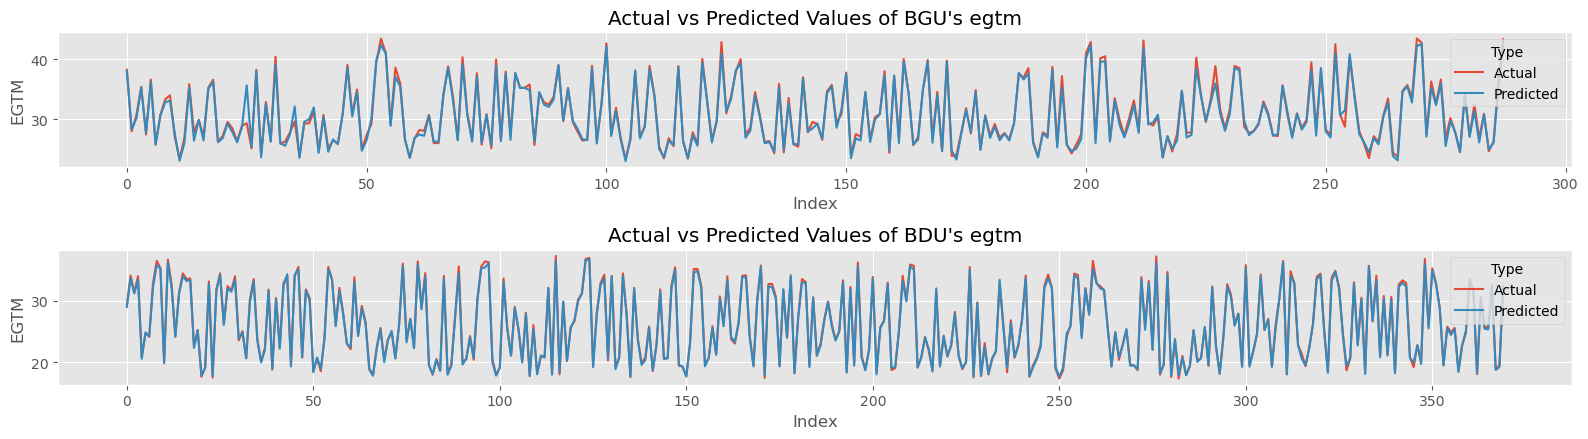

In [172]:
# Create DataFrames with the actual and predicted values
results_BGU_df = pd.DataFrame({
    'Actual': y_test_BGU,
    'Predicted': y_pred_BGU
}).reset_index(drop=True)

results_BDU_df = pd.DataFrame({
    'Actual': y_test_BDU,
    'Predicted': y_pred_BDU
}).reset_index(drop=True)

# Melt the DataFrames to long format for seaborn's relplot
results_BGU_long_df = results_BGU_df.melt(var_name='Type', value_name='EGTM', ignore_index=False).reset_index()
results_BDU_long_df = results_BDU_df.melt(var_name='Type', value_name='EGTM', ignore_index=False).reset_index()

# Create a figure with 16:4.5 aspect ratio
fig, axs = plt.subplots(2, 1, figsize=(16, 4.5))

# Plot the first subplot for BGU
sns.lineplot(data=results_BGU_long_df, x='index', y='EGTM', hue='Type', ax=axs[0])
axs[0].set_title("Actual vs Predicted Values of BGU's egtm")
axs[0].set_xlabel('Index')
axs[0].set_ylabel('EGTM')
axs[0].legend(title='Type')

# Plot the second subplot for BDU
sns.lineplot(data=results_BDU_long_df, x='index', y='EGTM', hue='Type', ax=axs[1])
axs[1].set_title("Actual vs Predicted Values of BDU's egtm")
axs[1].set_xlabel('Index')
axs[1].set_ylabel('EGTM')
axs[1].legend(title='Type')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()